<a href="https://colab.research.google.com/github/always-reach/GAN/blob/dcgan/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from tensorflow.keras import Sequential,datasets
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Flatten,LeakyReLU,BatchNormalization,Reshape,Convolution2D,Dropout,MaxPooling2D,Activation,UpSampling2D,Conv2DTranspose
from sklearn.model_selection import train_test_split

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import random
import os

In [19]:
def set_seed(seed=200):
    tf.random.set_seed(seed)

    # optional
    # for numpy.random
    np.random.seed(seed)
    # for built-in random
    random.seed(seed)
    # for hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)

In [45]:
class DCGAN():
  def __init__(self):
    #mnist画像の幅
    self.image_row=28
    #mnist画像の高さ
    self.image_col=28
    #mnist画像のチャンネル数
    self.channels=1
    self.image_shape=(self.image_row,self.image_col,self.channels)
    #入力ノイズの次元数
    self.z_input_dim=100
    #最適化アルゴリズムはAdam
    optimizer=Adam()

    #初期シード固定
    set_seed()
    self.discriminator=self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=["accuracy"])

    #初期シード固定
    set_seed()
    self.generator=self.build_generator()
    #初期シード固定
    set_seed()
    self.combined=self.build_combined()
    self.combined.compile(loss='binary_crossentropy',optimizer=optimizer)

  def build_discriminator(self):
    model = Sequential()
    model.add(Convolution2D(filters=64, kernel_size=5,strides=2, input_shape=self.image_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Convolution2D(filters=128, kernel_size=5,strides=2))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))   
    model.summary()

    return model

  def build_generator(self):
    noise_shape=(self.z_input_dim,)
    model = Sequential()
    model.add(Dense(units=1024,input_shape=noise_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(128*7*7))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #入力のノイズデータが1次元のため、Reshapeで3次元データに変換
    model.add(Reshape(target_shape=(7,7,128),input_shape=(128*7*7,)))
    model.add(UpSampling2D(size=(2,2)))
    model.add(Convolution2D(filters=64,kernel_size=5,strides=1,padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling2D(size=(2,2)))
    model.add(Convolution2D(filters=1,kernel_size=5,strides=1,padding='same',activation='tanh'))
    model.summary()
    
    return model

  def build_combined(self):
    self.discriminator.trainable=False
    model=Sequential([self.generator,self.discriminator])
    return model

  def train(self,epochs,batch_size=128,save_interval=100):
    print("training start")
    (x_train,y_train),(x_test,y_test)=datasets.mnist.load_data()
    x_train=(x_train.astype(np.float32)-127.5)/127.5
    x_train=np.expand_dims(x_train,axis=3)

    half_batch=int(batch_size/2)

    real = np.ones((half_batch, 1))
    fake = np.zeros((half_batch, 1))

    for epoch in range(epochs):
      idx = np.random.randint(0, x_train.shape[0], half_batch)
      imgs = x_train[idx]

      noise = np.random.uniform(-1, 1, (half_batch, self.z_input_dim))
      gen_imgs = self.generator.predict(noise)
      d_loss_real = self.discriminator.train_on_batch(imgs, real)
      d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
      d_loss,  accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

      noise = np.random.uniform(-1, 1, (batch_size, self.z_input_dim))
      g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))
      
      print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %(epoch + 1, d_loss, 100.0 * accuracy, g_loss))

      if (epoch+1) % save_interval==0:
        plt.figure(figsize=(10,10))
        x = gen_imgs[:10]
        for i in range(10):
          plt.subplot(1,10, i+1)
          # 画像を見やすいように座標軸を非表示にする。
          plt.axis("off")
          # 画像を表示
          plt.imshow(x[i].reshape([28,28]), cmap='gray')
        plt.tight_layout()
        plt.show()


Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 12, 12, 64)        1664      
                                                                 
 leaky_re_lu_58 (LeakyReLU)  (None, 12, 12, 64)        0         
                                                                 
 conv2d_71 (Conv2D)          (None, 4, 4, 128)         204928    
                                                                 
 leaky_re_lu_59 (LeakyReLU)  (None, 4, 4, 128)         0         
                                                                 
 dropout_32 (Dropout)        (None, 4, 4, 128)         0         
                                                                 
 flatten_19 (Flatten)        (None, 2048)              0         
                                                                 
 dense_71 (Dense)            (None, 256)             

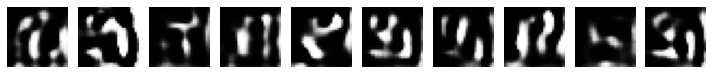

101 [D loss: 0.501659, acc.: 80.47%] [G loss: 0.930015]
102 [D loss: 0.276910, acc.: 89.06%] [G loss: 1.167457]
103 [D loss: 0.458914, acc.: 78.12%] [G loss: 0.857574]
104 [D loss: 0.394351, acc.: 82.81%] [G loss: 0.542739]
105 [D loss: 0.398215, acc.: 85.94%] [G loss: 0.600921]
106 [D loss: 0.228936, acc.: 91.41%] [G loss: 1.304246]
107 [D loss: 0.149167, acc.: 96.09%] [G loss: 2.021812]
108 [D loss: 0.311143, acc.: 87.50%] [G loss: 1.495199]
109 [D loss: 0.184743, acc.: 94.53%] [G loss: 1.089434]
110 [D loss: 0.203615, acc.: 91.41%] [G loss: 0.967098]
111 [D loss: 0.171023, acc.: 93.75%] [G loss: 1.168000]
112 [D loss: 0.184132, acc.: 92.19%] [G loss: 1.815402]
113 [D loss: 0.207759, acc.: 91.41%] [G loss: 1.747692]
114 [D loss: 0.231694, acc.: 90.62%] [G loss: 1.407332]
115 [D loss: 0.199352, acc.: 91.41%] [G loss: 0.875912]
116 [D loss: 0.296125, acc.: 87.50%] [G loss: 1.146914]
117 [D loss: 0.245353, acc.: 89.06%] [G loss: 1.167664]
118 [D loss: 0.319388, acc.: 89.84%] [G loss: 1.

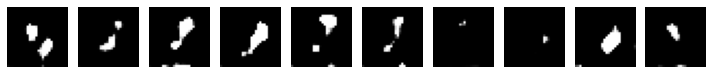

201 [D loss: 0.198482, acc.: 92.97%] [G loss: 1.476275]
202 [D loss: 0.139562, acc.: 91.41%] [G loss: 0.887270]
203 [D loss: 0.155997, acc.: 92.97%] [G loss: 0.623724]
204 [D loss: 0.117812, acc.: 96.09%] [G loss: 0.505167]
205 [D loss: 0.133508, acc.: 96.09%] [G loss: 0.290114]
206 [D loss: 0.113785, acc.: 95.31%] [G loss: 0.344132]
207 [D loss: 0.188696, acc.: 92.19%] [G loss: 0.410547]
208 [D loss: 0.087275, acc.: 96.09%] [G loss: 0.537585]
209 [D loss: 0.183193, acc.: 93.75%] [G loss: 0.484135]
210 [D loss: 0.092750, acc.: 95.31%] [G loss: 0.410257]
211 [D loss: 0.082022, acc.: 98.44%] [G loss: 0.334518]
212 [D loss: 0.133002, acc.: 95.31%] [G loss: 0.267663]
213 [D loss: 0.170779, acc.: 92.19%] [G loss: 0.202864]
214 [D loss: 0.105912, acc.: 96.09%] [G loss: 0.255103]
215 [D loss: 0.109656, acc.: 95.31%] [G loss: 0.390285]
216 [D loss: 0.233670, acc.: 93.75%] [G loss: 0.163900]
217 [D loss: 0.165321, acc.: 92.19%] [G loss: 0.179031]
218 [D loss: 0.219490, acc.: 89.06%] [G loss: 0.

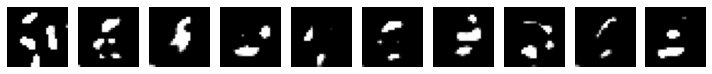

301 [D loss: 0.210308, acc.: 90.62%] [G loss: 0.812406]
302 [D loss: 0.221029, acc.: 90.62%] [G loss: 0.972946]
303 [D loss: 0.154999, acc.: 96.09%] [G loss: 1.113026]
304 [D loss: 0.203206, acc.: 92.19%] [G loss: 1.227489]
305 [D loss: 0.240049, acc.: 89.84%] [G loss: 1.590815]
306 [D loss: 0.261459, acc.: 89.84%] [G loss: 2.111101]
307 [D loss: 0.357744, acc.: 85.16%] [G loss: 2.387417]
308 [D loss: 0.298674, acc.: 91.41%] [G loss: 2.263805]
309 [D loss: 0.309616, acc.: 85.94%] [G loss: 2.621310]
310 [D loss: 0.346011, acc.: 88.28%] [G loss: 2.618834]
311 [D loss: 0.291749, acc.: 86.72%] [G loss: 3.084162]
312 [D loss: 0.221652, acc.: 88.28%] [G loss: 3.208456]
313 [D loss: 0.294371, acc.: 89.06%] [G loss: 3.261360]
314 [D loss: 0.146261, acc.: 95.31%] [G loss: 3.106716]
315 [D loss: 0.226119, acc.: 92.19%] [G loss: 3.192425]
316 [D loss: 0.196731, acc.: 93.75%] [G loss: 3.167751]
317 [D loss: 0.221120, acc.: 89.06%] [G loss: 3.294358]
318 [D loss: 0.108701, acc.: 97.66%] [G loss: 3.

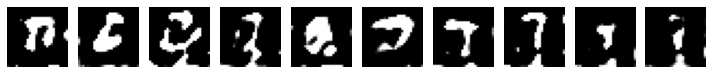

401 [D loss: 0.147822, acc.: 95.31%] [G loss: 2.858398]
402 [D loss: 0.156463, acc.: 94.53%] [G loss: 2.627297]
403 [D loss: 0.239950, acc.: 89.84%] [G loss: 2.443104]
404 [D loss: 0.192389, acc.: 96.09%] [G loss: 3.005427]
405 [D loss: 0.115665, acc.: 96.09%] [G loss: 3.358476]
406 [D loss: 0.170347, acc.: 95.31%] [G loss: 3.182001]
407 [D loss: 0.113861, acc.: 96.09%] [G loss: 3.069594]
408 [D loss: 0.132073, acc.: 93.75%] [G loss: 2.722854]
409 [D loss: 0.072914, acc.: 97.66%] [G loss: 3.219117]
410 [D loss: 0.094474, acc.: 98.44%] [G loss: 3.502763]
411 [D loss: 0.080845, acc.: 96.09%] [G loss: 3.612098]
412 [D loss: 0.098083, acc.: 96.88%] [G loss: 3.950995]
413 [D loss: 0.133399, acc.: 93.75%] [G loss: 3.903037]
414 [D loss: 0.111920, acc.: 95.31%] [G loss: 3.777261]
415 [D loss: 0.062562, acc.: 98.44%] [G loss: 3.955218]
416 [D loss: 0.100328, acc.: 96.88%] [G loss: 4.588032]
417 [D loss: 0.120485, acc.: 94.53%] [G loss: 4.174113]
418 [D loss: 0.117421, acc.: 96.88%] [G loss: 4.

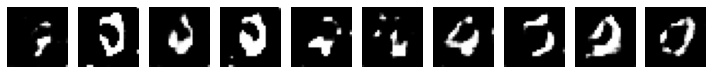

501 [D loss: 0.147853, acc.: 94.53%] [G loss: 5.076218]
502 [D loss: 0.073843, acc.: 96.88%] [G loss: 6.146493]
503 [D loss: 0.066244, acc.: 98.44%] [G loss: 6.513888]
504 [D loss: 0.046054, acc.: 99.22%] [G loss: 6.052847]
505 [D loss: 0.153518, acc.: 92.97%] [G loss: 5.081574]
506 [D loss: 0.142694, acc.: 94.53%] [G loss: 5.610916]
507 [D loss: 0.092227, acc.: 95.31%] [G loss: 6.766021]
508 [D loss: 0.151408, acc.: 95.31%] [G loss: 6.424852]
509 [D loss: 0.087597, acc.: 96.88%] [G loss: 4.819293]
510 [D loss: 0.108935, acc.: 96.09%] [G loss: 3.800286]
511 [D loss: 0.124114, acc.: 95.31%] [G loss: 4.794853]
512 [D loss: 0.182233, acc.: 92.97%] [G loss: 4.839514]
513 [D loss: 0.087513, acc.: 96.09%] [G loss: 4.924417]
514 [D loss: 0.211415, acc.: 91.41%] [G loss: 3.560957]
515 [D loss: 0.198725, acc.: 94.53%] [G loss: 2.886429]
516 [D loss: 0.108637, acc.: 96.09%] [G loss: 2.656011]
517 [D loss: 0.122995, acc.: 94.53%] [G loss: 3.249702]
518 [D loss: 0.107622, acc.: 95.31%] [G loss: 3.

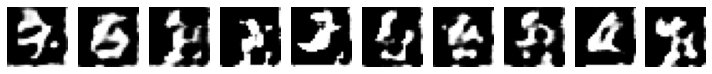

601 [D loss: 0.104279, acc.: 96.09%] [G loss: 1.157609]
602 [D loss: 0.101146, acc.: 95.31%] [G loss: 0.538591]
603 [D loss: 0.156718, acc.: 94.53%] [G loss: 0.646922]
604 [D loss: 0.267406, acc.: 89.06%] [G loss: 1.146166]
605 [D loss: 0.130078, acc.: 94.53%] [G loss: 3.027217]
606 [D loss: 0.408629, acc.: 82.81%] [G loss: 2.207787]
607 [D loss: 0.367967, acc.: 84.38%] [G loss: 2.617643]
608 [D loss: 0.279225, acc.: 83.59%] [G loss: 3.740686]
609 [D loss: 0.385367, acc.: 84.38%] [G loss: 1.946037]
610 [D loss: 0.292731, acc.: 88.28%] [G loss: 3.088444]
611 [D loss: 0.158997, acc.: 95.31%] [G loss: 5.773286]
612 [D loss: 0.368509, acc.: 88.28%] [G loss: 3.533646]
613 [D loss: 0.188688, acc.: 91.41%] [G loss: 2.234048]
614 [D loss: 0.602648, acc.: 80.47%] [G loss: 3.077713]
615 [D loss: 1.016372, acc.: 62.50%] [G loss: 3.968405]
616 [D loss: 0.813112, acc.: 69.53%] [G loss: 3.653897]
617 [D loss: 0.848906, acc.: 67.97%] [G loss: 2.674276]
618 [D loss: 0.527279, acc.: 78.12%] [G loss: 2.

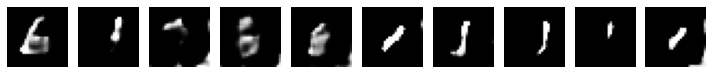

701 [D loss: 0.147908, acc.: 95.31%] [G loss: 0.579449]
702 [D loss: 0.109768, acc.: 96.09%] [G loss: 0.575801]
703 [D loss: 0.121542, acc.: 96.09%] [G loss: 0.545872]
704 [D loss: 0.230669, acc.: 91.41%] [G loss: 0.344780]
705 [D loss: 0.173865, acc.: 92.19%] [G loss: 0.358694]
706 [D loss: 0.136725, acc.: 94.53%] [G loss: 0.415355]
707 [D loss: 0.218250, acc.: 89.84%] [G loss: 0.415025]
708 [D loss: 0.222672, acc.: 90.62%] [G loss: 0.307836]
709 [D loss: 0.198290, acc.: 92.97%] [G loss: 0.461174]
710 [D loss: 0.310918, acc.: 89.06%] [G loss: 0.455112]
711 [D loss: 0.235042, acc.: 92.19%] [G loss: 0.300614]
712 [D loss: 0.437108, acc.: 83.59%] [G loss: 0.355033]
713 [D loss: 0.302556, acc.: 85.16%] [G loss: 0.235613]
714 [D loss: 0.356968, acc.: 82.81%] [G loss: 0.273838]
715 [D loss: 0.270670, acc.: 85.16%] [G loss: 0.508484]
716 [D loss: 0.241798, acc.: 89.06%] [G loss: 0.760292]
717 [D loss: 0.260414, acc.: 89.84%] [G loss: 0.986338]
718 [D loss: 0.390320, acc.: 82.03%] [G loss: 0.

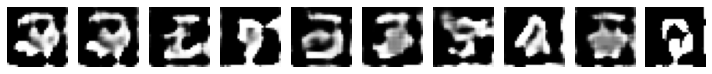

801 [D loss: 0.072723, acc.: 96.88%] [G loss: 1.445409]
802 [D loss: 0.107490, acc.: 94.53%] [G loss: 1.628431]
803 [D loss: 0.109319, acc.: 96.88%] [G loss: 1.800736]
804 [D loss: 0.114279, acc.: 95.31%] [G loss: 1.588514]
805 [D loss: 0.066550, acc.: 98.44%] [G loss: 1.324064]
806 [D loss: 0.138556, acc.: 94.53%] [G loss: 1.271867]
807 [D loss: 0.072120, acc.: 99.22%] [G loss: 1.359163]
808 [D loss: 0.149675, acc.: 92.19%] [G loss: 1.104460]
809 [D loss: 0.143971, acc.: 93.75%] [G loss: 1.621562]
810 [D loss: 0.107525, acc.: 94.53%] [G loss: 1.646303]
811 [D loss: 0.190671, acc.: 92.19%] [G loss: 1.604435]
812 [D loss: 0.194458, acc.: 92.97%] [G loss: 1.650681]
813 [D loss: 0.269075, acc.: 88.28%] [G loss: 1.762320]
814 [D loss: 0.154535, acc.: 92.19%] [G loss: 1.683391]
815 [D loss: 0.233820, acc.: 90.62%] [G loss: 1.776105]
816 [D loss: 0.316437, acc.: 88.28%] [G loss: 1.897233]
817 [D loss: 0.297946, acc.: 89.06%] [G loss: 1.855490]
818 [D loss: 0.184095, acc.: 90.62%] [G loss: 2.

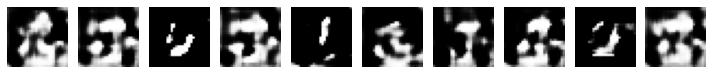

901 [D loss: 0.212839, acc.: 92.19%] [G loss: 0.836744]
902 [D loss: 0.136146, acc.: 92.19%] [G loss: 0.820404]
903 [D loss: 0.138231, acc.: 95.31%] [G loss: 0.900695]
904 [D loss: 0.140410, acc.: 95.31%] [G loss: 0.941910]
905 [D loss: 0.066913, acc.: 96.88%] [G loss: 1.190689]
906 [D loss: 0.185848, acc.: 91.41%] [G loss: 1.115942]
907 [D loss: 0.220484, acc.: 92.97%] [G loss: 0.883495]
908 [D loss: 0.126285, acc.: 96.09%] [G loss: 0.920700]
909 [D loss: 0.111860, acc.: 96.09%] [G loss: 0.827684]
910 [D loss: 0.183142, acc.: 93.75%] [G loss: 0.979798]
911 [D loss: 0.108019, acc.: 96.09%] [G loss: 1.238545]
912 [D loss: 0.093616, acc.: 96.88%] [G loss: 1.504478]
913 [D loss: 0.125390, acc.: 95.31%] [G loss: 1.207112]
914 [D loss: 0.105651, acc.: 94.53%] [G loss: 1.320884]
915 [D loss: 0.112065, acc.: 97.66%] [G loss: 0.939445]
916 [D loss: 0.090451, acc.: 95.31%] [G loss: 0.964335]
917 [D loss: 0.150176, acc.: 92.19%] [G loss: 0.780524]
918 [D loss: 0.131320, acc.: 95.31%] [G loss: 0.

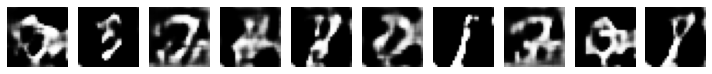

1001 [D loss: 0.210408, acc.: 88.28%] [G loss: 0.708233]
1002 [D loss: 0.147788, acc.: 93.75%] [G loss: 1.037979]
1003 [D loss: 0.141438, acc.: 95.31%] [G loss: 1.587854]
1004 [D loss: 0.168713, acc.: 90.62%] [G loss: 1.619721]
1005 [D loss: 0.168447, acc.: 91.41%] [G loss: 0.887306]
1006 [D loss: 0.113098, acc.: 94.53%] [G loss: 0.796829]
1007 [D loss: 0.100854, acc.: 97.66%] [G loss: 0.828363]
1008 [D loss: 0.104832, acc.: 96.88%] [G loss: 1.319767]
1009 [D loss: 0.107856, acc.: 97.66%] [G loss: 2.327863]
1010 [D loss: 0.078062, acc.: 97.66%] [G loss: 3.500554]
1011 [D loss: 0.083438, acc.: 96.88%] [G loss: 3.800997]
1012 [D loss: 0.103063, acc.: 94.53%] [G loss: 3.276593]
1013 [D loss: 0.132102, acc.: 95.31%] [G loss: 2.930053]
1014 [D loss: 0.108642, acc.: 95.31%] [G loss: 2.396985]
1015 [D loss: 0.122570, acc.: 95.31%] [G loss: 2.557948]
1016 [D loss: 0.059573, acc.: 97.66%] [G loss: 2.615285]
1017 [D loss: 0.066074, acc.: 97.66%] [G loss: 2.470512]
1018 [D loss: 0.099273, acc.: 9

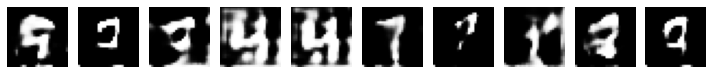

1101 [D loss: 0.126483, acc.: 96.09%] [G loss: 2.222106]
1102 [D loss: 0.065320, acc.: 96.88%] [G loss: 1.991622]
1103 [D loss: 0.107003, acc.: 96.88%] [G loss: 1.339846]
1104 [D loss: 0.100882, acc.: 96.09%] [G loss: 1.343162]
1105 [D loss: 0.155066, acc.: 91.41%] [G loss: 1.216439]
1106 [D loss: 0.102864, acc.: 96.09%] [G loss: 1.509751]
1107 [D loss: 0.157701, acc.: 93.75%] [G loss: 1.703856]
1108 [D loss: 0.061679, acc.: 98.44%] [G loss: 1.734039]
1109 [D loss: 0.114258, acc.: 92.97%] [G loss: 1.027977]
1110 [D loss: 0.086144, acc.: 96.88%] [G loss: 1.015683]
1111 [D loss: 0.058350, acc.: 97.66%] [G loss: 0.977531]
1112 [D loss: 0.096135, acc.: 95.31%] [G loss: 1.088604]
1113 [D loss: 0.122169, acc.: 94.53%] [G loss: 1.027285]
1114 [D loss: 0.104936, acc.: 94.53%] [G loss: 0.606282]
1115 [D loss: 0.048956, acc.: 98.44%] [G loss: 0.822121]
1116 [D loss: 0.143904, acc.: 96.09%] [G loss: 0.880102]
1117 [D loss: 0.098065, acc.: 97.66%] [G loss: 1.148629]
1118 [D loss: 0.332368, acc.: 8

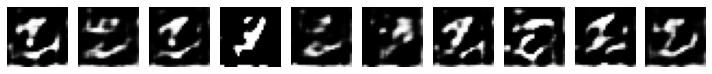

1201 [D loss: 0.191656, acc.: 92.97%] [G loss: 1.023048]
1202 [D loss: 0.083381, acc.: 96.88%] [G loss: 1.207904]
1203 [D loss: 0.062382, acc.: 97.66%] [G loss: 1.251422]
1204 [D loss: 0.091603, acc.: 96.09%] [G loss: 1.608658]
1205 [D loss: 0.080602, acc.: 96.88%] [G loss: 2.189385]
1206 [D loss: 0.043975, acc.: 97.66%] [G loss: 2.044560]
1207 [D loss: 0.136917, acc.: 96.09%] [G loss: 2.041921]
1208 [D loss: 0.109281, acc.: 96.09%] [G loss: 1.857082]
1209 [D loss: 0.079926, acc.: 98.44%] [G loss: 1.012540]
1210 [D loss: 0.161825, acc.: 92.97%] [G loss: 0.863136]
1211 [D loss: 0.104490, acc.: 96.09%] [G loss: 0.887236]
1212 [D loss: 0.052581, acc.: 99.22%] [G loss: 1.136384]
1213 [D loss: 0.080295, acc.: 95.31%] [G loss: 1.635605]
1214 [D loss: 0.115244, acc.: 94.53%] [G loss: 1.370046]
1215 [D loss: 0.092287, acc.: 99.22%] [G loss: 1.268418]
1216 [D loss: 0.055313, acc.: 97.66%] [G loss: 1.189899]
1217 [D loss: 0.210336, acc.: 91.41%] [G loss: 0.776193]
1218 [D loss: 0.074016, acc.: 9

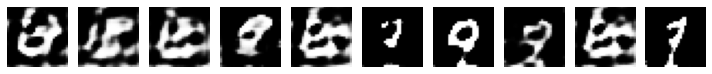

1301 [D loss: 0.178463, acc.: 92.19%] [G loss: 0.336139]
1302 [D loss: 0.123703, acc.: 95.31%] [G loss: 0.471246]
1303 [D loss: 0.083802, acc.: 96.09%] [G loss: 0.718752]
1304 [D loss: 0.029872, acc.: 99.22%] [G loss: 1.057001]
1305 [D loss: 0.113599, acc.: 96.88%] [G loss: 1.263211]
1306 [D loss: 0.153789, acc.: 94.53%] [G loss: 1.107111]
1307 [D loss: 0.070428, acc.: 97.66%] [G loss: 1.128420]
1308 [D loss: 0.143729, acc.: 95.31%] [G loss: 0.980088]
1309 [D loss: 0.079829, acc.: 97.66%] [G loss: 0.952096]
1310 [D loss: 0.178573, acc.: 92.97%] [G loss: 0.807452]
1311 [D loss: 0.078898, acc.: 97.66%] [G loss: 0.755418]
1312 [D loss: 0.073171, acc.: 96.88%] [G loss: 0.617978]
1313 [D loss: 0.139891, acc.: 94.53%] [G loss: 0.359836]
1314 [D loss: 0.094390, acc.: 97.66%] [G loss: 0.202245]
1315 [D loss: 0.143625, acc.: 92.19%] [G loss: 0.304220]
1316 [D loss: 0.119271, acc.: 96.88%] [G loss: 0.572019]
1317 [D loss: 0.104082, acc.: 96.09%] [G loss: 0.920251]
1318 [D loss: 0.232310, acc.: 9

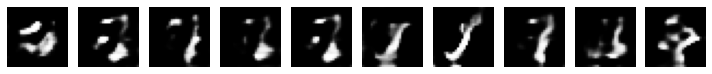

1401 [D loss: 0.143275, acc.: 92.97%] [G loss: 1.851478]
1402 [D loss: 0.129380, acc.: 94.53%] [G loss: 1.660910]
1403 [D loss: 0.101726, acc.: 94.53%] [G loss: 2.081031]
1404 [D loss: 0.159491, acc.: 92.19%] [G loss: 2.728052]
1405 [D loss: 0.090418, acc.: 95.31%] [G loss: 3.193754]
1406 [D loss: 0.107025, acc.: 96.88%] [G loss: 3.578372]
1407 [D loss: 0.093156, acc.: 97.66%] [G loss: 3.806538]
1408 [D loss: 0.150216, acc.: 94.53%] [G loss: 3.437255]
1409 [D loss: 0.095180, acc.: 96.09%] [G loss: 3.421524]
1410 [D loss: 0.107647, acc.: 95.31%] [G loss: 2.593110]
1411 [D loss: 0.114537, acc.: 96.88%] [G loss: 2.655869]
1412 [D loss: 0.109345, acc.: 93.75%] [G loss: 2.422966]
1413 [D loss: 0.097735, acc.: 96.09%] [G loss: 3.216431]
1414 [D loss: 0.049740, acc.: 98.44%] [G loss: 2.919976]
1415 [D loss: 0.074819, acc.: 97.66%] [G loss: 2.530057]
1416 [D loss: 0.166130, acc.: 94.53%] [G loss: 2.124349]
1417 [D loss: 0.144606, acc.: 94.53%] [G loss: 2.955544]
1418 [D loss: 0.062329, acc.: 9

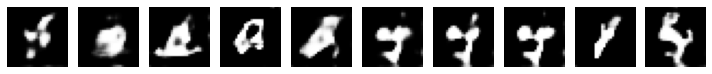

1501 [D loss: 0.084901, acc.: 96.09%] [G loss: 1.283610]
1502 [D loss: 0.074711, acc.: 96.09%] [G loss: 1.435253]
1503 [D loss: 0.115238, acc.: 96.09%] [G loss: 1.717937]
1504 [D loss: 0.137273, acc.: 95.31%] [G loss: 1.543366]
1505 [D loss: 0.132072, acc.: 95.31%] [G loss: 1.646750]
1506 [D loss: 0.175281, acc.: 92.19%] [G loss: 1.601630]
1507 [D loss: 0.061862, acc.: 98.44%] [G loss: 1.175164]
1508 [D loss: 0.198417, acc.: 92.97%] [G loss: 1.264612]
1509 [D loss: 0.088273, acc.: 96.88%] [G loss: 1.506027]
1510 [D loss: 0.114443, acc.: 95.31%] [G loss: 2.176245]
1511 [D loss: 0.045003, acc.: 97.66%] [G loss: 2.125414]
1512 [D loss: 0.137724, acc.: 94.53%] [G loss: 2.140802]
1513 [D loss: 0.235294, acc.: 93.75%] [G loss: 1.516500]
1514 [D loss: 0.165906, acc.: 92.97%] [G loss: 0.908350]
1515 [D loss: 0.204031, acc.: 89.84%] [G loss: 0.803270]
1516 [D loss: 0.170390, acc.: 93.75%] [G loss: 0.820155]
1517 [D loss: 0.084960, acc.: 96.88%] [G loss: 0.889150]
1518 [D loss: 0.177396, acc.: 9

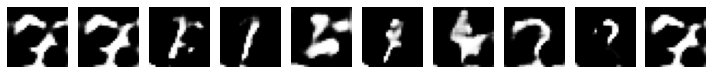

1601 [D loss: 0.135881, acc.: 92.19%] [G loss: 0.459054]
1602 [D loss: 0.147707, acc.: 93.75%] [G loss: 0.671549]
1603 [D loss: 0.117164, acc.: 96.09%] [G loss: 0.743417]
1604 [D loss: 0.154392, acc.: 92.97%] [G loss: 0.940509]
1605 [D loss: 0.068736, acc.: 98.44%] [G loss: 0.857439]
1606 [D loss: 0.139746, acc.: 95.31%] [G loss: 0.819030]
1607 [D loss: 0.129874, acc.: 93.75%] [G loss: 0.603781]
1608 [D loss: 0.093745, acc.: 96.09%] [G loss: 0.782884]
1609 [D loss: 0.109416, acc.: 95.31%] [G loss: 1.107021]
1610 [D loss: 0.107589, acc.: 94.53%] [G loss: 1.213745]
1611 [D loss: 0.172768, acc.: 92.97%] [G loss: 0.878005]
1612 [D loss: 0.117837, acc.: 95.31%] [G loss: 0.535338]
1613 [D loss: 0.109474, acc.: 94.53%] [G loss: 0.538857]
1614 [D loss: 0.164879, acc.: 92.19%] [G loss: 0.587777]
1615 [D loss: 0.196419, acc.: 92.19%] [G loss: 0.670755]
1616 [D loss: 0.130378, acc.: 94.53%] [G loss: 0.887128]
1617 [D loss: 0.206266, acc.: 91.41%] [G loss: 1.166710]
1618 [D loss: 0.128120, acc.: 9

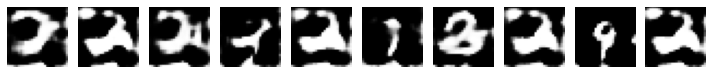

1701 [D loss: 0.048076, acc.: 99.22%] [G loss: 1.279911]
1702 [D loss: 0.070766, acc.: 97.66%] [G loss: 1.259948]
1703 [D loss: 0.055619, acc.: 97.66%] [G loss: 1.064587]
1704 [D loss: 0.079661, acc.: 97.66%] [G loss: 1.583231]
1705 [D loss: 0.105834, acc.: 94.53%] [G loss: 1.543976]
1706 [D loss: 0.083769, acc.: 96.88%] [G loss: 1.854205]
1707 [D loss: 0.101424, acc.: 96.88%] [G loss: 1.765179]
1708 [D loss: 0.053875, acc.: 98.44%] [G loss: 1.750790]
1709 [D loss: 0.105698, acc.: 96.88%] [G loss: 1.906362]
1710 [D loss: 0.155572, acc.: 94.53%] [G loss: 1.394767]
1711 [D loss: 0.211207, acc.: 92.97%] [G loss: 1.165842]
1712 [D loss: 0.238213, acc.: 91.41%] [G loss: 1.175295]
1713 [D loss: 0.157693, acc.: 94.53%] [G loss: 1.114826]
1714 [D loss: 0.104294, acc.: 97.66%] [G loss: 1.430782]
1715 [D loss: 0.184892, acc.: 92.19%] [G loss: 1.360289]
1716 [D loss: 0.094185, acc.: 96.88%] [G loss: 1.867509]
1717 [D loss: 0.161027, acc.: 94.53%] [G loss: 1.789713]
1718 [D loss: 0.241652, acc.: 9

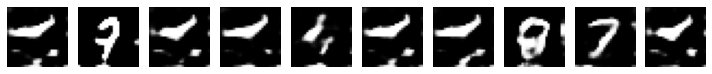

1801 [D loss: 0.102181, acc.: 96.88%] [G loss: 2.130685]
1802 [D loss: 0.057182, acc.: 97.66%] [G loss: 2.800586]
1803 [D loss: 0.033560, acc.: 98.44%] [G loss: 3.313681]
1804 [D loss: 0.042573, acc.: 98.44%] [G loss: 3.135569]
1805 [D loss: 0.071168, acc.: 96.88%] [G loss: 3.505943]
1806 [D loss: 0.091149, acc.: 97.66%] [G loss: 2.987721]
1807 [D loss: 0.049030, acc.: 98.44%] [G loss: 2.416854]
1808 [D loss: 0.068550, acc.: 96.09%] [G loss: 1.742675]
1809 [D loss: 0.050554, acc.: 98.44%] [G loss: 1.298458]
1810 [D loss: 0.093094, acc.: 94.53%] [G loss: 1.323381]
1811 [D loss: 0.045562, acc.: 98.44%] [G loss: 1.537773]
1812 [D loss: 0.073836, acc.: 96.88%] [G loss: 1.605055]
1813 [D loss: 0.106216, acc.: 95.31%] [G loss: 1.169111]
1814 [D loss: 0.068764, acc.: 98.44%] [G loss: 1.235371]
1815 [D loss: 0.066249, acc.: 97.66%] [G loss: 1.448687]
1816 [D loss: 0.104487, acc.: 94.53%] [G loss: 0.809198]
1817 [D loss: 0.189280, acc.: 93.75%] [G loss: 0.810221]
1818 [D loss: 0.099493, acc.: 9

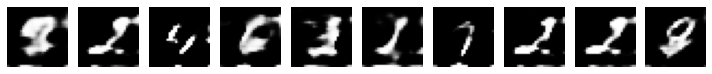

1901 [D loss: 0.195721, acc.: 91.41%] [G loss: 1.309782]
1902 [D loss: 0.097376, acc.: 96.88%] [G loss: 2.122542]
1903 [D loss: 0.205559, acc.: 92.19%] [G loss: 0.550463]
1904 [D loss: 0.251594, acc.: 89.06%] [G loss: 0.489666]
1905 [D loss: 0.130724, acc.: 91.41%] [G loss: 0.811196]
1906 [D loss: 0.075937, acc.: 96.09%] [G loss: 1.364182]
1907 [D loss: 0.347742, acc.: 85.94%] [G loss: 1.426712]
1908 [D loss: 0.276047, acc.: 90.62%] [G loss: 1.079978]
1909 [D loss: 0.147092, acc.: 94.53%] [G loss: 1.430052]
1910 [D loss: 0.193221, acc.: 90.62%] [G loss: 1.623155]
1911 [D loss: 0.153588, acc.: 92.97%] [G loss: 1.453787]
1912 [D loss: 0.134822, acc.: 95.31%] [G loss: 1.251570]
1913 [D loss: 0.213996, acc.: 89.84%] [G loss: 1.040616]
1914 [D loss: 0.137560, acc.: 92.97%] [G loss: 1.147912]
1915 [D loss: 0.118625, acc.: 95.31%] [G loss: 1.458400]
1916 [D loss: 0.187023, acc.: 94.53%] [G loss: 1.791321]
1917 [D loss: 0.162256, acc.: 94.53%] [G loss: 1.892576]
1918 [D loss: 0.327901, acc.: 8

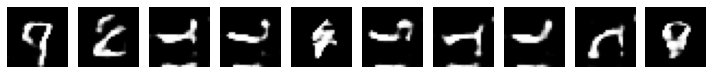

2001 [D loss: 0.038463, acc.: 99.22%] [G loss: 1.264493]
2002 [D loss: 0.153426, acc.: 96.09%] [G loss: 1.622168]
2003 [D loss: 0.084467, acc.: 96.88%] [G loss: 1.262416]
2004 [D loss: 0.094574, acc.: 95.31%] [G loss: 0.734676]
2005 [D loss: 0.073047, acc.: 97.66%] [G loss: 0.580261]
2006 [D loss: 0.108580, acc.: 93.75%] [G loss: 0.623335]
2007 [D loss: 0.136212, acc.: 94.53%] [G loss: 0.572452]
2008 [D loss: 0.085794, acc.: 96.88%] [G loss: 0.817032]
2009 [D loss: 0.057024, acc.: 96.88%] [G loss: 1.117043]
2010 [D loss: 0.084164, acc.: 96.09%] [G loss: 1.344695]
2011 [D loss: 0.088087, acc.: 95.31%] [G loss: 1.171216]
2012 [D loss: 0.101255, acc.: 96.88%] [G loss: 0.706357]
2013 [D loss: 0.200832, acc.: 92.19%] [G loss: 0.805459]
2014 [D loss: 0.098543, acc.: 96.09%] [G loss: 1.493399]
2015 [D loss: 0.103128, acc.: 96.88%] [G loss: 2.385461]
2016 [D loss: 0.150466, acc.: 93.75%] [G loss: 2.051418]
2017 [D loss: 0.141395, acc.: 91.41%] [G loss: 1.410153]
2018 [D loss: 0.139310, acc.: 9

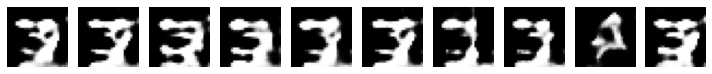

2101 [D loss: 0.114478, acc.: 95.31%] [G loss: 2.582091]
2102 [D loss: 0.086544, acc.: 97.66%] [G loss: 1.717282]
2103 [D loss: 0.137228, acc.: 96.09%] [G loss: 1.293652]
2104 [D loss: 0.079744, acc.: 97.66%] [G loss: 1.185556]
2105 [D loss: 0.098663, acc.: 96.09%] [G loss: 1.484336]
2106 [D loss: 0.128997, acc.: 96.09%] [G loss: 1.819204]
2107 [D loss: 0.107891, acc.: 96.09%] [G loss: 1.771421]
2108 [D loss: 0.091597, acc.: 96.09%] [G loss: 1.618067]
2109 [D loss: 0.211059, acc.: 92.97%] [G loss: 1.090511]
2110 [D loss: 0.172990, acc.: 95.31%] [G loss: 1.282843]
2111 [D loss: 0.077774, acc.: 96.09%] [G loss: 1.966298]
2112 [D loss: 0.086140, acc.: 96.88%] [G loss: 2.658326]
2113 [D loss: 0.316797, acc.: 94.53%] [G loss: 2.343481]
2114 [D loss: 0.108548, acc.: 97.66%] [G loss: 1.752183]
2115 [D loss: 0.129014, acc.: 95.31%] [G loss: 1.658564]
2116 [D loss: 0.233091, acc.: 91.41%] [G loss: 1.066195]
2117 [D loss: 0.077078, acc.: 96.88%] [G loss: 0.802383]
2118 [D loss: 0.188575, acc.: 9

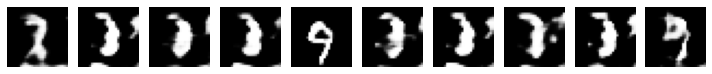

2201 [D loss: 0.137699, acc.: 92.97%] [G loss: 0.823543]
2202 [D loss: 0.122129, acc.: 96.09%] [G loss: 1.082028]
2203 [D loss: 0.120143, acc.: 93.75%] [G loss: 1.405611]
2204 [D loss: 0.254099, acc.: 89.06%] [G loss: 1.088530]
2205 [D loss: 0.133132, acc.: 94.53%] [G loss: 0.745897]
2206 [D loss: 0.153308, acc.: 93.75%] [G loss: 0.746017]
2207 [D loss: 0.195959, acc.: 92.19%] [G loss: 0.745509]
2208 [D loss: 0.139521, acc.: 93.75%] [G loss: 1.327488]
2209 [D loss: 0.056710, acc.: 97.66%] [G loss: 2.100024]
2210 [D loss: 0.070760, acc.: 98.44%] [G loss: 2.574022]
2211 [D loss: 0.108058, acc.: 96.09%] [G loss: 2.425129]
2212 [D loss: 0.105826, acc.: 97.66%] [G loss: 1.536385]
2213 [D loss: 0.080695, acc.: 97.66%] [G loss: 1.384018]
2214 [D loss: 0.112444, acc.: 96.09%] [G loss: 1.525609]
2215 [D loss: 0.071304, acc.: 96.88%] [G loss: 1.521626]
2216 [D loss: 0.098580, acc.: 95.31%] [G loss: 1.620805]
2217 [D loss: 0.049380, acc.: 99.22%] [G loss: 1.759941]
2218 [D loss: 0.098248, acc.: 9

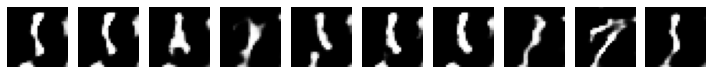

2301 [D loss: 0.109141, acc.: 94.53%] [G loss: 0.914291]
2302 [D loss: 0.077644, acc.: 96.09%] [G loss: 0.919211]
2303 [D loss: 0.150279, acc.: 94.53%] [G loss: 0.695413]
2304 [D loss: 0.119136, acc.: 94.53%] [G loss: 0.503149]
2305 [D loss: 0.124382, acc.: 96.09%] [G loss: 0.921428]
2306 [D loss: 0.166711, acc.: 94.53%] [G loss: 1.123657]
2307 [D loss: 0.045453, acc.: 98.44%] [G loss: 1.360564]
2308 [D loss: 0.136325, acc.: 94.53%] [G loss: 1.150842]
2309 [D loss: 0.101380, acc.: 97.66%] [G loss: 1.133837]
2310 [D loss: 0.085016, acc.: 95.31%] [G loss: 0.886618]
2311 [D loss: 0.096961, acc.: 96.09%] [G loss: 0.695479]
2312 [D loss: 0.111157, acc.: 95.31%] [G loss: 0.743212]
2313 [D loss: 0.124399, acc.: 95.31%] [G loss: 0.940608]
2314 [D loss: 0.081492, acc.: 95.31%] [G loss: 1.042778]
2315 [D loss: 0.070186, acc.: 96.88%] [G loss: 0.968941]
2316 [D loss: 0.049368, acc.: 98.44%] [G loss: 1.029710]
2317 [D loss: 0.067022, acc.: 96.88%] [G loss: 0.650163]
2318 [D loss: 0.142551, acc.: 9

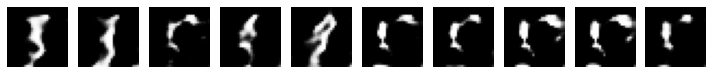

2401 [D loss: 0.037061, acc.: 99.22%] [G loss: 3.021139]
2402 [D loss: 0.080614, acc.: 96.09%] [G loss: 1.981873]
2403 [D loss: 0.094567, acc.: 97.66%] [G loss: 1.172302]
2404 [D loss: 0.063996, acc.: 98.44%] [G loss: 0.860041]
2405 [D loss: 0.171318, acc.: 93.75%] [G loss: 1.377616]
2406 [D loss: 0.062953, acc.: 98.44%] [G loss: 1.802442]
2407 [D loss: 0.040367, acc.: 98.44%] [G loss: 2.490439]
2408 [D loss: 0.150991, acc.: 91.41%] [G loss: 2.598350]
2409 [D loss: 0.104079, acc.: 97.66%] [G loss: 2.827068]
2410 [D loss: 0.079442, acc.: 96.88%] [G loss: 2.024333]
2411 [D loss: 0.080099, acc.: 97.66%] [G loss: 1.789728]
2412 [D loss: 0.078727, acc.: 97.66%] [G loss: 1.799188]
2413 [D loss: 0.082910, acc.: 95.31%] [G loss: 1.761594]
2414 [D loss: 0.041569, acc.: 97.66%] [G loss: 1.866956]
2415 [D loss: 0.119811, acc.: 96.88%] [G loss: 1.467490]
2416 [D loss: 0.088915, acc.: 96.09%] [G loss: 0.788865]
2417 [D loss: 0.103630, acc.: 94.53%] [G loss: 0.511181]
2418 [D loss: 0.079731, acc.: 9

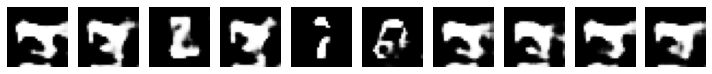

2501 [D loss: 0.099066, acc.: 96.88%] [G loss: 4.215435]
2502 [D loss: 0.138209, acc.: 95.31%] [G loss: 4.594465]
2503 [D loss: 0.115233, acc.: 95.31%] [G loss: 4.248371]
2504 [D loss: 0.161875, acc.: 94.53%] [G loss: 3.271495]
2505 [D loss: 0.107785, acc.: 95.31%] [G loss: 2.430126]
2506 [D loss: 0.128162, acc.: 95.31%] [G loss: 2.846674]
2507 [D loss: 0.091552, acc.: 96.88%] [G loss: 3.431906]
2508 [D loss: 0.076518, acc.: 96.88%] [G loss: 3.871871]
2509 [D loss: 0.062186, acc.: 97.66%] [G loss: 3.607401]
2510 [D loss: 0.116358, acc.: 95.31%] [G loss: 2.870996]
2511 [D loss: 0.062068, acc.: 96.88%] [G loss: 1.912979]
2512 [D loss: 0.035644, acc.: 99.22%] [G loss: 1.517247]
2513 [D loss: 0.125478, acc.: 95.31%] [G loss: 2.004545]
2514 [D loss: 0.034727, acc.: 99.22%] [G loss: 2.961196]
2515 [D loss: 0.053783, acc.: 97.66%] [G loss: 3.381001]
2516 [D loss: 0.087053, acc.: 97.66%] [G loss: 2.424397]
2517 [D loss: 0.035742, acc.: 100.00%] [G loss: 1.828135]
2518 [D loss: 0.053881, acc.: 

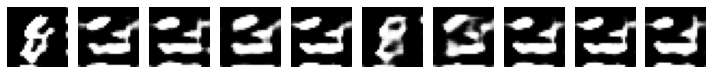

2601 [D loss: 0.132863, acc.: 96.09%] [G loss: 3.437414]
2602 [D loss: 0.130679, acc.: 95.31%] [G loss: 2.780936]
2603 [D loss: 0.092449, acc.: 98.44%] [G loss: 2.706910]
2604 [D loss: 0.049369, acc.: 99.22%] [G loss: 2.832460]
2605 [D loss: 0.154904, acc.: 94.53%] [G loss: 2.551205]
2606 [D loss: 0.040273, acc.: 98.44%] [G loss: 2.407624]
2607 [D loss: 0.113989, acc.: 93.75%] [G loss: 2.156257]
2608 [D loss: 0.100738, acc.: 96.09%] [G loss: 2.043289]
2609 [D loss: 0.107239, acc.: 96.88%] [G loss: 2.774860]
2610 [D loss: 0.045168, acc.: 99.22%] [G loss: 2.635970]
2611 [D loss: 0.042971, acc.: 98.44%] [G loss: 3.447330]
2612 [D loss: 0.060268, acc.: 98.44%] [G loss: 3.890915]
2613 [D loss: 0.188854, acc.: 90.62%] [G loss: 3.539376]
2614 [D loss: 0.063165, acc.: 97.66%] [G loss: 3.769913]
2615 [D loss: 0.096571, acc.: 97.66%] [G loss: 2.871407]
2616 [D loss: 0.164486, acc.: 92.97%] [G loss: 1.995045]
2617 [D loss: 0.320523, acc.: 89.06%] [G loss: 3.047843]
2618 [D loss: 0.048286, acc.: 9

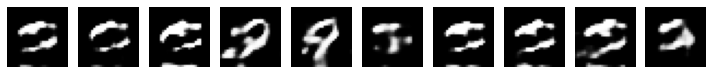

2701 [D loss: 0.107659, acc.: 96.88%] [G loss: 0.944892]
2702 [D loss: 0.144251, acc.: 94.53%] [G loss: 1.277672]
2703 [D loss: 0.058035, acc.: 97.66%] [G loss: 2.281110]
2704 [D loss: 0.141811, acc.: 92.97%] [G loss: 2.565559]
2705 [D loss: 0.032423, acc.: 99.22%] [G loss: 3.511123]
2706 [D loss: 0.086763, acc.: 96.88%] [G loss: 3.409133]
2707 [D loss: 0.187984, acc.: 91.41%] [G loss: 1.422755]
2708 [D loss: 0.103638, acc.: 95.31%] [G loss: 1.985861]
2709 [D loss: 0.138579, acc.: 95.31%] [G loss: 5.308348]
2710 [D loss: 0.115300, acc.: 94.53%] [G loss: 7.138722]
2711 [D loss: 0.079308, acc.: 96.88%] [G loss: 5.738545]
2712 [D loss: 0.158187, acc.: 95.31%] [G loss: 4.727624]
2713 [D loss: 0.157291, acc.: 95.31%] [G loss: 3.062725]
2714 [D loss: 0.082900, acc.: 96.09%] [G loss: 3.962585]
2715 [D loss: 0.102768, acc.: 94.53%] [G loss: 5.014352]
2716 [D loss: 0.105244, acc.: 96.88%] [G loss: 5.394542]
2717 [D loss: 0.098368, acc.: 97.66%] [G loss: 5.749114]
2718 [D loss: 0.100241, acc.: 9

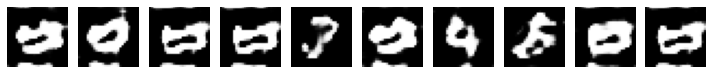

2801 [D loss: 0.161438, acc.: 92.19%] [G loss: 2.234397]
2802 [D loss: 0.111727, acc.: 96.88%] [G loss: 1.651261]
2803 [D loss: 0.128476, acc.: 92.97%] [G loss: 3.709768]
2804 [D loss: 0.082103, acc.: 95.31%] [G loss: 7.673218]
2805 [D loss: 0.120106, acc.: 96.09%] [G loss: 10.360396]
2806 [D loss: 0.173899, acc.: 92.19%] [G loss: 8.821629]
2807 [D loss: 0.100461, acc.: 96.09%] [G loss: 6.627136]
2808 [D loss: 0.159183, acc.: 92.19%] [G loss: 3.785871]
2809 [D loss: 0.133431, acc.: 94.53%] [G loss: 3.099037]
2810 [D loss: 0.149972, acc.: 92.97%] [G loss: 5.571162]
2811 [D loss: 0.180395, acc.: 95.31%] [G loss: 6.958693]
2812 [D loss: 0.071683, acc.: 96.88%] [G loss: 8.024584]
2813 [D loss: 0.157944, acc.: 93.75%] [G loss: 7.190442]
2814 [D loss: 0.144548, acc.: 94.53%] [G loss: 6.054272]
2815 [D loss: 0.344147, acc.: 92.97%] [G loss: 3.157060]
2816 [D loss: 0.422181, acc.: 89.06%] [G loss: 2.935777]
2817 [D loss: 0.131540, acc.: 92.97%] [G loss: 3.877259]
2818 [D loss: 0.065068, acc.: 

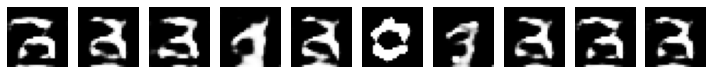

2901 [D loss: 0.127645, acc.: 93.75%] [G loss: 2.082932]
2902 [D loss: 0.061151, acc.: 98.44%] [G loss: 2.564294]
2903 [D loss: 0.157380, acc.: 92.97%] [G loss: 1.887700]
2904 [D loss: 0.118407, acc.: 94.53%] [G loss: 1.869915]
2905 [D loss: 0.071321, acc.: 96.88%] [G loss: 1.293198]
2906 [D loss: 0.146204, acc.: 93.75%] [G loss: 2.142335]
2907 [D loss: 0.179258, acc.: 93.75%] [G loss: 2.965901]
2908 [D loss: 0.117546, acc.: 94.53%] [G loss: 3.240639]
2909 [D loss: 0.094793, acc.: 95.31%] [G loss: 3.209575]
2910 [D loss: 0.055480, acc.: 99.22%] [G loss: 2.366264]
2911 [D loss: 0.136512, acc.: 94.53%] [G loss: 1.191134]
2912 [D loss: 0.236657, acc.: 90.62%] [G loss: 0.620745]
2913 [D loss: 0.228805, acc.: 90.62%] [G loss: 0.766251]
2914 [D loss: 0.081163, acc.: 97.66%] [G loss: 2.148810]
2915 [D loss: 0.138386, acc.: 94.53%] [G loss: 3.229962]
2916 [D loss: 0.250080, acc.: 85.94%] [G loss: 2.233184]
2917 [D loss: 0.269738, acc.: 86.72%] [G loss: 1.307471]
2918 [D loss: 0.235904, acc.: 9

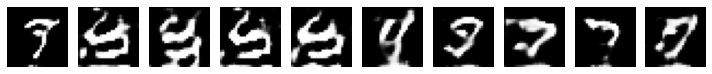

3001 [D loss: 0.121200, acc.: 94.53%] [G loss: 1.801512]
3002 [D loss: 0.090880, acc.: 96.88%] [G loss: 1.458175]
3003 [D loss: 0.133705, acc.: 92.97%] [G loss: 1.773972]
3004 [D loss: 0.161984, acc.: 92.19%] [G loss: 1.604929]
3005 [D loss: 0.108212, acc.: 96.88%] [G loss: 2.108372]
3006 [D loss: 0.153370, acc.: 95.31%] [G loss: 2.009036]
3007 [D loss: 0.100238, acc.: 96.88%] [G loss: 1.639109]
3008 [D loss: 0.067151, acc.: 96.88%] [G loss: 1.119892]
3009 [D loss: 0.256741, acc.: 89.06%] [G loss: 1.049175]
3010 [D loss: 0.112111, acc.: 96.09%] [G loss: 2.139229]
3011 [D loss: 0.077371, acc.: 97.66%] [G loss: 3.046289]
3012 [D loss: 0.095665, acc.: 96.09%] [G loss: 3.774422]
3013 [D loss: 0.137022, acc.: 94.53%] [G loss: 2.825366]
3014 [D loss: 0.128880, acc.: 94.53%] [G loss: 2.327283]
3015 [D loss: 0.192061, acc.: 92.97%] [G loss: 1.296990]
3016 [D loss: 0.076057, acc.: 96.09%] [G loss: 1.053516]
3017 [D loss: 0.086642, acc.: 96.88%] [G loss: 1.347708]
3018 [D loss: 0.074941, acc.: 9

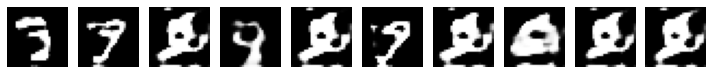

3101 [D loss: 0.156576, acc.: 92.97%] [G loss: 1.366972]
3102 [D loss: 0.276945, acc.: 87.50%] [G loss: 1.596975]
3103 [D loss: 0.070512, acc.: 96.88%] [G loss: 2.709365]
3104 [D loss: 0.177154, acc.: 91.41%] [G loss: 3.842605]
3105 [D loss: 0.315808, acc.: 89.84%] [G loss: 3.376570]
3106 [D loss: 0.246357, acc.: 91.41%] [G loss: 2.426493]
3107 [D loss: 0.164919, acc.: 92.19%] [G loss: 2.242294]
3108 [D loss: 0.279433, acc.: 89.06%] [G loss: 1.926949]
3109 [D loss: 0.142307, acc.: 94.53%] [G loss: 2.644627]
3110 [D loss: 0.210645, acc.: 90.62%] [G loss: 2.775673]
3111 [D loss: 0.303447, acc.: 89.06%] [G loss: 2.569083]
3112 [D loss: 0.239808, acc.: 91.41%] [G loss: 2.483872]
3113 [D loss: 0.146059, acc.: 95.31%] [G loss: 2.361463]
3114 [D loss: 0.141125, acc.: 93.75%] [G loss: 1.939674]
3115 [D loss: 0.167287, acc.: 94.53%] [G loss: 2.102279]
3116 [D loss: 0.144806, acc.: 94.53%] [G loss: 2.603517]
3117 [D loss: 0.092805, acc.: 98.44%] [G loss: 3.121621]
3118 [D loss: 0.104767, acc.: 9

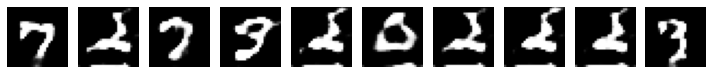

3201 [D loss: 0.109866, acc.: 96.09%] [G loss: 1.419316]
3202 [D loss: 0.114423, acc.: 93.75%] [G loss: 2.161348]
3203 [D loss: 0.088936, acc.: 96.09%] [G loss: 2.677342]
3204 [D loss: 0.135779, acc.: 94.53%] [G loss: 3.002095]
3205 [D loss: 0.102254, acc.: 95.31%] [G loss: 2.976717]
3206 [D loss: 0.123175, acc.: 93.75%] [G loss: 3.148478]
3207 [D loss: 0.112743, acc.: 96.09%] [G loss: 2.863559]
3208 [D loss: 0.141349, acc.: 93.75%] [G loss: 2.342257]
3209 [D loss: 0.134832, acc.: 93.75%] [G loss: 2.182337]
3210 [D loss: 0.164900, acc.: 93.75%] [G loss: 1.904781]
3211 [D loss: 0.112015, acc.: 94.53%] [G loss: 1.703368]
3212 [D loss: 0.179895, acc.: 92.19%] [G loss: 1.660792]
3213 [D loss: 0.074323, acc.: 97.66%] [G loss: 2.106572]
3214 [D loss: 0.144959, acc.: 95.31%] [G loss: 2.418953]
3215 [D loss: 0.106538, acc.: 97.66%] [G loss: 2.657808]
3216 [D loss: 0.138379, acc.: 92.97%] [G loss: 2.496277]
3217 [D loss: 0.230375, acc.: 92.97%] [G loss: 2.563716]
3218 [D loss: 0.192705, acc.: 9

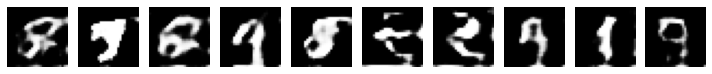

3301 [D loss: 0.142985, acc.: 92.97%] [G loss: 1.604168]
3302 [D loss: 0.108124, acc.: 95.31%] [G loss: 1.384359]
3303 [D loss: 0.197174, acc.: 91.41%] [G loss: 1.233878]
3304 [D loss: 0.126565, acc.: 95.31%] [G loss: 1.680029]
3305 [D loss: 0.174724, acc.: 91.41%] [G loss: 2.450899]
3306 [D loss: 0.116179, acc.: 96.09%] [G loss: 1.934383]
3307 [D loss: 0.167210, acc.: 94.53%] [G loss: 1.509510]
3308 [D loss: 0.158882, acc.: 91.41%] [G loss: 1.731800]
3309 [D loss: 0.083119, acc.: 96.88%] [G loss: 2.375566]
3310 [D loss: 0.217193, acc.: 91.41%] [G loss: 3.027578]
3311 [D loss: 0.125118, acc.: 94.53%] [G loss: 3.829415]
3312 [D loss: 0.152245, acc.: 95.31%] [G loss: 3.912512]
3313 [D loss: 0.195345, acc.: 93.75%] [G loss: 3.052706]
3314 [D loss: 0.072901, acc.: 98.44%] [G loss: 2.301015]
3315 [D loss: 0.127417, acc.: 96.09%] [G loss: 2.332417]
3316 [D loss: 0.114082, acc.: 95.31%] [G loss: 2.359105]
3317 [D loss: 0.118613, acc.: 94.53%] [G loss: 2.712433]
3318 [D loss: 0.181838, acc.: 9

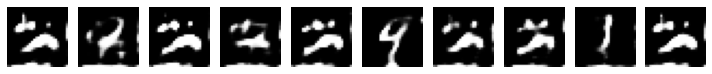

3401 [D loss: 0.116320, acc.: 95.31%] [G loss: 2.384171]
3402 [D loss: 0.207718, acc.: 92.97%] [G loss: 1.794464]
3403 [D loss: 0.187598, acc.: 93.75%] [G loss: 2.019304]
3404 [D loss: 0.118238, acc.: 95.31%] [G loss: 2.076985]
3405 [D loss: 0.223179, acc.: 92.19%] [G loss: 2.205634]
3406 [D loss: 0.261533, acc.: 90.62%] [G loss: 2.737959]
3407 [D loss: 0.216197, acc.: 89.06%] [G loss: 3.461463]
3408 [D loss: 0.123016, acc.: 95.31%] [G loss: 4.015490]
3409 [D loss: 0.127998, acc.: 95.31%] [G loss: 3.836208]
3410 [D loss: 0.180348, acc.: 96.09%] [G loss: 3.277656]
3411 [D loss: 0.188088, acc.: 92.19%] [G loss: 3.100871]
3412 [D loss: 0.158016, acc.: 92.97%] [G loss: 3.587079]
3413 [D loss: 0.112830, acc.: 95.31%] [G loss: 4.051790]
3414 [D loss: 0.222213, acc.: 90.62%] [G loss: 2.874423]
3415 [D loss: 0.219812, acc.: 93.75%] [G loss: 2.067933]
3416 [D loss: 0.165927, acc.: 91.41%] [G loss: 1.793101]
3417 [D loss: 0.099848, acc.: 97.66%] [G loss: 1.935584]
3418 [D loss: 0.144964, acc.: 9

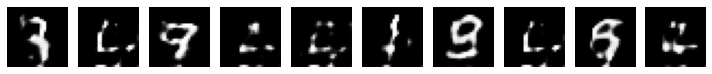

3501 [D loss: 0.290039, acc.: 85.94%] [G loss: 4.745000]
3502 [D loss: 0.141137, acc.: 92.97%] [G loss: 6.967022]
3503 [D loss: 0.281360, acc.: 89.84%] [G loss: 6.372389]
3504 [D loss: 0.149888, acc.: 92.19%] [G loss: 5.191634]
3505 [D loss: 0.143103, acc.: 93.75%] [G loss: 4.169344]
3506 [D loss: 0.121772, acc.: 94.53%] [G loss: 4.178506]
3507 [D loss: 0.126064, acc.: 95.31%] [G loss: 3.555667]
3508 [D loss: 0.102226, acc.: 97.66%] [G loss: 2.971967]
3509 [D loss: 0.149137, acc.: 96.09%] [G loss: 2.770341]
3510 [D loss: 0.127292, acc.: 96.09%] [G loss: 2.590380]
3511 [D loss: 0.242522, acc.: 90.62%] [G loss: 2.620589]
3512 [D loss: 0.128125, acc.: 93.75%] [G loss: 3.391214]
3513 [D loss: 0.161304, acc.: 93.75%] [G loss: 3.284140]
3514 [D loss: 0.147137, acc.: 91.41%] [G loss: 2.924659]
3515 [D loss: 0.156331, acc.: 92.97%] [G loss: 3.008309]
3516 [D loss: 0.069117, acc.: 96.88%] [G loss: 3.466787]
3517 [D loss: 0.075836, acc.: 96.09%] [G loss: 4.191666]
3518 [D loss: 0.043277, acc.: 9

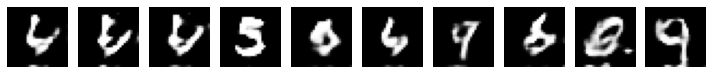

3601 [D loss: 0.145038, acc.: 95.31%] [G loss: 2.843494]
3602 [D loss: 0.226121, acc.: 89.84%] [G loss: 2.883049]
3603 [D loss: 0.253082, acc.: 88.28%] [G loss: 2.558206]
3604 [D loss: 0.297765, acc.: 85.16%] [G loss: 2.531397]
3605 [D loss: 0.229186, acc.: 90.62%] [G loss: 2.702983]
3606 [D loss: 0.226537, acc.: 89.06%] [G loss: 2.776378]
3607 [D loss: 0.185827, acc.: 89.84%] [G loss: 2.916624]
3608 [D loss: 0.142788, acc.: 96.09%] [G loss: 2.640825]
3609 [D loss: 0.123555, acc.: 96.09%] [G loss: 2.528978]
3610 [D loss: 0.276632, acc.: 87.50%] [G loss: 2.354367]
3611 [D loss: 0.186834, acc.: 90.62%] [G loss: 2.376730]
3612 [D loss: 0.178563, acc.: 92.19%] [G loss: 2.719091]
3613 [D loss: 0.126794, acc.: 96.09%] [G loss: 3.068424]
3614 [D loss: 0.191045, acc.: 94.53%] [G loss: 4.296390]
3615 [D loss: 0.181735, acc.: 94.53%] [G loss: 4.479448]
3616 [D loss: 0.204201, acc.: 92.97%] [G loss: 3.281875]
3617 [D loss: 0.162621, acc.: 92.97%] [G loss: 3.103083]
3618 [D loss: 0.209281, acc.: 9

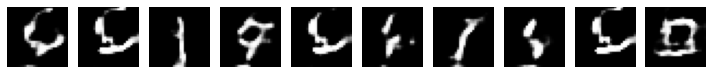

3701 [D loss: 0.289709, acc.: 88.28%] [G loss: 1.302825]
3702 [D loss: 0.385484, acc.: 86.72%] [G loss: 1.541577]
3703 [D loss: 0.156194, acc.: 92.19%] [G loss: 1.656301]
3704 [D loss: 0.111671, acc.: 97.66%] [G loss: 2.164679]
3705 [D loss: 0.179354, acc.: 92.97%] [G loss: 2.383612]
3706 [D loss: 0.153941, acc.: 93.75%] [G loss: 2.567874]
3707 [D loss: 0.180537, acc.: 92.97%] [G loss: 2.514026]
3708 [D loss: 0.172082, acc.: 92.97%] [G loss: 1.993141]
3709 [D loss: 0.117049, acc.: 96.09%] [G loss: 1.832353]
3710 [D loss: 0.148861, acc.: 92.97%] [G loss: 2.048530]
3711 [D loss: 0.194267, acc.: 90.62%] [G loss: 2.197048]
3712 [D loss: 0.140815, acc.: 94.53%] [G loss: 2.790020]
3713 [D loss: 0.114270, acc.: 96.88%] [G loss: 2.987822]
3714 [D loss: 0.161462, acc.: 93.75%] [G loss: 3.448398]
3715 [D loss: 0.084917, acc.: 96.88%] [G loss: 3.212414]
3716 [D loss: 0.166608, acc.: 91.41%] [G loss: 2.430100]
3717 [D loss: 0.148652, acc.: 95.31%] [G loss: 2.821875]
3718 [D loss: 0.175389, acc.: 9

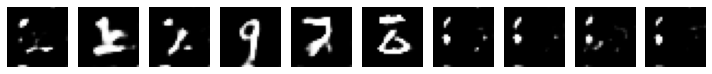

3801 [D loss: 0.167427, acc.: 95.31%] [G loss: 3.699252]
3802 [D loss: 0.208987, acc.: 90.62%] [G loss: 4.021390]
3803 [D loss: 0.224675, acc.: 91.41%] [G loss: 3.706694]
3804 [D loss: 0.236353, acc.: 86.72%] [G loss: 2.279819]
3805 [D loss: 0.173163, acc.: 93.75%] [G loss: 1.679936]
3806 [D loss: 0.188960, acc.: 90.62%] [G loss: 1.504935]
3807 [D loss: 0.125735, acc.: 93.75%] [G loss: 2.084296]
3808 [D loss: 0.157578, acc.: 96.09%] [G loss: 2.779321]
3809 [D loss: 0.132253, acc.: 95.31%] [G loss: 4.090878]
3810 [D loss: 0.227575, acc.: 90.62%] [G loss: 2.876590]
3811 [D loss: 0.178642, acc.: 91.41%] [G loss: 1.834642]
3812 [D loss: 0.164991, acc.: 92.19%] [G loss: 1.482699]
3813 [D loss: 0.160466, acc.: 91.41%] [G loss: 1.426021]
3814 [D loss: 0.233571, acc.: 92.19%] [G loss: 1.578318]
3815 [D loss: 0.079582, acc.: 98.44%] [G loss: 2.013069]
3816 [D loss: 0.138013, acc.: 96.09%] [G loss: 1.871899]
3817 [D loss: 0.217090, acc.: 92.97%] [G loss: 1.354728]
3818 [D loss: 0.189852, acc.: 9

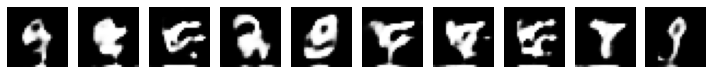

3901 [D loss: 0.195784, acc.: 91.41%] [G loss: 1.424261]
3902 [D loss: 0.168008, acc.: 96.88%] [G loss: 2.187330]
3903 [D loss: 0.162641, acc.: 93.75%] [G loss: 2.640758]
3904 [D loss: 0.244299, acc.: 90.62%] [G loss: 2.844117]
3905 [D loss: 0.129089, acc.: 95.31%] [G loss: 2.572628]
3906 [D loss: 0.164069, acc.: 91.41%] [G loss: 1.931023]
3907 [D loss: 0.099148, acc.: 96.09%] [G loss: 1.648407]
3908 [D loss: 0.167906, acc.: 93.75%] [G loss: 1.676686]
3909 [D loss: 0.127299, acc.: 96.88%] [G loss: 1.426194]
3910 [D loss: 0.340438, acc.: 85.16%] [G loss: 1.085276]
3911 [D loss: 0.135550, acc.: 94.53%] [G loss: 1.525750]
3912 [D loss: 0.164852, acc.: 94.53%] [G loss: 1.571608]
3913 [D loss: 0.238951, acc.: 89.84%] [G loss: 1.331975]
3914 [D loss: 0.181098, acc.: 92.97%] [G loss: 1.368850]
3915 [D loss: 0.122152, acc.: 97.66%] [G loss: 1.235073]
3916 [D loss: 0.169432, acc.: 92.19%] [G loss: 1.232859]
3917 [D loss: 0.197914, acc.: 92.19%] [G loss: 1.858118]
3918 [D loss: 0.163233, acc.: 9

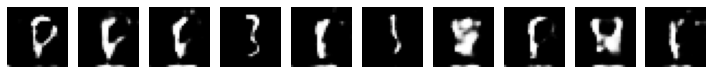

4001 [D loss: 0.138710, acc.: 97.66%] [G loss: 1.466430]
4002 [D loss: 0.098600, acc.: 94.53%] [G loss: 1.709624]
4003 [D loss: 0.084182, acc.: 96.09%] [G loss: 1.914473]
4004 [D loss: 0.134347, acc.: 96.09%] [G loss: 2.027201]
4005 [D loss: 0.158715, acc.: 94.53%] [G loss: 1.794221]
4006 [D loss: 0.153776, acc.: 94.53%] [G loss: 1.466714]
4007 [D loss: 0.120451, acc.: 96.09%] [G loss: 1.665192]
4008 [D loss: 0.139140, acc.: 94.53%] [G loss: 1.482992]
4009 [D loss: 0.192003, acc.: 92.97%] [G loss: 1.443624]
4010 [D loss: 0.069075, acc.: 97.66%] [G loss: 1.544229]
4011 [D loss: 0.147928, acc.: 94.53%] [G loss: 1.657843]
4012 [D loss: 0.227061, acc.: 93.75%] [G loss: 1.445752]
4013 [D loss: 0.197598, acc.: 93.75%] [G loss: 1.338535]
4014 [D loss: 0.209776, acc.: 92.19%] [G loss: 1.337689]
4015 [D loss: 0.123507, acc.: 93.75%] [G loss: 1.215111]
4016 [D loss: 0.228275, acc.: 86.72%] [G loss: 1.615529]
4017 [D loss: 0.221975, acc.: 91.41%] [G loss: 2.036795]
4018 [D loss: 0.143405, acc.: 9

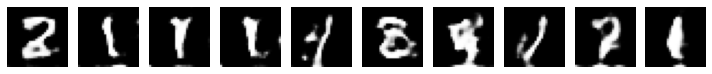

4101 [D loss: 0.226886, acc.: 92.19%] [G loss: 1.426238]
4102 [D loss: 0.252371, acc.: 88.28%] [G loss: 1.704422]
4103 [D loss: 0.234183, acc.: 95.31%] [G loss: 2.083603]
4104 [D loss: 0.217517, acc.: 91.41%] [G loss: 1.733716]
4105 [D loss: 0.210513, acc.: 91.41%] [G loss: 1.532694]
4106 [D loss: 0.207981, acc.: 90.62%] [G loss: 1.581847]
4107 [D loss: 0.129407, acc.: 96.09%] [G loss: 1.845779]
4108 [D loss: 0.248436, acc.: 89.84%] [G loss: 1.695616]
4109 [D loss: 0.153159, acc.: 94.53%] [G loss: 2.028972]
4110 [D loss: 0.157234, acc.: 95.31%] [G loss: 2.368007]
4111 [D loss: 0.161203, acc.: 94.53%] [G loss: 3.086206]
4112 [D loss: 0.210205, acc.: 90.62%] [G loss: 2.858666]
4113 [D loss: 0.202251, acc.: 92.97%] [G loss: 2.450385]
4114 [D loss: 0.253866, acc.: 88.28%] [G loss: 2.162170]
4115 [D loss: 0.127217, acc.: 97.66%] [G loss: 2.325699]
4116 [D loss: 0.214577, acc.: 90.62%] [G loss: 2.881942]
4117 [D loss: 0.238723, acc.: 92.19%] [G loss: 3.407020]
4118 [D loss: 0.301203, acc.: 9

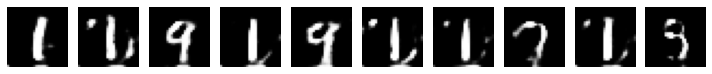

4201 [D loss: 0.154599, acc.: 93.75%] [G loss: 3.449626]
4202 [D loss: 0.108410, acc.: 97.66%] [G loss: 3.632840]
4203 [D loss: 0.205117, acc.: 91.41%] [G loss: 4.057429]
4204 [D loss: 0.145993, acc.: 95.31%] [G loss: 3.847106]
4205 [D loss: 0.163562, acc.: 90.62%] [G loss: 3.813807]
4206 [D loss: 0.185156, acc.: 93.75%] [G loss: 3.726761]
4207 [D loss: 0.248259, acc.: 89.06%] [G loss: 3.409491]
4208 [D loss: 0.242256, acc.: 89.06%] [G loss: 2.898301]
4209 [D loss: 0.154571, acc.: 91.41%] [G loss: 2.818517]
4210 [D loss: 0.167428, acc.: 91.41%] [G loss: 2.954775]
4211 [D loss: 0.172174, acc.: 93.75%] [G loss: 3.224338]
4212 [D loss: 0.181886, acc.: 92.19%] [G loss: 3.709989]
4213 [D loss: 0.174487, acc.: 90.62%] [G loss: 3.564996]
4214 [D loss: 0.264019, acc.: 85.94%] [G loss: 3.165372]
4215 [D loss: 0.207902, acc.: 90.62%] [G loss: 3.450624]
4216 [D loss: 0.178849, acc.: 92.19%] [G loss: 4.184556]
4217 [D loss: 0.191287, acc.: 89.84%] [G loss: 3.962375]
4218 [D loss: 0.190561, acc.: 9

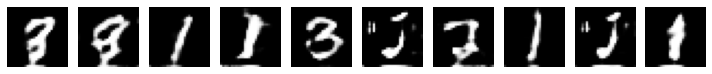

4301 [D loss: 0.169539, acc.: 93.75%] [G loss: 1.131223]
4302 [D loss: 0.144043, acc.: 95.31%] [G loss: 1.233292]
4303 [D loss: 0.188946, acc.: 92.19%] [G loss: 1.293424]
4304 [D loss: 0.139748, acc.: 93.75%] [G loss: 1.405726]
4305 [D loss: 0.126453, acc.: 95.31%] [G loss: 1.371891]
4306 [D loss: 0.145765, acc.: 91.41%] [G loss: 1.304422]
4307 [D loss: 0.235264, acc.: 92.97%] [G loss: 1.199001]
4308 [D loss: 0.150582, acc.: 92.97%] [G loss: 1.504574]
4309 [D loss: 0.245474, acc.: 92.19%] [G loss: 1.386544]
4310 [D loss: 0.133771, acc.: 95.31%] [G loss: 1.225456]
4311 [D loss: 0.165530, acc.: 92.19%] [G loss: 0.950521]
4312 [D loss: 0.089803, acc.: 96.88%] [G loss: 1.036010]
4313 [D loss: 0.216503, acc.: 88.28%] [G loss: 1.335428]
4314 [D loss: 0.085781, acc.: 97.66%] [G loss: 1.816452]
4315 [D loss: 0.123562, acc.: 94.53%] [G loss: 2.153545]
4316 [D loss: 0.174912, acc.: 94.53%] [G loss: 2.359501]
4317 [D loss: 0.211777, acc.: 92.19%] [G loss: 1.556449]
4318 [D loss: 0.118012, acc.: 9

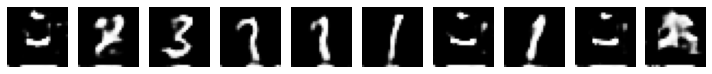

4401 [D loss: 0.261974, acc.: 87.50%] [G loss: 5.038950]
4402 [D loss: 0.156847, acc.: 92.19%] [G loss: 4.259909]
4403 [D loss: 0.163007, acc.: 92.97%] [G loss: 3.759146]
4404 [D loss: 0.110718, acc.: 96.88%] [G loss: 3.844045]
4405 [D loss: 0.252656, acc.: 90.62%] [G loss: 3.615893]
4406 [D loss: 0.132823, acc.: 96.88%] [G loss: 4.094707]
4407 [D loss: 0.164897, acc.: 92.97%] [G loss: 4.471212]
4408 [D loss: 0.068369, acc.: 96.88%] [G loss: 4.259224]
4409 [D loss: 0.157290, acc.: 92.97%] [G loss: 3.623915]
4410 [D loss: 0.128017, acc.: 94.53%] [G loss: 2.707952]
4411 [D loss: 0.143641, acc.: 94.53%] [G loss: 2.968222]
4412 [D loss: 0.175198, acc.: 89.06%] [G loss: 3.566176]
4413 [D loss: 0.184854, acc.: 91.41%] [G loss: 4.883634]
4414 [D loss: 0.171792, acc.: 92.19%] [G loss: 4.968421]
4415 [D loss: 0.144277, acc.: 95.31%] [G loss: 4.124153]
4416 [D loss: 0.257580, acc.: 89.84%] [G loss: 2.851027]
4417 [D loss: 0.216128, acc.: 89.84%] [G loss: 3.101948]
4418 [D loss: 0.210949, acc.: 8

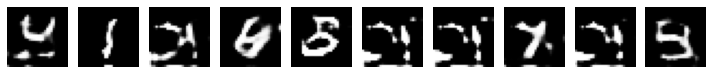

4501 [D loss: 0.210495, acc.: 92.19%] [G loss: 3.411480]
4502 [D loss: 0.174547, acc.: 93.75%] [G loss: 2.739211]
4503 [D loss: 0.122259, acc.: 94.53%] [G loss: 2.183213]
4504 [D loss: 0.218984, acc.: 88.28%] [G loss: 1.607102]
4505 [D loss: 0.154084, acc.: 96.09%] [G loss: 1.677945]
4506 [D loss: 0.183382, acc.: 93.75%] [G loss: 2.251535]
4507 [D loss: 0.168889, acc.: 92.97%] [G loss: 2.668150]
4508 [D loss: 0.142003, acc.: 95.31%] [G loss: 2.508837]
4509 [D loss: 0.247786, acc.: 88.28%] [G loss: 2.066239]
4510 [D loss: 0.187825, acc.: 92.19%] [G loss: 2.095933]
4511 [D loss: 0.259533, acc.: 87.50%] [G loss: 1.878083]
4512 [D loss: 0.227171, acc.: 91.41%] [G loss: 1.879287]
4513 [D loss: 0.204667, acc.: 92.19%] [G loss: 1.623610]
4514 [D loss: 0.184817, acc.: 92.97%] [G loss: 1.663836]
4515 [D loss: 0.145361, acc.: 93.75%] [G loss: 2.236799]
4516 [D loss: 0.345811, acc.: 87.50%] [G loss: 1.576435]
4517 [D loss: 0.188821, acc.: 91.41%] [G loss: 1.549731]
4518 [D loss: 0.167341, acc.: 9

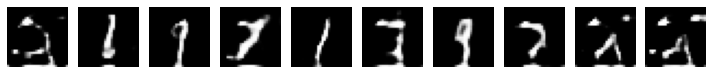

4601 [D loss: 0.111196, acc.: 96.88%] [G loss: 3.055914]
4602 [D loss: 0.153778, acc.: 93.75%] [G loss: 2.478689]
4603 [D loss: 0.212490, acc.: 89.84%] [G loss: 3.118048]
4604 [D loss: 0.209722, acc.: 92.19%] [G loss: 4.129129]
4605 [D loss: 0.273379, acc.: 90.62%] [G loss: 3.609797]
4606 [D loss: 0.161015, acc.: 94.53%] [G loss: 3.218328]
4607 [D loss: 0.282574, acc.: 86.72%] [G loss: 2.318458]
4608 [D loss: 0.214058, acc.: 90.62%] [G loss: 2.523171]
4609 [D loss: 0.180031, acc.: 92.19%] [G loss: 3.212911]
4610 [D loss: 0.159900, acc.: 93.75%] [G loss: 3.784727]
4611 [D loss: 0.188472, acc.: 92.19%] [G loss: 3.574461]
4612 [D loss: 0.272425, acc.: 89.84%] [G loss: 2.788270]
4613 [D loss: 0.286574, acc.: 85.94%] [G loss: 2.615160]
4614 [D loss: 0.235376, acc.: 89.84%] [G loss: 3.098935]
4615 [D loss: 0.233164, acc.: 89.84%] [G loss: 3.590916]
4616 [D loss: 0.207206, acc.: 92.19%] [G loss: 4.412147]
4617 [D loss: 0.146341, acc.: 92.97%] [G loss: 4.635350]
4618 [D loss: 0.252121, acc.: 8

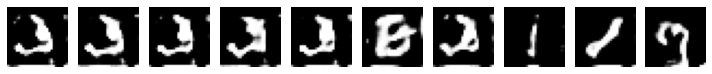

4701 [D loss: 0.155547, acc.: 92.19%] [G loss: 3.501900]
4702 [D loss: 0.250931, acc.: 86.72%] [G loss: 3.647554]
4703 [D loss: 0.116002, acc.: 95.31%] [G loss: 3.646584]
4704 [D loss: 0.263610, acc.: 87.50%] [G loss: 3.851179]
4705 [D loss: 0.210993, acc.: 92.19%] [G loss: 3.378757]
4706 [D loss: 0.255626, acc.: 88.28%] [G loss: 2.921496]
4707 [D loss: 0.208857, acc.: 90.62%] [G loss: 3.079807]
4708 [D loss: 0.274609, acc.: 85.94%] [G loss: 2.632160]
4709 [D loss: 0.364652, acc.: 83.59%] [G loss: 2.604551]
4710 [D loss: 0.280005, acc.: 87.50%] [G loss: 2.728006]
4711 [D loss: 0.188368, acc.: 92.19%] [G loss: 2.891340]
4712 [D loss: 0.199182, acc.: 92.19%] [G loss: 3.207850]
4713 [D loss: 0.165189, acc.: 91.41%] [G loss: 3.626230]
4714 [D loss: 0.191055, acc.: 92.97%] [G loss: 3.501857]
4715 [D loss: 0.201605, acc.: 91.41%] [G loss: 3.353524]
4716 [D loss: 0.183867, acc.: 92.97%] [G loss: 3.020557]
4717 [D loss: 0.253618, acc.: 88.28%] [G loss: 2.613905]
4718 [D loss: 0.235129, acc.: 9

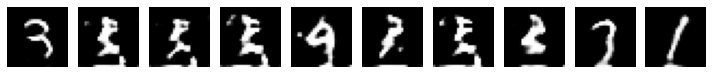

4801 [D loss: 0.184632, acc.: 93.75%] [G loss: 3.180717]
4802 [D loss: 0.236992, acc.: 85.94%] [G loss: 3.025362]
4803 [D loss: 0.219314, acc.: 89.84%] [G loss: 3.300323]
4804 [D loss: 0.181003, acc.: 92.19%] [G loss: 3.747369]
4805 [D loss: 0.226493, acc.: 86.72%] [G loss: 3.803253]
4806 [D loss: 0.304154, acc.: 86.72%] [G loss: 3.428512]
4807 [D loss: 0.219041, acc.: 86.72%] [G loss: 2.786247]
4808 [D loss: 0.234499, acc.: 87.50%] [G loss: 2.611592]
4809 [D loss: 0.174994, acc.: 91.41%] [G loss: 2.403036]
4810 [D loss: 0.169126, acc.: 94.53%] [G loss: 2.465351]
4811 [D loss: 0.200417, acc.: 89.84%] [G loss: 2.500905]
4812 [D loss: 0.164262, acc.: 92.19%] [G loss: 2.268051]
4813 [D loss: 0.337987, acc.: 89.06%] [G loss: 3.106569]
4814 [D loss: 0.242441, acc.: 89.84%] [G loss: 3.305697]
4815 [D loss: 0.344990, acc.: 85.94%] [G loss: 2.686918]
4816 [D loss: 0.200191, acc.: 90.62%] [G loss: 2.263184]
4817 [D loss: 0.174076, acc.: 93.75%] [G loss: 1.944038]
4818 [D loss: 0.205597, acc.: 9

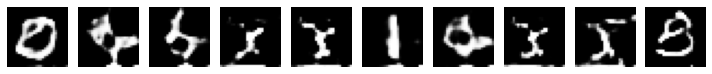

4901 [D loss: 0.334920, acc.: 83.59%] [G loss: 2.543601]
4902 [D loss: 0.246657, acc.: 89.06%] [G loss: 2.567498]
4903 [D loss: 0.249129, acc.: 90.62%] [G loss: 2.667878]
4904 [D loss: 0.187949, acc.: 92.97%] [G loss: 2.623679]
4905 [D loss: 0.211530, acc.: 89.84%] [G loss: 2.532537]
4906 [D loss: 0.224812, acc.: 87.50%] [G loss: 2.206320]
4907 [D loss: 0.192256, acc.: 90.62%] [G loss: 2.158316]
4908 [D loss: 0.165251, acc.: 91.41%] [G loss: 2.316994]
4909 [D loss: 0.262706, acc.: 87.50%] [G loss: 2.100646]
4910 [D loss: 0.255362, acc.: 87.50%] [G loss: 2.024863]
4911 [D loss: 0.318094, acc.: 88.28%] [G loss: 1.722447]
4912 [D loss: 0.257520, acc.: 89.06%] [G loss: 1.838956]
4913 [D loss: 0.274802, acc.: 84.38%] [G loss: 1.986606]
4914 [D loss: 0.350179, acc.: 82.81%] [G loss: 2.157071]
4915 [D loss: 0.244692, acc.: 89.84%] [G loss: 2.037741]
4916 [D loss: 0.275467, acc.: 87.50%] [G loss: 2.035846]
4917 [D loss: 0.227448, acc.: 91.41%] [G loss: 2.144133]
4918 [D loss: 0.251492, acc.: 8

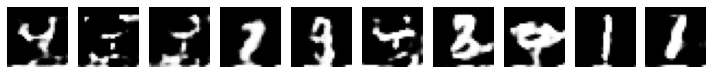

5001 [D loss: 0.153022, acc.: 94.53%] [G loss: 4.555175]
5002 [D loss: 0.183220, acc.: 94.53%] [G loss: 4.588714]
5003 [D loss: 0.175002, acc.: 92.97%] [G loss: 4.101894]
5004 [D loss: 0.106799, acc.: 96.09%] [G loss: 4.630214]
5005 [D loss: 0.181571, acc.: 95.31%] [G loss: 4.922294]
5006 [D loss: 0.221921, acc.: 88.28%] [G loss: 5.406645]
5007 [D loss: 0.214646, acc.: 91.41%] [G loss: 6.113899]
5008 [D loss: 0.438165, acc.: 85.16%] [G loss: 6.234484]
5009 [D loss: 0.197519, acc.: 92.97%] [G loss: 6.227301]
5010 [D loss: 0.226547, acc.: 88.28%] [G loss: 6.098282]
5011 [D loss: 0.207773, acc.: 90.62%] [G loss: 5.514930]
5012 [D loss: 0.315295, acc.: 86.72%] [G loss: 4.515352]
5013 [D loss: 0.278812, acc.: 88.28%] [G loss: 4.169198]
5014 [D loss: 0.287775, acc.: 88.28%] [G loss: 3.475165]
5015 [D loss: 0.194713, acc.: 92.19%] [G loss: 3.945921]
5016 [D loss: 0.129351, acc.: 94.53%] [G loss: 5.547736]
5017 [D loss: 0.229920, acc.: 89.84%] [G loss: 6.444098]
5018 [D loss: 0.125920, acc.: 9

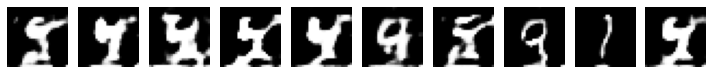

5101 [D loss: 0.265776, acc.: 87.50%] [G loss: 2.672644]
5102 [D loss: 0.266257, acc.: 90.62%] [G loss: 2.746655]
5103 [D loss: 0.211525, acc.: 90.62%] [G loss: 2.665347]
5104 [D loss: 0.207388, acc.: 89.06%] [G loss: 2.565493]
5105 [D loss: 0.293619, acc.: 84.38%] [G loss: 2.407491]
5106 [D loss: 0.280020, acc.: 89.06%] [G loss: 2.345142]
5107 [D loss: 0.235146, acc.: 89.84%] [G loss: 2.628449]
5108 [D loss: 0.118182, acc.: 96.09%] [G loss: 3.005166]
5109 [D loss: 0.159215, acc.: 93.75%] [G loss: 2.514380]
5110 [D loss: 0.314482, acc.: 82.81%] [G loss: 2.209032]
5111 [D loss: 0.217822, acc.: 87.50%] [G loss: 2.377563]
5112 [D loss: 0.240563, acc.: 89.84%] [G loss: 2.684403]
5113 [D loss: 0.251483, acc.: 90.62%] [G loss: 2.944702]
5114 [D loss: 0.169880, acc.: 92.97%] [G loss: 2.993124]
5115 [D loss: 0.323208, acc.: 90.62%] [G loss: 2.676938]
5116 [D loss: 0.117529, acc.: 94.53%] [G loss: 2.397310]
5117 [D loss: 0.256775, acc.: 91.41%] [G loss: 2.216404]
5118 [D loss: 0.237905, acc.: 8

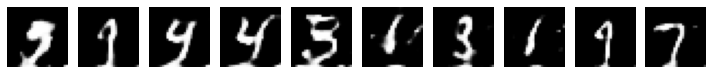

5201 [D loss: 0.360859, acc.: 85.16%] [G loss: 2.467685]
5202 [D loss: 0.350294, acc.: 84.38%] [G loss: 2.247811]
5203 [D loss: 0.266331, acc.: 88.28%] [G loss: 2.598030]
5204 [D loss: 0.196416, acc.: 91.41%] [G loss: 2.639756]
5205 [D loss: 0.243064, acc.: 86.72%] [G loss: 2.662518]
5206 [D loss: 0.273224, acc.: 89.84%] [G loss: 2.220293]
5207 [D loss: 0.213569, acc.: 90.62%] [G loss: 2.382094]
5208 [D loss: 0.217662, acc.: 91.41%] [G loss: 2.318220]
5209 [D loss: 0.188763, acc.: 92.19%] [G loss: 2.211637]
5210 [D loss: 0.259844, acc.: 88.28%] [G loss: 2.350082]
5211 [D loss: 0.266392, acc.: 89.06%] [G loss: 2.189296]
5212 [D loss: 0.314364, acc.: 86.72%] [G loss: 2.191458]
5213 [D loss: 0.191822, acc.: 93.75%] [G loss: 2.303663]
5214 [D loss: 0.394670, acc.: 81.25%] [G loss: 2.565308]
5215 [D loss: 0.286973, acc.: 85.16%] [G loss: 2.904139]
5216 [D loss: 0.343720, acc.: 83.59%] [G loss: 2.326046]
5217 [D loss: 0.323644, acc.: 80.47%] [G loss: 2.265776]
5218 [D loss: 0.296873, acc.: 8

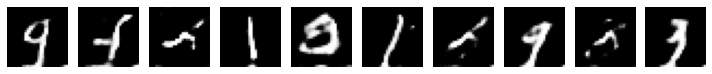

5301 [D loss: 0.217209, acc.: 90.62%] [G loss: 2.828584]
5302 [D loss: 0.296147, acc.: 84.38%] [G loss: 2.752350]
5303 [D loss: 0.216834, acc.: 88.28%] [G loss: 3.326477]
5304 [D loss: 0.262890, acc.: 84.38%] [G loss: 3.499962]
5305 [D loss: 0.181970, acc.: 93.75%] [G loss: 3.491449]
5306 [D loss: 0.250568, acc.: 88.28%] [G loss: 3.212703]
5307 [D loss: 0.226015, acc.: 88.28%] [G loss: 3.013991]
5308 [D loss: 0.242085, acc.: 90.62%] [G loss: 2.622216]
5309 [D loss: 0.217273, acc.: 90.62%] [G loss: 2.463170]
5310 [D loss: 0.279301, acc.: 85.94%] [G loss: 2.732952]
5311 [D loss: 0.186848, acc.: 94.53%] [G loss: 2.927773]
5312 [D loss: 0.253631, acc.: 89.06%] [G loss: 3.137983]
5313 [D loss: 0.253441, acc.: 89.84%] [G loss: 2.649900]
5314 [D loss: 0.209942, acc.: 90.62%] [G loss: 2.518609]
5315 [D loss: 0.381661, acc.: 80.47%] [G loss: 2.033659]
5316 [D loss: 0.288470, acc.: 88.28%] [G loss: 2.420781]
5317 [D loss: 0.277971, acc.: 91.41%] [G loss: 2.424759]
5318 [D loss: 0.234386, acc.: 8

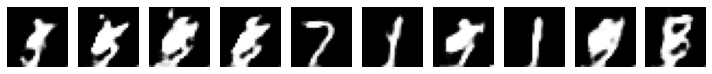

5401 [D loss: 0.325385, acc.: 86.72%] [G loss: 2.548636]
5402 [D loss: 0.271468, acc.: 87.50%] [G loss: 3.221344]
5403 [D loss: 0.314711, acc.: 84.38%] [G loss: 3.379938]
5404 [D loss: 0.272235, acc.: 89.84%] [G loss: 2.830621]
5405 [D loss: 0.195389, acc.: 91.41%] [G loss: 2.802977]
5406 [D loss: 0.352810, acc.: 82.03%] [G loss: 2.489944]
5407 [D loss: 0.295764, acc.: 88.28%] [G loss: 2.374461]
5408 [D loss: 0.271061, acc.: 82.81%] [G loss: 2.538289]
5409 [D loss: 0.210570, acc.: 90.62%] [G loss: 2.783834]
5410 [D loss: 0.205881, acc.: 92.19%] [G loss: 3.827545]
5411 [D loss: 0.212869, acc.: 94.53%] [G loss: 3.720934]
5412 [D loss: 0.282529, acc.: 86.72%] [G loss: 2.886488]
5413 [D loss: 0.201968, acc.: 92.19%] [G loss: 2.112174]
5414 [D loss: 0.234049, acc.: 90.62%] [G loss: 1.667340]
5415 [D loss: 0.315355, acc.: 85.16%] [G loss: 1.888535]
5416 [D loss: 0.229347, acc.: 89.84%] [G loss: 2.107973]
5417 [D loss: 0.208037, acc.: 91.41%] [G loss: 2.835834]
5418 [D loss: 0.305632, acc.: 8

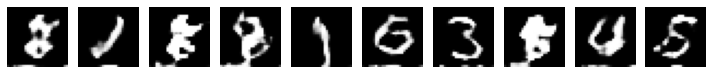

5501 [D loss: 0.225177, acc.: 89.84%] [G loss: 2.029418]
5502 [D loss: 0.309217, acc.: 85.94%] [G loss: 1.911674]
5503 [D loss: 0.294969, acc.: 85.16%] [G loss: 1.774495]
5504 [D loss: 0.213074, acc.: 90.62%] [G loss: 1.766033]
5505 [D loss: 0.216394, acc.: 90.62%] [G loss: 1.902425]
5506 [D loss: 0.199022, acc.: 90.62%] [G loss: 2.462189]
5507 [D loss: 0.295079, acc.: 88.28%] [G loss: 2.841058]
5508 [D loss: 0.237944, acc.: 89.06%] [G loss: 2.935715]
5509 [D loss: 0.269887, acc.: 85.16%] [G loss: 3.172767]
5510 [D loss: 0.242903, acc.: 91.41%] [G loss: 2.883045]
5511 [D loss: 0.202961, acc.: 90.62%] [G loss: 2.559037]
5512 [D loss: 0.244198, acc.: 89.84%] [G loss: 2.316204]
5513 [D loss: 0.225539, acc.: 88.28%] [G loss: 2.149169]
5514 [D loss: 0.200208, acc.: 90.62%] [G loss: 2.714417]
5515 [D loss: 0.336990, acc.: 89.06%] [G loss: 2.343857]
5516 [D loss: 0.224173, acc.: 92.97%] [G loss: 2.248509]
5517 [D loss: 0.318464, acc.: 84.38%] [G loss: 2.062027]
5518 [D loss: 0.171933, acc.: 9

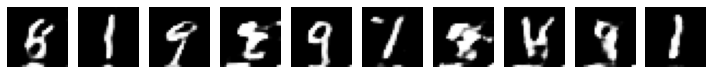

5601 [D loss: 0.393008, acc.: 82.03%] [G loss: 3.638787]
5602 [D loss: 0.223917, acc.: 91.41%] [G loss: 4.534993]
5603 [D loss: 0.382526, acc.: 82.81%] [G loss: 4.262966]
5604 [D loss: 0.306421, acc.: 85.94%] [G loss: 3.916821]
5605 [D loss: 0.323560, acc.: 87.50%] [G loss: 3.766274]
5606 [D loss: 0.275193, acc.: 86.72%] [G loss: 3.851357]
5607 [D loss: 0.387510, acc.: 83.59%] [G loss: 3.776842]
5608 [D loss: 0.316886, acc.: 84.38%] [G loss: 3.784659]
5609 [D loss: 0.405555, acc.: 81.25%] [G loss: 4.102609]
5610 [D loss: 0.377520, acc.: 83.59%] [G loss: 3.728211]
5611 [D loss: 0.265059, acc.: 87.50%] [G loss: 3.568446]
5612 [D loss: 0.357356, acc.: 85.94%] [G loss: 3.756615]
5613 [D loss: 0.396958, acc.: 85.16%] [G loss: 3.473225]
5614 [D loss: 0.274197, acc.: 89.06%] [G loss: 3.733681]
5615 [D loss: 0.188262, acc.: 93.75%] [G loss: 3.405436]
5616 [D loss: 0.317365, acc.: 84.38%] [G loss: 3.433340]
5617 [D loss: 0.270767, acc.: 85.16%] [G loss: 4.089538]
5618 [D loss: 0.185582, acc.: 9

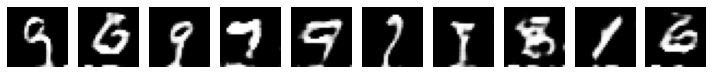

5701 [D loss: 0.192431, acc.: 92.19%] [G loss: 3.604059]
5702 [D loss: 0.259579, acc.: 89.06%] [G loss: 3.365871]
5703 [D loss: 0.198802, acc.: 92.19%] [G loss: 3.486066]
5704 [D loss: 0.246990, acc.: 89.06%] [G loss: 3.907118]
5705 [D loss: 0.250324, acc.: 86.72%] [G loss: 4.042510]
5706 [D loss: 0.246452, acc.: 92.19%] [G loss: 3.783884]
5707 [D loss: 0.203517, acc.: 91.41%] [G loss: 3.785275]
5708 [D loss: 0.248694, acc.: 87.50%] [G loss: 3.121888]
5709 [D loss: 0.251527, acc.: 89.06%] [G loss: 2.882543]
5710 [D loss: 0.210612, acc.: 89.84%] [G loss: 3.096029]
5711 [D loss: 0.243498, acc.: 85.94%] [G loss: 3.074709]
5712 [D loss: 0.247390, acc.: 89.06%] [G loss: 3.773473]
5713 [D loss: 0.213153, acc.: 88.28%] [G loss: 3.329175]
5714 [D loss: 0.330228, acc.: 85.94%] [G loss: 2.705216]
5715 [D loss: 0.259407, acc.: 87.50%] [G loss: 1.980488]
5716 [D loss: 0.360212, acc.: 84.38%] [G loss: 2.156682]
5717 [D loss: 0.267361, acc.: 88.28%] [G loss: 2.607822]
5718 [D loss: 0.326402, acc.: 8

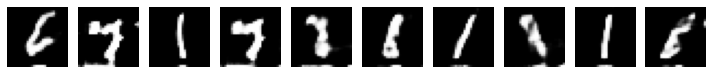

5801 [D loss: 0.273723, acc.: 89.84%] [G loss: 2.543115]
5802 [D loss: 0.375524, acc.: 89.06%] [G loss: 2.711461]
5803 [D loss: 0.561404, acc.: 75.78%] [G loss: 2.485935]
5804 [D loss: 0.405324, acc.: 80.47%] [G loss: 2.112185]
5805 [D loss: 0.242634, acc.: 89.06%] [G loss: 2.518729]
5806 [D loss: 0.330881, acc.: 87.50%] [G loss: 2.452785]
5807 [D loss: 0.270058, acc.: 88.28%] [G loss: 2.549099]
5808 [D loss: 0.460298, acc.: 74.22%] [G loss: 2.141167]
5809 [D loss: 0.361937, acc.: 85.16%] [G loss: 1.895463]
5810 [D loss: 0.341645, acc.: 82.81%] [G loss: 1.944406]
5811 [D loss: 0.407750, acc.: 80.47%] [G loss: 2.086744]
5812 [D loss: 0.410919, acc.: 79.69%] [G loss: 2.037000]
5813 [D loss: 0.320787, acc.: 86.72%] [G loss: 2.225714]
5814 [D loss: 0.306506, acc.: 89.06%] [G loss: 2.278943]
5815 [D loss: 0.249553, acc.: 89.06%] [G loss: 2.508697]
5816 [D loss: 0.433153, acc.: 78.12%] [G loss: 2.370362]
5817 [D loss: 0.438597, acc.: 80.47%] [G loss: 1.903130]
5818 [D loss: 0.267446, acc.: 8

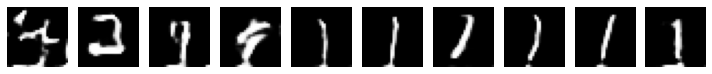

5901 [D loss: 0.276239, acc.: 88.28%] [G loss: 2.944335]
5902 [D loss: 0.381691, acc.: 82.81%] [G loss: 2.766019]
5903 [D loss: 0.299736, acc.: 90.62%] [G loss: 2.363063]
5904 [D loss: 0.341841, acc.: 85.16%] [G loss: 2.132113]
5905 [D loss: 0.252644, acc.: 90.62%] [G loss: 2.694554]
5906 [D loss: 0.248621, acc.: 89.84%] [G loss: 2.872339]
5907 [D loss: 0.251621, acc.: 86.72%] [G loss: 3.052577]
5908 [D loss: 0.511748, acc.: 78.91%] [G loss: 2.443131]
5909 [D loss: 0.414101, acc.: 81.25%] [G loss: 2.101618]
5910 [D loss: 0.460949, acc.: 77.34%] [G loss: 2.195698]
5911 [D loss: 0.324004, acc.: 85.16%] [G loss: 2.888798]
5912 [D loss: 0.401375, acc.: 80.47%] [G loss: 2.740947]
5913 [D loss: 0.288675, acc.: 84.38%] [G loss: 2.673938]
5914 [D loss: 0.317875, acc.: 84.38%] [G loss: 2.483152]
5915 [D loss: 0.403288, acc.: 82.81%] [G loss: 2.479092]
5916 [D loss: 0.332894, acc.: 87.50%] [G loss: 2.536806]
5917 [D loss: 0.256533, acc.: 90.62%] [G loss: 2.742910]
5918 [D loss: 0.410928, acc.: 8

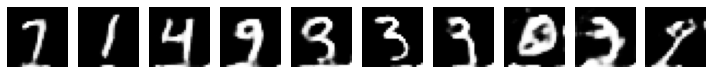

6001 [D loss: 0.303524, acc.: 84.38%] [G loss: 2.606167]
6002 [D loss: 0.244462, acc.: 88.28%] [G loss: 2.563254]
6003 [D loss: 0.236958, acc.: 91.41%] [G loss: 2.635054]
6004 [D loss: 0.357572, acc.: 84.38%] [G loss: 2.640942]
6005 [D loss: 0.331758, acc.: 85.16%] [G loss: 2.735223]
6006 [D loss: 0.287625, acc.: 87.50%] [G loss: 2.735718]
6007 [D loss: 0.512236, acc.: 78.91%] [G loss: 2.451230]
6008 [D loss: 0.513295, acc.: 71.09%] [G loss: 2.269289]
6009 [D loss: 0.387046, acc.: 81.25%] [G loss: 2.533849]
6010 [D loss: 0.314893, acc.: 88.28%] [G loss: 2.806778]
6011 [D loss: 0.422294, acc.: 82.03%] [G loss: 2.861630]
6012 [D loss: 0.322736, acc.: 85.16%] [G loss: 2.704728]
6013 [D loss: 0.438282, acc.: 80.47%] [G loss: 1.958309]
6014 [D loss: 0.419610, acc.: 78.12%] [G loss: 1.827107]
6015 [D loss: 0.343224, acc.: 81.25%] [G loss: 1.679586]
6016 [D loss: 0.316018, acc.: 85.94%] [G loss: 2.254691]
6017 [D loss: 0.331271, acc.: 84.38%] [G loss: 2.693698]
6018 [D loss: 0.424331, acc.: 8

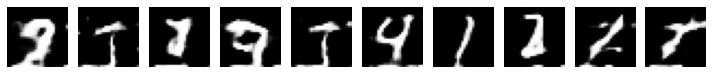

6101 [D loss: 0.623833, acc.: 72.66%] [G loss: 1.552595]
6102 [D loss: 0.618258, acc.: 74.22%] [G loss: 1.612711]
6103 [D loss: 0.471871, acc.: 78.12%] [G loss: 1.770779]
6104 [D loss: 0.358093, acc.: 83.59%] [G loss: 2.233818]
6105 [D loss: 0.362054, acc.: 82.81%] [G loss: 2.524350]
6106 [D loss: 0.543009, acc.: 72.66%] [G loss: 2.194695]
6107 [D loss: 0.457863, acc.: 78.12%] [G loss: 2.071915]
6108 [D loss: 0.486014, acc.: 76.56%] [G loss: 1.780180]
6109 [D loss: 0.458152, acc.: 79.69%] [G loss: 1.645630]
6110 [D loss: 0.393577, acc.: 82.81%] [G loss: 1.913437]
6111 [D loss: 0.355937, acc.: 83.59%] [G loss: 1.826496]
6112 [D loss: 0.496896, acc.: 77.34%] [G loss: 1.761078]
6113 [D loss: 0.344503, acc.: 82.03%] [G loss: 1.931007]
6114 [D loss: 0.402043, acc.: 83.59%] [G loss: 1.888706]
6115 [D loss: 0.351601, acc.: 84.38%] [G loss: 2.112089]
6116 [D loss: 0.337938, acc.: 85.16%] [G loss: 1.802916]
6117 [D loss: 0.415889, acc.: 78.91%] [G loss: 1.939960]
6118 [D loss: 0.359270, acc.: 8

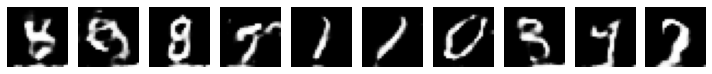

6201 [D loss: 0.374891, acc.: 85.16%] [G loss: 2.079793]
6202 [D loss: 0.369381, acc.: 84.38%] [G loss: 1.804124]
6203 [D loss: 0.524550, acc.: 73.44%] [G loss: 1.718255]
6204 [D loss: 0.330937, acc.: 85.94%] [G loss: 1.984904]
6205 [D loss: 0.300005, acc.: 87.50%] [G loss: 2.041943]
6206 [D loss: 0.316888, acc.: 87.50%] [G loss: 2.515996]
6207 [D loss: 0.360568, acc.: 81.25%] [G loss: 2.427613]
6208 [D loss: 0.387854, acc.: 78.91%] [G loss: 2.210537]
6209 [D loss: 0.376552, acc.: 79.69%] [G loss: 2.106279]
6210 [D loss: 0.290825, acc.: 85.16%] [G loss: 1.959357]
6211 [D loss: 0.328192, acc.: 85.94%] [G loss: 1.855411]
6212 [D loss: 0.322005, acc.: 85.94%] [G loss: 2.025389]
6213 [D loss: 0.349467, acc.: 84.38%] [G loss: 2.050350]
6214 [D loss: 0.324847, acc.: 82.03%] [G loss: 2.532187]
6215 [D loss: 0.312403, acc.: 87.50%] [G loss: 2.344822]
6216 [D loss: 0.405790, acc.: 81.25%] [G loss: 2.327135]
6217 [D loss: 0.311288, acc.: 88.28%] [G loss: 1.945427]
6218 [D loss: 0.266387, acc.: 8

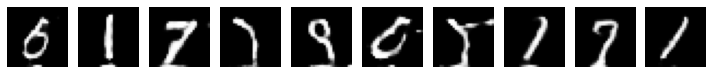

6301 [D loss: 0.406679, acc.: 83.59%] [G loss: 2.047689]
6302 [D loss: 0.344192, acc.: 85.94%] [G loss: 2.039064]
6303 [D loss: 0.392428, acc.: 79.69%] [G loss: 2.008742]
6304 [D loss: 0.388767, acc.: 79.69%] [G loss: 2.079601]
6305 [D loss: 0.387518, acc.: 82.03%] [G loss: 1.973576]
6306 [D loss: 0.427743, acc.: 78.12%] [G loss: 1.798987]
6307 [D loss: 0.389833, acc.: 83.59%] [G loss: 1.673198]
6308 [D loss: 0.445720, acc.: 80.47%] [G loss: 1.606532]
6309 [D loss: 0.322647, acc.: 85.94%] [G loss: 1.992199]
6310 [D loss: 0.369548, acc.: 82.03%] [G loss: 2.317251]
6311 [D loss: 0.368110, acc.: 83.59%] [G loss: 2.313744]
6312 [D loss: 0.551994, acc.: 71.88%] [G loss: 1.954394]
6313 [D loss: 0.441382, acc.: 82.03%] [G loss: 1.976433]
6314 [D loss: 0.301168, acc.: 86.72%] [G loss: 1.958729]
6315 [D loss: 0.390479, acc.: 81.25%] [G loss: 2.256548]
6316 [D loss: 0.420925, acc.: 79.69%] [G loss: 2.146902]
6317 [D loss: 0.489740, acc.: 74.22%] [G loss: 2.170885]
6318 [D loss: 0.405068, acc.: 8

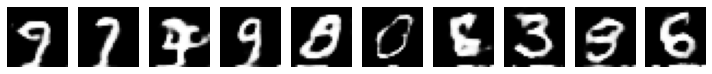

6401 [D loss: 0.343222, acc.: 85.94%] [G loss: 2.047909]
6402 [D loss: 0.353146, acc.: 86.72%] [G loss: 2.088449]
6403 [D loss: 0.490466, acc.: 76.56%] [G loss: 2.033505]
6404 [D loss: 0.468049, acc.: 81.25%] [G loss: 1.776640]
6405 [D loss: 0.409345, acc.: 83.59%] [G loss: 1.671403]
6406 [D loss: 0.395509, acc.: 78.91%] [G loss: 1.932373]
6407 [D loss: 0.375674, acc.: 81.25%] [G loss: 2.175390]
6408 [D loss: 0.280800, acc.: 87.50%] [G loss: 2.156721]
6409 [D loss: 0.333912, acc.: 83.59%] [G loss: 2.280503]
6410 [D loss: 0.459234, acc.: 82.81%] [G loss: 2.244073]
6411 [D loss: 0.380158, acc.: 82.81%] [G loss: 2.117040]
6412 [D loss: 0.341282, acc.: 84.38%] [G loss: 2.227671]
6413 [D loss: 0.378035, acc.: 82.81%] [G loss: 2.082873]
6414 [D loss: 0.510240, acc.: 74.22%] [G loss: 1.906413]
6415 [D loss: 0.393764, acc.: 81.25%] [G loss: 1.759012]
6416 [D loss: 0.365880, acc.: 84.38%] [G loss: 2.107146]
6417 [D loss: 0.361025, acc.: 84.38%] [G loss: 2.210035]
6418 [D loss: 0.365294, acc.: 8

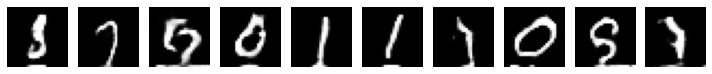

6501 [D loss: 0.404425, acc.: 78.12%] [G loss: 2.300924]
6502 [D loss: 0.355043, acc.: 86.72%] [G loss: 2.449825]
6503 [D loss: 0.393988, acc.: 78.91%] [G loss: 2.146180]
6504 [D loss: 0.413467, acc.: 80.47%] [G loss: 2.052662]
6505 [D loss: 0.353258, acc.: 85.16%] [G loss: 1.971092]
6506 [D loss: 0.550834, acc.: 74.22%] [G loss: 1.702251]
6507 [D loss: 0.377107, acc.: 81.25%] [G loss: 1.997987]
6508 [D loss: 0.435219, acc.: 78.12%] [G loss: 1.995065]
6509 [D loss: 0.423337, acc.: 80.47%] [G loss: 1.954546]
6510 [D loss: 0.374914, acc.: 82.81%] [G loss: 1.957571]
6511 [D loss: 0.428858, acc.: 81.25%] [G loss: 1.645506]
6512 [D loss: 0.520554, acc.: 73.44%] [G loss: 1.833321]
6513 [D loss: 0.439296, acc.: 78.91%] [G loss: 1.851853]
6514 [D loss: 0.498963, acc.: 74.22%] [G loss: 1.745873]
6515 [D loss: 0.544678, acc.: 74.22%] [G loss: 1.508334]
6516 [D loss: 0.418463, acc.: 78.91%] [G loss: 1.770173]
6517 [D loss: 0.454953, acc.: 75.00%] [G loss: 1.858117]
6518 [D loss: 0.371057, acc.: 8

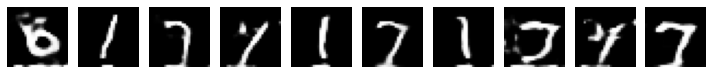

6601 [D loss: 0.420563, acc.: 81.25%] [G loss: 1.802955]
6602 [D loss: 0.395996, acc.: 82.81%] [G loss: 1.661960]
6603 [D loss: 0.424276, acc.: 80.47%] [G loss: 1.668987]
6604 [D loss: 0.444281, acc.: 81.25%] [G loss: 1.631819]
6605 [D loss: 0.370796, acc.: 85.94%] [G loss: 1.943864]
6606 [D loss: 0.444184, acc.: 78.91%] [G loss: 2.068467]
6607 [D loss: 0.464442, acc.: 78.12%] [G loss: 1.916264]
6608 [D loss: 0.504836, acc.: 74.22%] [G loss: 1.705444]
6609 [D loss: 0.440455, acc.: 74.22%] [G loss: 1.624125]
6610 [D loss: 0.310628, acc.: 88.28%] [G loss: 1.924380]
6611 [D loss: 0.358559, acc.: 83.59%] [G loss: 2.013413]
6612 [D loss: 0.373594, acc.: 84.38%] [G loss: 2.084547]
6613 [D loss: 0.406310, acc.: 82.03%] [G loss: 1.744982]
6614 [D loss: 0.469733, acc.: 80.47%] [G loss: 1.816374]
6615 [D loss: 0.367448, acc.: 84.38%] [G loss: 1.730826]
6616 [D loss: 0.340157, acc.: 87.50%] [G loss: 2.043012]
6617 [D loss: 0.459125, acc.: 77.34%] [G loss: 1.914239]
6618 [D loss: 0.352413, acc.: 8

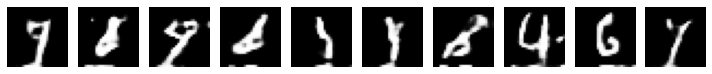

6701 [D loss: 0.371527, acc.: 83.59%] [G loss: 1.439687]
6702 [D loss: 0.358063, acc.: 81.25%] [G loss: 1.695473]
6703 [D loss: 0.337479, acc.: 85.16%] [G loss: 1.946553]
6704 [D loss: 0.404454, acc.: 81.25%] [G loss: 2.136928]
6705 [D loss: 0.360332, acc.: 82.81%] [G loss: 1.833932]
6706 [D loss: 0.357275, acc.: 82.81%] [G loss: 1.927646]
6707 [D loss: 0.365866, acc.: 83.59%] [G loss: 1.991548]
6708 [D loss: 0.441434, acc.: 83.59%] [G loss: 1.911983]
6709 [D loss: 0.442634, acc.: 78.91%] [G loss: 1.901741]
6710 [D loss: 0.372308, acc.: 82.03%] [G loss: 2.102889]
6711 [D loss: 0.417803, acc.: 78.12%] [G loss: 1.897132]
6712 [D loss: 0.436692, acc.: 81.25%] [G loss: 1.851338]
6713 [D loss: 0.427852, acc.: 78.12%] [G loss: 1.820822]
6714 [D loss: 0.387618, acc.: 84.38%] [G loss: 1.894392]
6715 [D loss: 0.348969, acc.: 83.59%] [G loss: 2.339549]
6716 [D loss: 0.401658, acc.: 83.59%] [G loss: 2.461518]
6717 [D loss: 0.458143, acc.: 79.69%] [G loss: 2.355186]
6718 [D loss: 0.411829, acc.: 8

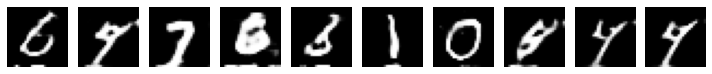

6801 [D loss: 0.493072, acc.: 75.00%] [G loss: 1.520973]
6802 [D loss: 0.315254, acc.: 90.62%] [G loss: 1.261535]
6803 [D loss: 0.449861, acc.: 79.69%] [G loss: 1.387079]
6804 [D loss: 0.443279, acc.: 78.91%] [G loss: 1.740231]
6805 [D loss: 0.299360, acc.: 86.72%] [G loss: 1.999705]
6806 [D loss: 0.395009, acc.: 79.69%] [G loss: 2.208772]
6807 [D loss: 0.423659, acc.: 78.91%] [G loss: 1.943317]
6808 [D loss: 0.524287, acc.: 74.22%] [G loss: 1.613267]
6809 [D loss: 0.501810, acc.: 75.00%] [G loss: 1.566513]
6810 [D loss: 0.409968, acc.: 85.16%] [G loss: 1.598919]
6811 [D loss: 0.417459, acc.: 82.03%] [G loss: 1.644594]
6812 [D loss: 0.370338, acc.: 81.25%] [G loss: 1.626737]
6813 [D loss: 0.372687, acc.: 82.81%] [G loss: 1.721685]
6814 [D loss: 0.451491, acc.: 77.34%] [G loss: 1.782764]
6815 [D loss: 0.477973, acc.: 78.91%] [G loss: 1.795192]
6816 [D loss: 0.379498, acc.: 84.38%] [G loss: 2.060457]
6817 [D loss: 0.450951, acc.: 81.25%] [G loss: 1.901717]
6818 [D loss: 0.431555, acc.: 7

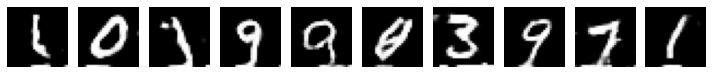

6901 [D loss: 0.572551, acc.: 71.88%] [G loss: 1.760018]
6902 [D loss: 0.427993, acc.: 77.34%] [G loss: 2.053570]
6903 [D loss: 0.470523, acc.: 82.81%] [G loss: 2.316545]
6904 [D loss: 0.475838, acc.: 71.09%] [G loss: 1.857931]
6905 [D loss: 0.416565, acc.: 81.25%] [G loss: 1.411514]
6906 [D loss: 0.548871, acc.: 73.44%] [G loss: 1.352200]
6907 [D loss: 0.507188, acc.: 76.56%] [G loss: 1.381103]
6908 [D loss: 0.429186, acc.: 79.69%] [G loss: 1.756248]
6909 [D loss: 0.357823, acc.: 85.16%] [G loss: 2.136700]
6910 [D loss: 0.487625, acc.: 74.22%] [G loss: 1.878904]
6911 [D loss: 0.368859, acc.: 89.06%] [G loss: 1.687176]
6912 [D loss: 0.485095, acc.: 79.69%] [G loss: 1.377993]
6913 [D loss: 0.447710, acc.: 78.91%] [G loss: 1.418437]
6914 [D loss: 0.379740, acc.: 85.16%] [G loss: 1.699451]
6915 [D loss: 0.345444, acc.: 86.72%] [G loss: 2.022149]
6916 [D loss: 0.358895, acc.: 82.81%] [G loss: 2.029539]
6917 [D loss: 0.339122, acc.: 86.72%] [G loss: 1.979791]
6918 [D loss: 0.419066, acc.: 8

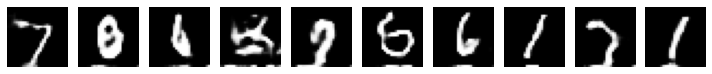

7001 [D loss: 0.414918, acc.: 79.69%] [G loss: 1.667050]
7002 [D loss: 0.347661, acc.: 87.50%] [G loss: 1.863873]
7003 [D loss: 0.361694, acc.: 85.16%] [G loss: 2.097193]
7004 [D loss: 0.440152, acc.: 76.56%] [G loss: 2.010080]
7005 [D loss: 0.373931, acc.: 85.94%] [G loss: 1.785334]
7006 [D loss: 0.426480, acc.: 81.25%] [G loss: 1.653493]
7007 [D loss: 0.417607, acc.: 80.47%] [G loss: 1.627796]
7008 [D loss: 0.269971, acc.: 87.50%] [G loss: 1.819012]
7009 [D loss: 0.369055, acc.: 83.59%] [G loss: 1.920579]
7010 [D loss: 0.315335, acc.: 87.50%] [G loss: 2.495891]
7011 [D loss: 0.404805, acc.: 83.59%] [G loss: 2.311494]
7012 [D loss: 0.376794, acc.: 79.69%] [G loss: 2.008328]
7013 [D loss: 0.474805, acc.: 75.00%] [G loss: 1.822347]
7014 [D loss: 0.369224, acc.: 82.81%] [G loss: 1.551362]
7015 [D loss: 0.363479, acc.: 81.25%] [G loss: 1.683871]
7016 [D loss: 0.464897, acc.: 77.34%] [G loss: 1.773202]
7017 [D loss: 0.415846, acc.: 79.69%] [G loss: 2.113458]
7018 [D loss: 0.261953, acc.: 8

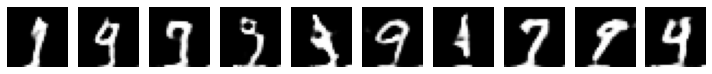

7101 [D loss: 0.310103, acc.: 86.72%] [G loss: 2.046185]
7102 [D loss: 0.324799, acc.: 83.59%] [G loss: 2.097769]
7103 [D loss: 0.330164, acc.: 85.16%] [G loss: 2.335186]
7104 [D loss: 0.312457, acc.: 86.72%] [G loss: 2.641736]
7105 [D loss: 0.288192, acc.: 85.94%] [G loss: 2.583110]
7106 [D loss: 0.323487, acc.: 85.16%] [G loss: 2.611813]
7107 [D loss: 0.407775, acc.: 82.03%] [G loss: 2.379123]
7108 [D loss: 0.369607, acc.: 85.16%] [G loss: 2.400186]
7109 [D loss: 0.337746, acc.: 85.16%] [G loss: 2.228976]
7110 [D loss: 0.399033, acc.: 80.47%] [G loss: 2.171987]
7111 [D loss: 0.399306, acc.: 81.25%] [G loss: 2.007966]
7112 [D loss: 0.351207, acc.: 81.25%] [G loss: 2.489341]
7113 [D loss: 0.346248, acc.: 82.81%] [G loss: 2.364422]
7114 [D loss: 0.414505, acc.: 73.44%] [G loss: 2.305578]
7115 [D loss: 0.441389, acc.: 81.25%] [G loss: 2.062645]
7116 [D loss: 0.515395, acc.: 71.09%] [G loss: 1.937978]
7117 [D loss: 0.431592, acc.: 80.47%] [G loss: 2.092200]
7118 [D loss: 0.542810, acc.: 7

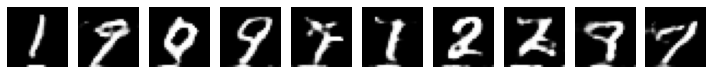

7201 [D loss: 0.427610, acc.: 78.91%] [G loss: 1.936007]
7202 [D loss: 0.502242, acc.: 75.00%] [G loss: 1.684168]
7203 [D loss: 0.386433, acc.: 82.03%] [G loss: 1.749374]
7204 [D loss: 0.586516, acc.: 73.44%] [G loss: 1.735542]
7205 [D loss: 0.447790, acc.: 79.69%] [G loss: 1.553413]
7206 [D loss: 0.435109, acc.: 80.47%] [G loss: 1.959792]
7207 [D loss: 0.524192, acc.: 69.53%] [G loss: 1.768834]
7208 [D loss: 0.540585, acc.: 71.88%] [G loss: 1.768618]
7209 [D loss: 0.455769, acc.: 77.34%] [G loss: 1.636646]
7210 [D loss: 0.382561, acc.: 85.16%] [G loss: 1.925804]
7211 [D loss: 0.367504, acc.: 85.94%] [G loss: 2.291178]
7212 [D loss: 0.480068, acc.: 74.22%] [G loss: 2.004583]
7213 [D loss: 0.502693, acc.: 78.91%] [G loss: 1.946915]
7214 [D loss: 0.637264, acc.: 68.75%] [G loss: 1.584535]
7215 [D loss: 0.401178, acc.: 79.69%] [G loss: 1.857944]
7216 [D loss: 0.398789, acc.: 80.47%] [G loss: 2.104890]
7217 [D loss: 0.488445, acc.: 78.91%] [G loss: 1.841262]
7218 [D loss: 0.476530, acc.: 8

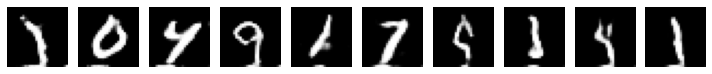

7301 [D loss: 0.365311, acc.: 82.03%] [G loss: 2.668551]
7302 [D loss: 0.323471, acc.: 83.59%] [G loss: 2.306847]
7303 [D loss: 0.391237, acc.: 79.69%] [G loss: 2.255640]
7304 [D loss: 0.408226, acc.: 84.38%] [G loss: 2.154149]
7305 [D loss: 0.404248, acc.: 79.69%] [G loss: 2.479275]
7306 [D loss: 0.364112, acc.: 84.38%] [G loss: 2.556860]
7307 [D loss: 0.257026, acc.: 89.84%] [G loss: 2.779835]
7308 [D loss: 0.406982, acc.: 83.59%] [G loss: 2.319817]
7309 [D loss: 0.441021, acc.: 78.12%] [G loss: 1.968247]
7310 [D loss: 0.442444, acc.: 79.69%] [G loss: 1.610405]
7311 [D loss: 0.375425, acc.: 85.16%] [G loss: 1.740245]
7312 [D loss: 0.362336, acc.: 85.16%] [G loss: 2.121357]
7313 [D loss: 0.384134, acc.: 81.25%] [G loss: 2.130222]
7314 [D loss: 0.584168, acc.: 77.34%] [G loss: 1.894376]
7315 [D loss: 0.359899, acc.: 83.59%] [G loss: 1.624902]
7316 [D loss: 0.467263, acc.: 79.69%] [G loss: 1.757224]
7317 [D loss: 0.475074, acc.: 75.78%] [G loss: 1.698097]
7318 [D loss: 0.476131, acc.: 7

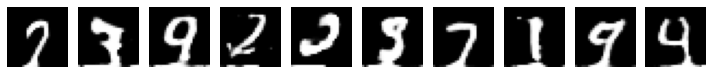

7401 [D loss: 0.412454, acc.: 80.47%] [G loss: 1.725956]
7402 [D loss: 0.515096, acc.: 74.22%] [G loss: 1.737975]
7403 [D loss: 0.400787, acc.: 81.25%] [G loss: 1.860298]
7404 [D loss: 0.426838, acc.: 78.91%] [G loss: 1.853482]
7405 [D loss: 0.375122, acc.: 82.81%] [G loss: 1.991167]
7406 [D loss: 0.385233, acc.: 85.16%] [G loss: 1.816884]
7407 [D loss: 0.421911, acc.: 82.03%] [G loss: 1.708206]
7408 [D loss: 0.394329, acc.: 81.25%] [G loss: 1.893217]
7409 [D loss: 0.338763, acc.: 85.94%] [G loss: 2.113222]
7410 [D loss: 0.267741, acc.: 89.06%] [G loss: 1.863970]
7411 [D loss: 0.369605, acc.: 84.38%] [G loss: 2.073489]
7412 [D loss: 0.443610, acc.: 78.91%] [G loss: 2.065454]
7413 [D loss: 0.429009, acc.: 80.47%] [G loss: 1.822504]
7414 [D loss: 0.445689, acc.: 81.25%] [G loss: 1.859647]
7415 [D loss: 0.347918, acc.: 82.81%] [G loss: 2.117642]
7416 [D loss: 0.471550, acc.: 78.12%] [G loss: 2.113770]
7417 [D loss: 0.328204, acc.: 85.94%] [G loss: 2.233237]
7418 [D loss: 0.319281, acc.: 8

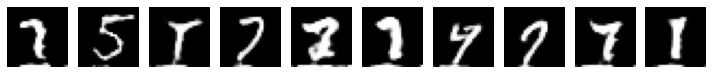

7501 [D loss: 0.366218, acc.: 83.59%] [G loss: 1.913768]
7502 [D loss: 0.394869, acc.: 82.81%] [G loss: 1.704125]
7503 [D loss: 0.372928, acc.: 84.38%] [G loss: 2.170694]
7504 [D loss: 0.295478, acc.: 85.94%] [G loss: 2.216066]
7505 [D loss: 0.358203, acc.: 83.59%] [G loss: 1.920882]
7506 [D loss: 0.417526, acc.: 82.81%] [G loss: 2.001823]
7507 [D loss: 0.473309, acc.: 78.12%] [G loss: 1.482563]
7508 [D loss: 0.476228, acc.: 76.56%] [G loss: 1.585266]
7509 [D loss: 0.368069, acc.: 87.50%] [G loss: 2.044805]
7510 [D loss: 0.313863, acc.: 86.72%] [G loss: 2.666418]
7511 [D loss: 0.363092, acc.: 85.94%] [G loss: 2.555671]
7512 [D loss: 0.494267, acc.: 76.56%] [G loss: 1.736338]
7513 [D loss: 0.429694, acc.: 77.34%] [G loss: 1.550540]
7514 [D loss: 0.449728, acc.: 79.69%] [G loss: 1.388409]
7515 [D loss: 0.421687, acc.: 81.25%] [G loss: 1.722269]
7516 [D loss: 0.451464, acc.: 80.47%] [G loss: 1.885826]
7517 [D loss: 0.363766, acc.: 79.69%] [G loss: 2.015930]
7518 [D loss: 0.581646, acc.: 7

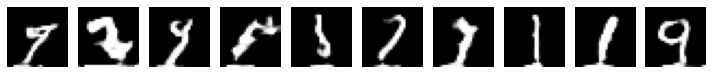

7601 [D loss: 0.466940, acc.: 80.47%] [G loss: 2.009927]
7602 [D loss: 0.389107, acc.: 82.81%] [G loss: 1.823596]
7603 [D loss: 0.522063, acc.: 75.00%] [G loss: 1.935412]
7604 [D loss: 0.588806, acc.: 70.31%] [G loss: 1.758820]
7605 [D loss: 0.442026, acc.: 80.47%] [G loss: 1.659563]
7606 [D loss: 0.450515, acc.: 78.12%] [G loss: 1.661681]
7607 [D loss: 0.423904, acc.: 83.59%] [G loss: 1.628390]
7608 [D loss: 0.446117, acc.: 78.12%] [G loss: 1.790165]
7609 [D loss: 0.456895, acc.: 76.56%] [G loss: 1.831084]
7610 [D loss: 0.457956, acc.: 80.47%] [G loss: 1.550936]
7611 [D loss: 0.465865, acc.: 80.47%] [G loss: 1.612737]
7612 [D loss: 0.422059, acc.: 80.47%] [G loss: 1.499101]
7613 [D loss: 0.432379, acc.: 75.00%] [G loss: 1.607178]
7614 [D loss: 0.398296, acc.: 82.81%] [G loss: 1.954142]
7615 [D loss: 0.469154, acc.: 79.69%] [G loss: 1.876248]
7616 [D loss: 0.480385, acc.: 78.12%] [G loss: 1.799103]
7617 [D loss: 0.497589, acc.: 77.34%] [G loss: 1.649597]
7618 [D loss: 0.468464, acc.: 7

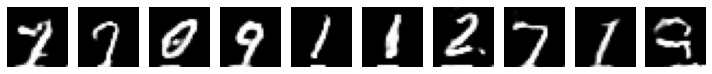

7701 [D loss: 0.447880, acc.: 78.12%] [G loss: 1.805645]
7702 [D loss: 0.384204, acc.: 78.91%] [G loss: 1.995386]
7703 [D loss: 0.382537, acc.: 82.81%] [G loss: 2.031846]
7704 [D loss: 0.513851, acc.: 72.66%] [G loss: 1.900075]
7705 [D loss: 0.499501, acc.: 75.00%] [G loss: 1.400574]
7706 [D loss: 0.469782, acc.: 75.78%] [G loss: 1.323649]
7707 [D loss: 0.331562, acc.: 86.72%] [G loss: 1.554663]
7708 [D loss: 0.357671, acc.: 84.38%] [G loss: 1.989395]
7709 [D loss: 0.405785, acc.: 82.81%] [G loss: 2.115619]
7710 [D loss: 0.407168, acc.: 79.69%] [G loss: 2.365143]
7711 [D loss: 0.440670, acc.: 75.00%] [G loss: 1.859020]
7712 [D loss: 0.379616, acc.: 82.81%] [G loss: 1.699335]
7713 [D loss: 0.449062, acc.: 78.12%] [G loss: 1.595764]
7714 [D loss: 0.496435, acc.: 74.22%] [G loss: 1.869177]
7715 [D loss: 0.387461, acc.: 80.47%] [G loss: 2.149555]
7716 [D loss: 0.455585, acc.: 78.91%] [G loss: 2.198448]
7717 [D loss: 0.341646, acc.: 85.16%] [G loss: 1.924874]
7718 [D loss: 0.451571, acc.: 7

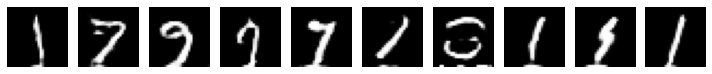

7801 [D loss: 0.384572, acc.: 81.25%] [G loss: 1.916734]
7802 [D loss: 0.448496, acc.: 78.12%] [G loss: 2.317358]
7803 [D loss: 0.447242, acc.: 78.12%] [G loss: 2.141191]
7804 [D loss: 0.472159, acc.: 81.25%] [G loss: 1.883356]
7805 [D loss: 0.402367, acc.: 83.59%] [G loss: 1.458943]
7806 [D loss: 0.501457, acc.: 76.56%] [G loss: 1.599837]
7807 [D loss: 0.365608, acc.: 84.38%] [G loss: 1.867171]
7808 [D loss: 0.399005, acc.: 84.38%] [G loss: 2.077028]
7809 [D loss: 0.386707, acc.: 83.59%] [G loss: 1.787729]
7810 [D loss: 0.470508, acc.: 76.56%] [G loss: 1.880173]
7811 [D loss: 0.574737, acc.: 73.44%] [G loss: 1.437814]
7812 [D loss: 0.567626, acc.: 71.09%] [G loss: 1.334003]
7813 [D loss: 0.462188, acc.: 79.69%] [G loss: 1.709887]
7814 [D loss: 0.442675, acc.: 80.47%] [G loss: 1.890175]
7815 [D loss: 0.435019, acc.: 79.69%] [G loss: 1.972950]
7816 [D loss: 0.524812, acc.: 76.56%] [G loss: 1.869562]
7817 [D loss: 0.562206, acc.: 73.44%] [G loss: 1.642184]
7818 [D loss: 0.508137, acc.: 7

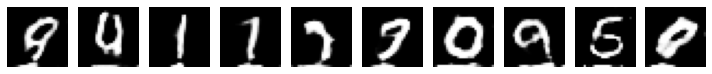

7901 [D loss: 0.454554, acc.: 77.34%] [G loss: 1.608958]
7902 [D loss: 0.513322, acc.: 74.22%] [G loss: 1.421644]
7903 [D loss: 0.424181, acc.: 82.03%] [G loss: 1.581168]
7904 [D loss: 0.484276, acc.: 75.78%] [G loss: 1.696747]
7905 [D loss: 0.443881, acc.: 79.69%] [G loss: 1.528432]
7906 [D loss: 0.384949, acc.: 85.16%] [G loss: 1.583574]
7907 [D loss: 0.428144, acc.: 80.47%] [G loss: 1.659462]
7908 [D loss: 0.458545, acc.: 76.56%] [G loss: 1.906605]
7909 [D loss: 0.436894, acc.: 80.47%] [G loss: 1.849002]
7910 [D loss: 0.478297, acc.: 78.12%] [G loss: 1.524220]
7911 [D loss: 0.533629, acc.: 77.34%] [G loss: 1.351850]
7912 [D loss: 0.480028, acc.: 74.22%] [G loss: 1.433614]
7913 [D loss: 0.342239, acc.: 85.94%] [G loss: 2.044557]
7914 [D loss: 0.456543, acc.: 76.56%] [G loss: 2.100320]
7915 [D loss: 0.437361, acc.: 78.91%] [G loss: 2.014267]
7916 [D loss: 0.418171, acc.: 82.81%] [G loss: 1.876723]
7917 [D loss: 0.350593, acc.: 85.16%] [G loss: 1.862839]
7918 [D loss: 0.428599, acc.: 7

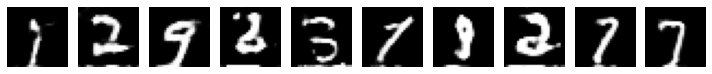

8001 [D loss: 0.475677, acc.: 77.34%] [G loss: 1.553509]
8002 [D loss: 0.427183, acc.: 80.47%] [G loss: 1.471846]
8003 [D loss: 0.462970, acc.: 79.69%] [G loss: 1.554176]
8004 [D loss: 0.316671, acc.: 91.41%] [G loss: 1.939731]
8005 [D loss: 0.432399, acc.: 80.47%] [G loss: 1.775432]
8006 [D loss: 0.436614, acc.: 78.91%] [G loss: 1.531905]
8007 [D loss: 0.402538, acc.: 83.59%] [G loss: 1.511638]
8008 [D loss: 0.471703, acc.: 75.78%] [G loss: 1.510051]
8009 [D loss: 0.553745, acc.: 70.31%] [G loss: 1.487717]
8010 [D loss: 0.466586, acc.: 80.47%] [G loss: 1.628228]
8011 [D loss: 0.450207, acc.: 80.47%] [G loss: 1.513813]
8012 [D loss: 0.416088, acc.: 80.47%] [G loss: 1.632154]
8013 [D loss: 0.434774, acc.: 82.81%] [G loss: 1.592902]
8014 [D loss: 0.432005, acc.: 78.91%] [G loss: 1.644335]
8015 [D loss: 0.470008, acc.: 79.69%] [G loss: 1.562847]
8016 [D loss: 0.488540, acc.: 78.12%] [G loss: 1.553621]
8017 [D loss: 0.332311, acc.: 85.94%] [G loss: 1.778734]
8018 [D loss: 0.481769, acc.: 8

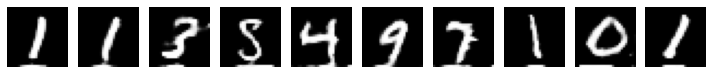

8101 [D loss: 0.428378, acc.: 76.56%] [G loss: 2.330443]
8102 [D loss: 0.435391, acc.: 80.47%] [G loss: 2.291839]
8103 [D loss: 0.494489, acc.: 78.12%] [G loss: 1.741911]
8104 [D loss: 0.420401, acc.: 78.91%] [G loss: 1.614214]
8105 [D loss: 0.404674, acc.: 80.47%] [G loss: 1.788521]
8106 [D loss: 0.413076, acc.: 79.69%] [G loss: 1.859149]
8107 [D loss: 0.544238, acc.: 71.88%] [G loss: 2.023348]
8108 [D loss: 0.444614, acc.: 78.12%] [G loss: 2.156194]
8109 [D loss: 0.449088, acc.: 78.91%] [G loss: 1.935765]
8110 [D loss: 0.409823, acc.: 80.47%] [G loss: 1.489891]
8111 [D loss: 0.359339, acc.: 86.72%] [G loss: 1.510010]
8112 [D loss: 0.450718, acc.: 75.78%] [G loss: 1.636690]
8113 [D loss: 0.385817, acc.: 80.47%] [G loss: 1.845164]
8114 [D loss: 0.418197, acc.: 82.03%] [G loss: 1.836524]
8115 [D loss: 0.420914, acc.: 78.12%] [G loss: 1.824018]
8116 [D loss: 0.457176, acc.: 81.25%] [G loss: 1.533661]
8117 [D loss: 0.417688, acc.: 79.69%] [G loss: 1.770425]
8118 [D loss: 0.532526, acc.: 7

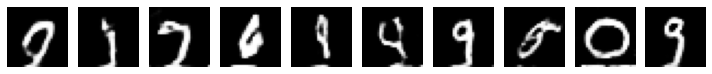

8201 [D loss: 0.527898, acc.: 73.44%] [G loss: 1.674626]
8202 [D loss: 0.408589, acc.: 82.81%] [G loss: 1.848117]
8203 [D loss: 0.462226, acc.: 76.56%] [G loss: 1.957163]
8204 [D loss: 0.482946, acc.: 82.81%] [G loss: 1.832250]
8205 [D loss: 0.434762, acc.: 81.25%] [G loss: 1.624879]
8206 [D loss: 0.386388, acc.: 82.03%] [G loss: 1.631829]
8207 [D loss: 0.432887, acc.: 76.56%] [G loss: 1.470359]
8208 [D loss: 0.504734, acc.: 71.88%] [G loss: 1.527013]
8209 [D loss: 0.498476, acc.: 73.44%] [G loss: 1.850199]
8210 [D loss: 0.413345, acc.: 82.03%] [G loss: 1.931067]
8211 [D loss: 0.415281, acc.: 80.47%] [G loss: 1.931765]
8212 [D loss: 0.375482, acc.: 80.47%] [G loss: 1.875592]
8213 [D loss: 0.560814, acc.: 74.22%] [G loss: 1.756965]
8214 [D loss: 0.524938, acc.: 78.91%] [G loss: 1.689179]
8215 [D loss: 0.382426, acc.: 82.03%] [G loss: 1.818130]
8216 [D loss: 0.415107, acc.: 80.47%] [G loss: 1.967261]
8217 [D loss: 0.469448, acc.: 78.12%] [G loss: 1.807306]
8218 [D loss: 0.489785, acc.: 7

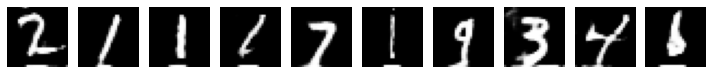

8301 [D loss: 0.380562, acc.: 84.38%] [G loss: 2.029016]
8302 [D loss: 0.514147, acc.: 73.44%] [G loss: 1.813316]
8303 [D loss: 0.425960, acc.: 76.56%] [G loss: 1.675322]
8304 [D loss: 0.471794, acc.: 75.00%] [G loss: 1.431086]
8305 [D loss: 0.447998, acc.: 82.03%] [G loss: 1.589916]
8306 [D loss: 0.359649, acc.: 82.81%] [G loss: 1.790792]
8307 [D loss: 0.465249, acc.: 72.66%] [G loss: 2.006337]
8308 [D loss: 0.390079, acc.: 86.72%] [G loss: 2.026787]
8309 [D loss: 0.672546, acc.: 67.97%] [G loss: 1.670082]
8310 [D loss: 0.458616, acc.: 78.12%] [G loss: 1.509260]
8311 [D loss: 0.451249, acc.: 78.91%] [G loss: 1.244447]
8312 [D loss: 0.607561, acc.: 71.09%] [G loss: 1.369635]
8313 [D loss: 0.489967, acc.: 81.25%] [G loss: 1.666465]
8314 [D loss: 0.573346, acc.: 72.66%] [G loss: 1.915277]
8315 [D loss: 0.489575, acc.: 78.12%] [G loss: 2.002119]
8316 [D loss: 0.624148, acc.: 70.31%] [G loss: 1.953147]
8317 [D loss: 0.638427, acc.: 70.31%] [G loss: 1.466456]
8318 [D loss: 0.475929, acc.: 7

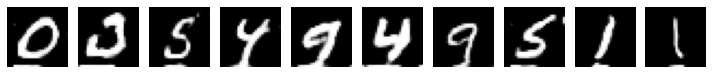

8401 [D loss: 0.490840, acc.: 77.34%] [G loss: 1.847584]
8402 [D loss: 0.524945, acc.: 71.88%] [G loss: 2.183473]
8403 [D loss: 0.468137, acc.: 76.56%] [G loss: 1.926084]
8404 [D loss: 0.514741, acc.: 72.66%] [G loss: 1.802602]
8405 [D loss: 0.482587, acc.: 78.12%] [G loss: 1.510737]
8406 [D loss: 0.542642, acc.: 70.31%] [G loss: 1.288122]
8407 [D loss: 0.420689, acc.: 82.81%] [G loss: 1.330608]
8408 [D loss: 0.393481, acc.: 82.03%] [G loss: 1.713395]
8409 [D loss: 0.376833, acc.: 80.47%] [G loss: 1.935917]
8410 [D loss: 0.320832, acc.: 87.50%] [G loss: 2.010857]
8411 [D loss: 0.429617, acc.: 79.69%] [G loss: 2.129235]
8412 [D loss: 0.341636, acc.: 85.16%] [G loss: 2.200433]
8413 [D loss: 0.347295, acc.: 84.38%] [G loss: 1.987317]
8414 [D loss: 0.431581, acc.: 78.91%] [G loss: 1.671052]
8415 [D loss: 0.331107, acc.: 83.59%] [G loss: 1.665077]
8416 [D loss: 0.379134, acc.: 85.16%] [G loss: 1.746474]
8417 [D loss: 0.366133, acc.: 89.84%] [G loss: 1.854611]
8418 [D loss: 0.355349, acc.: 8

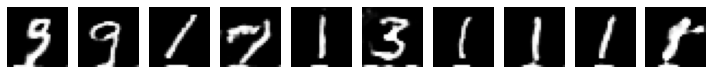

8501 [D loss: 0.522310, acc.: 71.88%] [G loss: 1.602690]
8502 [D loss: 0.509805, acc.: 76.56%] [G loss: 1.841895]
8503 [D loss: 0.380404, acc.: 81.25%] [G loss: 2.084896]
8504 [D loss: 0.390219, acc.: 80.47%] [G loss: 1.973979]
8505 [D loss: 0.476025, acc.: 81.25%] [G loss: 1.829870]
8506 [D loss: 0.464579, acc.: 83.59%] [G loss: 1.668175]
8507 [D loss: 0.511734, acc.: 75.78%] [G loss: 1.505231]
8508 [D loss: 0.449443, acc.: 75.78%] [G loss: 1.317664]
8509 [D loss: 0.560241, acc.: 74.22%] [G loss: 1.475926]
8510 [D loss: 0.469951, acc.: 81.25%] [G loss: 1.714576]
8511 [D loss: 0.429767, acc.: 80.47%] [G loss: 1.708705]
8512 [D loss: 0.515688, acc.: 72.66%] [G loss: 1.684485]
8513 [D loss: 0.647052, acc.: 67.97%] [G loss: 1.416230]
8514 [D loss: 0.545643, acc.: 75.78%] [G loss: 1.429897]
8515 [D loss: 0.524450, acc.: 78.12%] [G loss: 1.366403]
8516 [D loss: 0.504046, acc.: 73.44%] [G loss: 1.181650]
8517 [D loss: 0.470909, acc.: 78.91%] [G loss: 1.471068]
8518 [D loss: 0.438963, acc.: 7

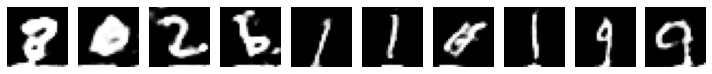

8601 [D loss: 0.550670, acc.: 69.53%] [G loss: 1.961017]
8602 [D loss: 0.560894, acc.: 71.09%] [G loss: 1.886455]
8603 [D loss: 0.462567, acc.: 79.69%] [G loss: 1.867913]
8604 [D loss: 0.516443, acc.: 78.91%] [G loss: 1.767046]
8605 [D loss: 0.468285, acc.: 74.22%] [G loss: 1.677928]
8606 [D loss: 0.534485, acc.: 75.00%] [G loss: 1.516930]
8607 [D loss: 0.479113, acc.: 80.47%] [G loss: 1.349203]
8608 [D loss: 0.344469, acc.: 82.03%] [G loss: 1.287073]
8609 [D loss: 0.469206, acc.: 75.78%] [G loss: 1.523395]
8610 [D loss: 0.410603, acc.: 79.69%] [G loss: 1.792086]
8611 [D loss: 0.372714, acc.: 84.38%] [G loss: 2.094244]
8612 [D loss: 0.440184, acc.: 78.12%] [G loss: 1.940688]
8613 [D loss: 0.476873, acc.: 75.78%] [G loss: 1.634583]
8614 [D loss: 0.385998, acc.: 82.81%] [G loss: 1.386032]
8615 [D loss: 0.470811, acc.: 74.22%] [G loss: 1.601270]
8616 [D loss: 0.365583, acc.: 83.59%] [G loss: 1.619773]
8617 [D loss: 0.453274, acc.: 80.47%] [G loss: 2.047846]
8618 [D loss: 0.429680, acc.: 8

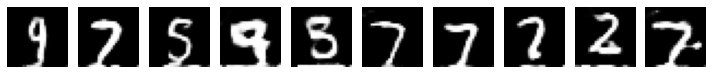

8701 [D loss: 0.368274, acc.: 81.25%] [G loss: 1.683270]
8702 [D loss: 0.482341, acc.: 78.91%] [G loss: 1.964465]
8703 [D loss: 0.464116, acc.: 75.00%] [G loss: 1.831341]
8704 [D loss: 0.531868, acc.: 74.22%] [G loss: 1.914072]
8705 [D loss: 0.469515, acc.: 76.56%] [G loss: 1.879574]
8706 [D loss: 0.505931, acc.: 75.00%] [G loss: 1.554713]
8707 [D loss: 0.532524, acc.: 71.09%] [G loss: 1.721161]
8708 [D loss: 0.455869, acc.: 74.22%] [G loss: 1.654044]
8709 [D loss: 0.400531, acc.: 80.47%] [G loss: 1.895572]
8710 [D loss: 0.499577, acc.: 78.91%] [G loss: 1.811063]
8711 [D loss: 0.476800, acc.: 77.34%] [G loss: 1.464485]
8712 [D loss: 0.502760, acc.: 78.12%] [G loss: 1.419584]
8713 [D loss: 0.551880, acc.: 69.53%] [G loss: 1.324140]
8714 [D loss: 0.444986, acc.: 81.25%] [G loss: 1.477089]
8715 [D loss: 0.398159, acc.: 82.81%] [G loss: 1.551246]
8716 [D loss: 0.362250, acc.: 82.81%] [G loss: 1.799897]
8717 [D loss: 0.434994, acc.: 78.12%] [G loss: 1.642474]
8718 [D loss: 0.482987, acc.: 7

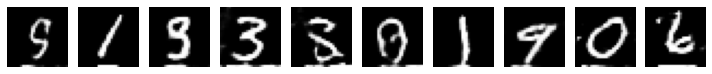

8801 [D loss: 0.539541, acc.: 71.88%] [G loss: 1.505215]
8802 [D loss: 0.461062, acc.: 77.34%] [G loss: 1.405026]
8803 [D loss: 0.438130, acc.: 81.25%] [G loss: 1.352519]
8804 [D loss: 0.516333, acc.: 74.22%] [G loss: 1.420297]
8805 [D loss: 0.493088, acc.: 71.09%] [G loss: 1.569077]
8806 [D loss: 0.405187, acc.: 80.47%] [G loss: 1.810622]
8807 [D loss: 0.423723, acc.: 79.69%] [G loss: 1.904904]
8808 [D loss: 0.506255, acc.: 72.66%] [G loss: 1.705645]
8809 [D loss: 0.450220, acc.: 76.56%] [G loss: 1.339777]
8810 [D loss: 0.405569, acc.: 78.12%] [G loss: 1.403432]
8811 [D loss: 0.530487, acc.: 75.78%] [G loss: 1.294064]
8812 [D loss: 0.519143, acc.: 73.44%] [G loss: 1.483908]
8813 [D loss: 0.401834, acc.: 78.12%] [G loss: 1.732562]
8814 [D loss: 0.454270, acc.: 74.22%] [G loss: 1.711708]
8815 [D loss: 0.541939, acc.: 72.66%] [G loss: 1.602317]
8816 [D loss: 0.554415, acc.: 75.00%] [G loss: 1.480737]
8817 [D loss: 0.445083, acc.: 82.03%] [G loss: 1.525476]
8818 [D loss: 0.482879, acc.: 7

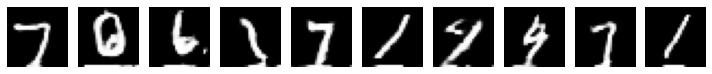

8901 [D loss: 0.415575, acc.: 78.91%] [G loss: 1.832176]
8902 [D loss: 0.379888, acc.: 85.16%] [G loss: 1.933206]
8903 [D loss: 0.374610, acc.: 86.72%] [G loss: 1.948399]
8904 [D loss: 0.441642, acc.: 76.56%] [G loss: 1.812801]
8905 [D loss: 0.449459, acc.: 81.25%] [G loss: 1.738620]
8906 [D loss: 0.463326, acc.: 82.03%] [G loss: 1.727978]
8907 [D loss: 0.507621, acc.: 75.00%] [G loss: 1.647804]
8908 [D loss: 0.342357, acc.: 85.16%] [G loss: 1.801777]
8909 [D loss: 0.491294, acc.: 80.47%] [G loss: 1.904376]
8910 [D loss: 0.474775, acc.: 77.34%] [G loss: 1.592996]
8911 [D loss: 0.526491, acc.: 72.66%] [G loss: 1.481684]
8912 [D loss: 0.452194, acc.: 81.25%] [G loss: 1.424024]
8913 [D loss: 0.451652, acc.: 75.78%] [G loss: 1.494426]
8914 [D loss: 0.590662, acc.: 74.22%] [G loss: 1.802733]
8915 [D loss: 0.382954, acc.: 82.81%] [G loss: 1.989644]
8916 [D loss: 0.687389, acc.: 70.31%] [G loss: 1.675677]
8917 [D loss: 0.506632, acc.: 75.00%] [G loss: 1.414394]
8918 [D loss: 0.602553, acc.: 6

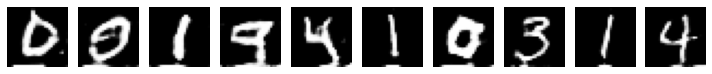

9001 [D loss: 0.405185, acc.: 82.81%] [G loss: 1.652390]
9002 [D loss: 0.461449, acc.: 77.34%] [G loss: 1.670075]
9003 [D loss: 0.513668, acc.: 74.22%] [G loss: 1.421447]
9004 [D loss: 0.520324, acc.: 71.88%] [G loss: 1.317062]
9005 [D loss: 0.503974, acc.: 76.56%] [G loss: 1.353391]
9006 [D loss: 0.544932, acc.: 74.22%] [G loss: 1.463062]
9007 [D loss: 0.547963, acc.: 72.66%] [G loss: 1.717460]
9008 [D loss: 0.500308, acc.: 77.34%] [G loss: 1.859021]
9009 [D loss: 0.489867, acc.: 78.12%] [G loss: 1.760316]
9010 [D loss: 0.473550, acc.: 76.56%] [G loss: 1.509011]
9011 [D loss: 0.512565, acc.: 74.22%] [G loss: 1.543932]
9012 [D loss: 0.491981, acc.: 72.66%] [G loss: 1.335719]
9013 [D loss: 0.453495, acc.: 78.12%] [G loss: 1.325848]
9014 [D loss: 0.403002, acc.: 82.81%] [G loss: 1.774557]
9015 [D loss: 0.359806, acc.: 85.16%] [G loss: 2.176362]
9016 [D loss: 0.438928, acc.: 81.25%] [G loss: 2.187271]
9017 [D loss: 0.396884, acc.: 83.59%] [G loss: 1.962788]
9018 [D loss: 0.520530, acc.: 7

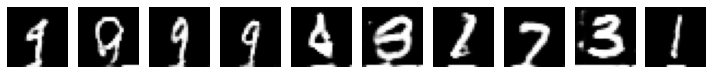

9101 [D loss: 0.524369, acc.: 78.12%] [G loss: 1.755527]
9102 [D loss: 0.488432, acc.: 77.34%] [G loss: 1.561038]
9103 [D loss: 0.472681, acc.: 78.91%] [G loss: 1.597047]
9104 [D loss: 0.450687, acc.: 78.12%] [G loss: 1.797056]
9105 [D loss: 0.498692, acc.: 75.00%] [G loss: 1.747992]
9106 [D loss: 0.464032, acc.: 78.91%] [G loss: 1.476374]
9107 [D loss: 0.515873, acc.: 77.34%] [G loss: 1.484457]
9108 [D loss: 0.488450, acc.: 76.56%] [G loss: 1.548198]
9109 [D loss: 0.444228, acc.: 75.00%] [G loss: 1.556645]
9110 [D loss: 0.460815, acc.: 77.34%] [G loss: 1.504208]
9111 [D loss: 0.493229, acc.: 71.09%] [G loss: 1.603073]
9112 [D loss: 0.413490, acc.: 85.16%] [G loss: 1.571947]
9113 [D loss: 0.489912, acc.: 74.22%] [G loss: 1.628818]
9114 [D loss: 0.393499, acc.: 84.38%] [G loss: 1.749511]
9115 [D loss: 0.505852, acc.: 77.34%] [G loss: 1.641753]
9116 [D loss: 0.474761, acc.: 76.56%] [G loss: 1.513115]
9117 [D loss: 0.450491, acc.: 79.69%] [G loss: 1.329389]
9118 [D loss: 0.406531, acc.: 7

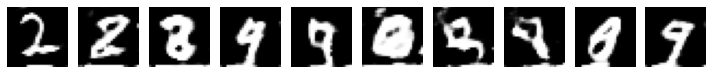

9201 [D loss: 0.405934, acc.: 83.59%] [G loss: 1.844628]
9202 [D loss: 0.393374, acc.: 85.16%] [G loss: 1.615530]
9203 [D loss: 0.461588, acc.: 79.69%] [G loss: 1.528714]
9204 [D loss: 0.529323, acc.: 74.22%] [G loss: 1.445778]
9205 [D loss: 0.432971, acc.: 78.91%] [G loss: 1.591327]
9206 [D loss: 0.429944, acc.: 78.91%] [G loss: 1.856825]
9207 [D loss: 0.393208, acc.: 84.38%] [G loss: 1.978595]
9208 [D loss: 0.461455, acc.: 80.47%] [G loss: 2.044003]
9209 [D loss: 0.479796, acc.: 78.91%] [G loss: 1.777774]
9210 [D loss: 0.455461, acc.: 75.78%] [G loss: 1.335851]
9211 [D loss: 0.624486, acc.: 71.09%] [G loss: 1.606149]
9212 [D loss: 0.389475, acc.: 82.03%] [G loss: 1.594805]
9213 [D loss: 0.492560, acc.: 76.56%] [G loss: 1.545360]
9214 [D loss: 0.480590, acc.: 75.78%] [G loss: 1.749736]
9215 [D loss: 0.400255, acc.: 83.59%] [G loss: 1.781799]
9216 [D loss: 0.468558, acc.: 75.78%] [G loss: 1.664741]
9217 [D loss: 0.504963, acc.: 75.78%] [G loss: 1.551879]
9218 [D loss: 0.439953, acc.: 8

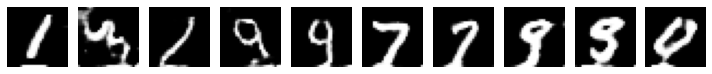

9301 [D loss: 0.377288, acc.: 81.25%] [G loss: 2.001596]
9302 [D loss: 0.378116, acc.: 84.38%] [G loss: 2.337653]
9303 [D loss: 0.508616, acc.: 75.00%] [G loss: 2.113633]
9304 [D loss: 0.570512, acc.: 69.53%] [G loss: 2.013416]
9305 [D loss: 0.488542, acc.: 78.91%] [G loss: 1.857679]
9306 [D loss: 0.393047, acc.: 81.25%] [G loss: 1.836256]
9307 [D loss: 0.421711, acc.: 85.94%] [G loss: 1.937879]
9308 [D loss: 0.477241, acc.: 78.12%] [G loss: 1.855865]
9309 [D loss: 0.520166, acc.: 74.22%] [G loss: 1.772574]
9310 [D loss: 0.504817, acc.: 80.47%] [G loss: 1.780303]
9311 [D loss: 0.478207, acc.: 77.34%] [G loss: 1.812830]
9312 [D loss: 0.489563, acc.: 76.56%] [G loss: 1.929544]
9313 [D loss: 0.479818, acc.: 73.44%] [G loss: 1.905320]
9314 [D loss: 0.551099, acc.: 73.44%] [G loss: 1.874925]
9315 [D loss: 0.488952, acc.: 77.34%] [G loss: 1.504265]
9316 [D loss: 0.431840, acc.: 77.34%] [G loss: 1.521793]
9317 [D loss: 0.513223, acc.: 72.66%] [G loss: 1.538916]
9318 [D loss: 0.498638, acc.: 7

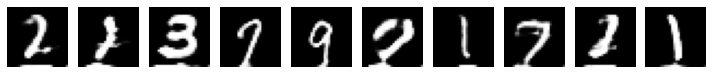

9401 [D loss: 0.559135, acc.: 74.22%] [G loss: 1.589258]
9402 [D loss: 0.518085, acc.: 75.00%] [G loss: 1.498732]
9403 [D loss: 0.526979, acc.: 73.44%] [G loss: 1.423990]
9404 [D loss: 0.511820, acc.: 75.78%] [G loss: 1.380024]
9405 [D loss: 0.476870, acc.: 77.34%] [G loss: 1.440807]
9406 [D loss: 0.477753, acc.: 76.56%] [G loss: 1.382235]
9407 [D loss: 0.453752, acc.: 78.12%] [G loss: 1.365633]
9408 [D loss: 0.501781, acc.: 77.34%] [G loss: 1.424023]
9409 [D loss: 0.493098, acc.: 73.44%] [G loss: 1.456825]
9410 [D loss: 0.440176, acc.: 81.25%] [G loss: 1.512882]
9411 [D loss: 0.546083, acc.: 72.66%] [G loss: 1.458306]
9412 [D loss: 0.400792, acc.: 82.03%] [G loss: 1.595169]
9413 [D loss: 0.419407, acc.: 79.69%] [G loss: 1.662767]
9414 [D loss: 0.455553, acc.: 77.34%] [G loss: 1.493503]
9415 [D loss: 0.466340, acc.: 81.25%] [G loss: 1.338636]
9416 [D loss: 0.452042, acc.: 76.56%] [G loss: 1.332847]
9417 [D loss: 0.561827, acc.: 74.22%] [G loss: 1.521899]
9418 [D loss: 0.393947, acc.: 8

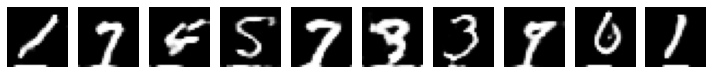

9501 [D loss: 0.420102, acc.: 82.81%] [G loss: 1.866047]
9502 [D loss: 0.504589, acc.: 73.44%] [G loss: 1.542099]
9503 [D loss: 0.462985, acc.: 71.88%] [G loss: 1.726394]
9504 [D loss: 0.426707, acc.: 81.25%] [G loss: 1.944290]
9505 [D loss: 0.412611, acc.: 78.91%] [G loss: 2.020312]
9506 [D loss: 0.354276, acc.: 85.16%] [G loss: 1.846289]
9507 [D loss: 0.430711, acc.: 81.25%] [G loss: 1.731009]
9508 [D loss: 0.492293, acc.: 76.56%] [G loss: 1.629562]
9509 [D loss: 0.555313, acc.: 73.44%] [G loss: 1.702443]
9510 [D loss: 0.579506, acc.: 74.22%] [G loss: 1.556711]
9511 [D loss: 0.461107, acc.: 76.56%] [G loss: 1.491502]
9512 [D loss: 0.491016, acc.: 78.91%] [G loss: 1.501832]
9513 [D loss: 0.441218, acc.: 80.47%] [G loss: 1.681940]
9514 [D loss: 0.463237, acc.: 80.47%] [G loss: 1.950990]
9515 [D loss: 0.447685, acc.: 80.47%] [G loss: 1.665793]
9516 [D loss: 0.649446, acc.: 61.72%] [G loss: 1.355474]
9517 [D loss: 0.478412, acc.: 72.66%] [G loss: 1.264508]
9518 [D loss: 0.548223, acc.: 7

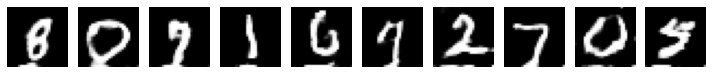

9601 [D loss: 0.426902, acc.: 82.03%] [G loss: 1.461298]
9602 [D loss: 0.464689, acc.: 78.12%] [G loss: 1.408550]
9603 [D loss: 0.520325, acc.: 73.44%] [G loss: 1.440248]
9604 [D loss: 0.371557, acc.: 84.38%] [G loss: 1.656789]
9605 [D loss: 0.421840, acc.: 80.47%] [G loss: 1.758985]
9606 [D loss: 0.473323, acc.: 73.44%] [G loss: 1.754206]
9607 [D loss: 0.432778, acc.: 79.69%] [G loss: 1.743081]
9608 [D loss: 0.382489, acc.: 80.47%] [G loss: 1.723287]
9609 [D loss: 0.408872, acc.: 84.38%] [G loss: 1.738240]
9610 [D loss: 0.434963, acc.: 81.25%] [G loss: 1.528455]
9611 [D loss: 0.361245, acc.: 84.38%] [G loss: 1.676092]
9612 [D loss: 0.434946, acc.: 78.12%] [G loss: 1.864893]
9613 [D loss: 0.413809, acc.: 80.47%] [G loss: 2.120838]
9614 [D loss: 0.377355, acc.: 79.69%] [G loss: 2.094247]
9615 [D loss: 0.401568, acc.: 83.59%] [G loss: 1.985935]
9616 [D loss: 0.412421, acc.: 79.69%] [G loss: 1.828944]
9617 [D loss: 0.374662, acc.: 79.69%] [G loss: 1.837229]
9618 [D loss: 0.382935, acc.: 8

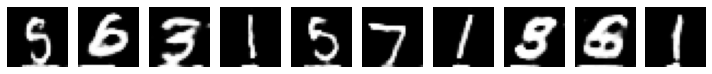

9701 [D loss: 0.403965, acc.: 80.47%] [G loss: 1.961074]
9702 [D loss: 0.403493, acc.: 84.38%] [G loss: 1.904787]
9703 [D loss: 0.492211, acc.: 73.44%] [G loss: 1.760247]
9704 [D loss: 0.412953, acc.: 75.78%] [G loss: 1.580456]
9705 [D loss: 0.551778, acc.: 71.09%] [G loss: 1.383795]
9706 [D loss: 0.479502, acc.: 75.78%] [G loss: 1.723074]
9707 [D loss: 0.401099, acc.: 83.59%] [G loss: 1.801189]
9708 [D loss: 0.418022, acc.: 82.03%] [G loss: 1.929762]
9709 [D loss: 0.556852, acc.: 73.44%] [G loss: 1.745433]
9710 [D loss: 0.530450, acc.: 76.56%] [G loss: 1.861115]
9711 [D loss: 0.361468, acc.: 84.38%] [G loss: 1.880271]
9712 [D loss: 0.474055, acc.: 76.56%] [G loss: 1.838839]
9713 [D loss: 0.522165, acc.: 75.00%] [G loss: 1.690299]
9714 [D loss: 0.409296, acc.: 79.69%] [G loss: 1.699335]
9715 [D loss: 0.384204, acc.: 75.78%] [G loss: 1.793496]
9716 [D loss: 0.449904, acc.: 79.69%] [G loss: 2.000881]
9717 [D loss: 0.376298, acc.: 82.81%] [G loss: 2.150646]
9718 [D loss: 0.471738, acc.: 7

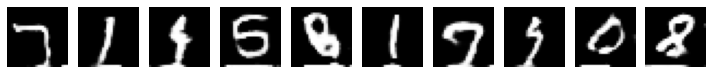

9801 [D loss: 0.413807, acc.: 78.91%] [G loss: 2.238496]
9802 [D loss: 0.644602, acc.: 67.97%] [G loss: 1.763219]
9803 [D loss: 0.384363, acc.: 78.91%] [G loss: 2.060190]
9804 [D loss: 0.339954, acc.: 86.72%] [G loss: 2.306595]
9805 [D loss: 0.383080, acc.: 84.38%] [G loss: 2.368456]
9806 [D loss: 0.505773, acc.: 75.00%] [G loss: 1.805815]
9807 [D loss: 0.550568, acc.: 73.44%] [G loss: 1.603611]
9808 [D loss: 0.552500, acc.: 72.66%] [G loss: 1.576552]
9809 [D loss: 0.466239, acc.: 77.34%] [G loss: 1.636724]
9810 [D loss: 0.446438, acc.: 78.12%] [G loss: 1.892387]
9811 [D loss: 0.504957, acc.: 80.47%] [G loss: 1.745830]
9812 [D loss: 0.544145, acc.: 73.44%] [G loss: 1.520583]
9813 [D loss: 0.416939, acc.: 80.47%] [G loss: 1.234209]
9814 [D loss: 0.508614, acc.: 76.56%] [G loss: 1.419351]
9815 [D loss: 0.377776, acc.: 85.16%] [G loss: 1.695428]
9816 [D loss: 0.445452, acc.: 82.03%] [G loss: 1.643912]
9817 [D loss: 0.576719, acc.: 72.66%] [G loss: 1.637773]
9818 [D loss: 0.437470, acc.: 8

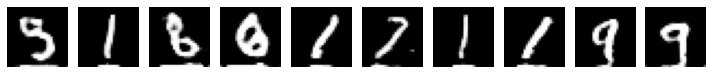

9901 [D loss: 0.520391, acc.: 76.56%] [G loss: 1.696822]
9902 [D loss: 0.468201, acc.: 78.12%] [G loss: 1.571415]
9903 [D loss: 0.429381, acc.: 79.69%] [G loss: 1.466224]
9904 [D loss: 0.470192, acc.: 75.00%] [G loss: 1.514374]
9905 [D loss: 0.424805, acc.: 81.25%] [G loss: 1.673491]
9906 [D loss: 0.405820, acc.: 78.91%] [G loss: 1.618237]
9907 [D loss: 0.373985, acc.: 88.28%] [G loss: 1.817355]
9908 [D loss: 0.426119, acc.: 81.25%] [G loss: 1.820091]
9909 [D loss: 0.503102, acc.: 72.66%] [G loss: 1.646405]
9910 [D loss: 0.395436, acc.: 85.94%] [G loss: 1.918071]
9911 [D loss: 0.351748, acc.: 85.16%] [G loss: 2.000372]
9912 [D loss: 0.468454, acc.: 75.78%] [G loss: 2.039836]
9913 [D loss: 0.398387, acc.: 85.16%] [G loss: 1.721931]
9914 [D loss: 0.404161, acc.: 82.81%] [G loss: 1.800927]
9915 [D loss: 0.306997, acc.: 88.28%] [G loss: 1.848283]
9916 [D loss: 0.379572, acc.: 78.91%] [G loss: 1.876467]
9917 [D loss: 0.405764, acc.: 80.47%] [G loss: 2.041073]
9918 [D loss: 0.357761, acc.: 8

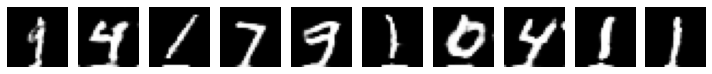

10001 [D loss: 0.423038, acc.: 82.81%] [G loss: 1.735802]
10002 [D loss: 0.393699, acc.: 80.47%] [G loss: 2.041739]
10003 [D loss: 0.460464, acc.: 73.44%] [G loss: 2.280366]
10004 [D loss: 0.445769, acc.: 78.91%] [G loss: 1.867130]
10005 [D loss: 0.360347, acc.: 84.38%] [G loss: 1.661011]
10006 [D loss: 0.419130, acc.: 80.47%] [G loss: 1.638384]
10007 [D loss: 0.419318, acc.: 76.56%] [G loss: 1.883379]
10008 [D loss: 0.303007, acc.: 87.50%] [G loss: 2.385035]
10009 [D loss: 0.397818, acc.: 82.81%] [G loss: 2.489546]
10010 [D loss: 0.480473, acc.: 75.78%] [G loss: 1.852567]
10011 [D loss: 0.492604, acc.: 80.47%] [G loss: 1.416451]
10012 [D loss: 0.538145, acc.: 74.22%] [G loss: 1.315437]
10013 [D loss: 0.386808, acc.: 84.38%] [G loss: 1.592787]
10014 [D loss: 0.378870, acc.: 82.81%] [G loss: 2.175497]
10015 [D loss: 0.496857, acc.: 73.44%] [G loss: 2.051770]
10016 [D loss: 0.501077, acc.: 78.12%] [G loss: 1.805775]
10017 [D loss: 0.556936, acc.: 70.31%] [G loss: 1.278398]
10018 [D loss:

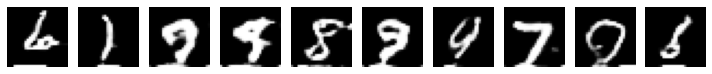

10101 [D loss: 0.402209, acc.: 78.12%] [G loss: 1.531873]
10102 [D loss: 0.534182, acc.: 73.44%] [G loss: 1.688932]
10103 [D loss: 0.425470, acc.: 80.47%] [G loss: 1.982039]
10104 [D loss: 0.528859, acc.: 72.66%] [G loss: 1.899822]
10105 [D loss: 0.462154, acc.: 77.34%] [G loss: 1.679085]
10106 [D loss: 0.436262, acc.: 82.81%] [G loss: 1.376489]
10107 [D loss: 0.565691, acc.: 72.66%] [G loss: 1.300880]
10108 [D loss: 0.537903, acc.: 72.66%] [G loss: 1.340408]
10109 [D loss: 0.502987, acc.: 73.44%] [G loss: 1.782604]
10110 [D loss: 0.452937, acc.: 80.47%] [G loss: 1.765293]
10111 [D loss: 0.420514, acc.: 84.38%] [G loss: 1.790249]
10112 [D loss: 0.586682, acc.: 67.97%] [G loss: 1.552206]
10113 [D loss: 0.639523, acc.: 70.31%] [G loss: 1.355873]
10114 [D loss: 0.535658, acc.: 71.88%] [G loss: 1.202010]
10115 [D loss: 0.438671, acc.: 79.69%] [G loss: 1.304935]
10116 [D loss: 0.458935, acc.: 78.12%] [G loss: 1.539117]
10117 [D loss: 0.392441, acc.: 81.25%] [G loss: 1.776940]
10118 [D loss:

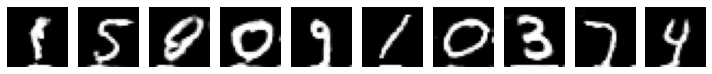

10201 [D loss: 0.498963, acc.: 75.78%] [G loss: 1.749651]
10202 [D loss: 0.498744, acc.: 70.31%] [G loss: 1.473167]
10203 [D loss: 0.496366, acc.: 73.44%] [G loss: 1.405539]
10204 [D loss: 0.485312, acc.: 76.56%] [G loss: 1.396335]
10205 [D loss: 0.396617, acc.: 84.38%] [G loss: 1.228567]
10206 [D loss: 0.414319, acc.: 79.69%] [G loss: 1.278367]
10207 [D loss: 0.389259, acc.: 83.59%] [G loss: 1.405316]
10208 [D loss: 0.483732, acc.: 75.78%] [G loss: 1.735091]
10209 [D loss: 0.422798, acc.: 75.78%] [G loss: 1.698707]
10210 [D loss: 0.431317, acc.: 78.91%] [G loss: 1.585019]
10211 [D loss: 0.457826, acc.: 76.56%] [G loss: 1.472840]
10212 [D loss: 0.451813, acc.: 75.00%] [G loss: 1.410412]
10213 [D loss: 0.472016, acc.: 77.34%] [G loss: 1.503357]
10214 [D loss: 0.458627, acc.: 78.91%] [G loss: 1.472802]
10215 [D loss: 0.499995, acc.: 74.22%] [G loss: 1.690015]
10216 [D loss: 0.350106, acc.: 86.72%] [G loss: 1.643113]
10217 [D loss: 0.501663, acc.: 75.78%] [G loss: 1.525762]
10218 [D loss:

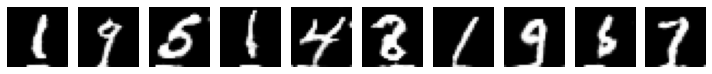

10301 [D loss: 0.509019, acc.: 73.44%] [G loss: 1.585103]
10302 [D loss: 0.473930, acc.: 78.12%] [G loss: 1.686372]
10303 [D loss: 0.455949, acc.: 76.56%] [G loss: 1.630908]
10304 [D loss: 0.514719, acc.: 75.00%] [G loss: 1.454737]
10305 [D loss: 0.466349, acc.: 79.69%] [G loss: 1.289525]
10306 [D loss: 0.470823, acc.: 76.56%] [G loss: 1.187545]
10307 [D loss: 0.436753, acc.: 79.69%] [G loss: 1.375146]
10308 [D loss: 0.478860, acc.: 76.56%] [G loss: 1.399934]
10309 [D loss: 0.401928, acc.: 83.59%] [G loss: 1.565936]
10310 [D loss: 0.375892, acc.: 85.94%] [G loss: 1.768441]
10311 [D loss: 0.493004, acc.: 77.34%] [G loss: 1.719737]
10312 [D loss: 0.465142, acc.: 74.22%] [G loss: 1.780250]
10313 [D loss: 0.463024, acc.: 70.31%] [G loss: 1.654543]
10314 [D loss: 0.394600, acc.: 79.69%] [G loss: 1.513096]
10315 [D loss: 0.450205, acc.: 77.34%] [G loss: 1.651491]
10316 [D loss: 0.471961, acc.: 75.00%] [G loss: 1.615609]
10317 [D loss: 0.333063, acc.: 86.72%] [G loss: 1.888085]
10318 [D loss:

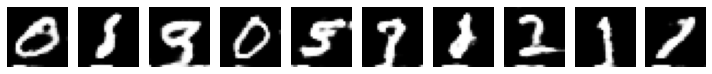

10401 [D loss: 0.518274, acc.: 73.44%] [G loss: 1.606136]
10402 [D loss: 0.579693, acc.: 67.97%] [G loss: 1.733069]
10403 [D loss: 0.488744, acc.: 75.78%] [G loss: 1.852833]
10404 [D loss: 0.416788, acc.: 77.34%] [G loss: 1.788866]
10405 [D loss: 0.570782, acc.: 74.22%] [G loss: 1.693119]
10406 [D loss: 0.476891, acc.: 78.91%] [G loss: 1.385965]
10407 [D loss: 0.473227, acc.: 73.44%] [G loss: 1.624875]
10408 [D loss: 0.432573, acc.: 78.91%] [G loss: 1.749340]
10409 [D loss: 0.436904, acc.: 78.12%] [G loss: 1.660756]
10410 [D loss: 0.432868, acc.: 79.69%] [G loss: 1.826582]
10411 [D loss: 0.498734, acc.: 74.22%] [G loss: 1.728705]
10412 [D loss: 0.471164, acc.: 75.78%] [G loss: 1.482372]
10413 [D loss: 0.487181, acc.: 75.78%] [G loss: 1.448209]
10414 [D loss: 0.407941, acc.: 82.81%] [G loss: 1.733394]
10415 [D loss: 0.402529, acc.: 80.47%] [G loss: 1.862282]
10416 [D loss: 0.425225, acc.: 80.47%] [G loss: 1.854452]
10417 [D loss: 0.469538, acc.: 77.34%] [G loss: 1.670934]
10418 [D loss:

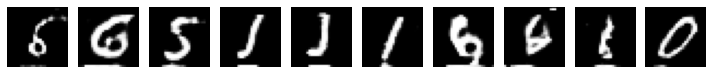

10501 [D loss: 0.677856, acc.: 67.19%] [G loss: 1.685861]
10502 [D loss: 0.455155, acc.: 79.69%] [G loss: 1.648933]
10503 [D loss: 0.517677, acc.: 71.88%] [G loss: 1.650657]
10504 [D loss: 0.435112, acc.: 83.59%] [G loss: 1.780292]
10505 [D loss: 0.513029, acc.: 76.56%] [G loss: 1.366428]
10506 [D loss: 0.533754, acc.: 71.88%] [G loss: 1.367138]
10507 [D loss: 0.461736, acc.: 78.12%] [G loss: 1.459960]
10508 [D loss: 0.462301, acc.: 78.12%] [G loss: 1.713332]
10509 [D loss: 0.639783, acc.: 69.53%] [G loss: 1.946318]
10510 [D loss: 0.548826, acc.: 76.56%] [G loss: 1.767572]
10511 [D loss: 0.493750, acc.: 75.78%] [G loss: 1.552933]
10512 [D loss: 0.581803, acc.: 68.75%] [G loss: 1.239159]
10513 [D loss: 0.650517, acc.: 62.50%] [G loss: 0.994624]
10514 [D loss: 0.577273, acc.: 71.09%] [G loss: 1.062908]
10515 [D loss: 0.506149, acc.: 70.31%] [G loss: 1.216542]
10516 [D loss: 0.563003, acc.: 74.22%] [G loss: 1.361344]
10517 [D loss: 0.461215, acc.: 76.56%] [G loss: 1.531936]
10518 [D loss:

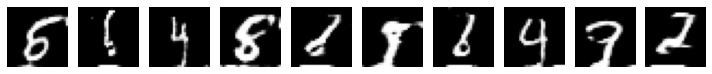

10601 [D loss: 0.462905, acc.: 74.22%] [G loss: 1.604646]
10602 [D loss: 0.371485, acc.: 82.03%] [G loss: 1.647481]
10603 [D loss: 0.448186, acc.: 78.12%] [G loss: 1.589803]
10604 [D loss: 0.448926, acc.: 80.47%] [G loss: 1.478652]
10605 [D loss: 0.360260, acc.: 85.94%] [G loss: 1.591250]
10606 [D loss: 0.404984, acc.: 83.59%] [G loss: 1.479954]
10607 [D loss: 0.413685, acc.: 82.81%] [G loss: 1.525030]
10608 [D loss: 0.422091, acc.: 81.25%] [G loss: 1.629870]
10609 [D loss: 0.389882, acc.: 84.38%] [G loss: 1.674721]
10610 [D loss: 0.396816, acc.: 80.47%] [G loss: 1.715576]
10611 [D loss: 0.420931, acc.: 82.03%] [G loss: 1.726807]
10612 [D loss: 0.467187, acc.: 79.69%] [G loss: 1.874282]
10613 [D loss: 0.530728, acc.: 74.22%] [G loss: 2.013945]
10614 [D loss: 0.419833, acc.: 78.91%] [G loss: 2.018831]
10615 [D loss: 0.487520, acc.: 76.56%] [G loss: 1.779710]
10616 [D loss: 0.481956, acc.: 78.12%] [G loss: 1.695262]
10617 [D loss: 0.469741, acc.: 74.22%] [G loss: 1.532024]
10618 [D loss:

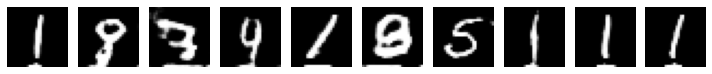

10701 [D loss: 0.363023, acc.: 82.03%] [G loss: 1.857358]
10702 [D loss: 0.461938, acc.: 78.91%] [G loss: 1.842389]
10703 [D loss: 0.475431, acc.: 75.00%] [G loss: 1.686026]
10704 [D loss: 0.487320, acc.: 75.78%] [G loss: 1.558711]
10705 [D loss: 0.552858, acc.: 72.66%] [G loss: 1.341163]
10706 [D loss: 0.423191, acc.: 77.34%] [G loss: 1.437025]
10707 [D loss: 0.477149, acc.: 78.12%] [G loss: 1.547003]
10708 [D loss: 0.430473, acc.: 78.12%] [G loss: 1.541535]
10709 [D loss: 0.426800, acc.: 81.25%] [G loss: 1.829446]
10710 [D loss: 0.456667, acc.: 75.00%] [G loss: 1.646858]
10711 [D loss: 0.489514, acc.: 75.78%] [G loss: 1.785579]
10712 [D loss: 0.347654, acc.: 85.94%] [G loss: 1.909490]
10713 [D loss: 0.483917, acc.: 75.78%] [G loss: 1.636224]
10714 [D loss: 0.489266, acc.: 78.12%] [G loss: 1.489182]
10715 [D loss: 0.575094, acc.: 64.84%] [G loss: 1.249434]
10716 [D loss: 0.513938, acc.: 77.34%] [G loss: 1.376160]
10717 [D loss: 0.447033, acc.: 78.91%] [G loss: 1.765005]
10718 [D loss:

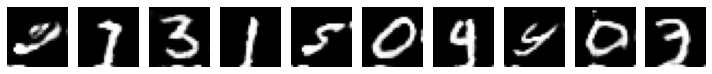

10801 [D loss: 0.466700, acc.: 75.78%] [G loss: 1.844344]
10802 [D loss: 0.554402, acc.: 71.09%] [G loss: 1.641611]
10803 [D loss: 0.497007, acc.: 78.91%] [G loss: 1.660767]
10804 [D loss: 0.388675, acc.: 81.25%] [G loss: 1.587642]
10805 [D loss: 0.364407, acc.: 85.16%] [G loss: 1.664349]
10806 [D loss: 0.368595, acc.: 82.03%] [G loss: 1.539517]
10807 [D loss: 0.546267, acc.: 78.12%] [G loss: 1.409706]
10808 [D loss: 0.427299, acc.: 83.59%] [G loss: 1.496743]
10809 [D loss: 0.447505, acc.: 78.12%] [G loss: 1.545646]
10810 [D loss: 0.356543, acc.: 85.16%] [G loss: 1.665394]
10811 [D loss: 0.416538, acc.: 80.47%] [G loss: 1.809875]
10812 [D loss: 0.336020, acc.: 86.72%] [G loss: 2.090162]
10813 [D loss: 0.426592, acc.: 80.47%] [G loss: 2.042425]
10814 [D loss: 0.382158, acc.: 85.16%] [G loss: 2.085981]
10815 [D loss: 0.446317, acc.: 80.47%] [G loss: 1.891035]
10816 [D loss: 0.427424, acc.: 81.25%] [G loss: 2.029118]
10817 [D loss: 0.399269, acc.: 84.38%] [G loss: 2.005529]
10818 [D loss:

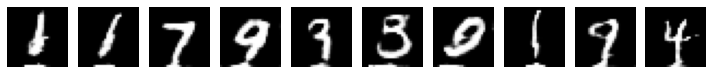

10901 [D loss: 0.356785, acc.: 87.50%] [G loss: 1.619231]
10902 [D loss: 0.423254, acc.: 82.03%] [G loss: 1.729180]
10903 [D loss: 0.393212, acc.: 84.38%] [G loss: 2.043832]
10904 [D loss: 0.490760, acc.: 73.44%] [G loss: 2.151311]
10905 [D loss: 0.519501, acc.: 72.66%] [G loss: 1.789377]
10906 [D loss: 0.454527, acc.: 75.78%] [G loss: 1.456789]
10907 [D loss: 0.361739, acc.: 82.03%] [G loss: 1.393644]
10908 [D loss: 0.377371, acc.: 82.03%] [G loss: 1.677864]
10909 [D loss: 0.373117, acc.: 85.16%] [G loss: 1.693208]
10910 [D loss: 0.381840, acc.: 80.47%] [G loss: 1.813466]
10911 [D loss: 0.354534, acc.: 85.16%] [G loss: 1.925180]
10912 [D loss: 0.450588, acc.: 80.47%] [G loss: 1.938715]
10913 [D loss: 0.403105, acc.: 82.03%] [G loss: 1.972220]
10914 [D loss: 0.347268, acc.: 87.50%] [G loss: 1.909144]
10915 [D loss: 0.385598, acc.: 84.38%] [G loss: 2.110090]
10916 [D loss: 0.440775, acc.: 83.59%] [G loss: 2.081914]
10917 [D loss: 0.433556, acc.: 79.69%] [G loss: 1.996855]
10918 [D loss:

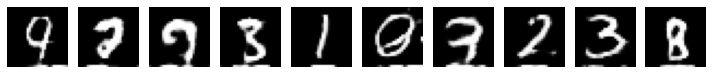

11001 [D loss: 0.413276, acc.: 82.03%] [G loss: 1.277204]
11002 [D loss: 0.524628, acc.: 78.12%] [G loss: 1.541535]
11003 [D loss: 0.509651, acc.: 78.12%] [G loss: 1.816008]
11004 [D loss: 0.534864, acc.: 70.31%] [G loss: 1.761399]
11005 [D loss: 0.543661, acc.: 75.00%] [G loss: 1.537172]
11006 [D loss: 0.599125, acc.: 67.97%] [G loss: 1.224036]
11007 [D loss: 0.468975, acc.: 78.91%] [G loss: 1.357812]
11008 [D loss: 0.443544, acc.: 77.34%] [G loss: 1.480825]
11009 [D loss: 0.380410, acc.: 85.94%] [G loss: 1.782354]
11010 [D loss: 0.470416, acc.: 78.12%] [G loss: 1.819901]
11011 [D loss: 0.445907, acc.: 82.03%] [G loss: 1.782699]
11012 [D loss: 0.501581, acc.: 71.88%] [G loss: 1.686570]
11013 [D loss: 0.415030, acc.: 82.03%] [G loss: 1.458113]
11014 [D loss: 0.384686, acc.: 81.25%] [G loss: 1.358044]
11015 [D loss: 0.397765, acc.: 82.81%] [G loss: 1.636516]
11016 [D loss: 0.362943, acc.: 84.38%] [G loss: 1.880142]
11017 [D loss: 0.391197, acc.: 80.47%] [G loss: 1.831877]
11018 [D loss:

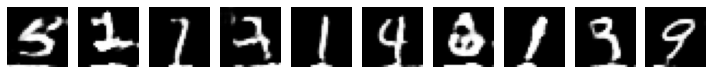

11101 [D loss: 0.411728, acc.: 78.91%] [G loss: 1.851758]
11102 [D loss: 0.399026, acc.: 82.81%] [G loss: 1.886219]
11103 [D loss: 0.362041, acc.: 82.81%] [G loss: 1.920311]
11104 [D loss: 0.289179, acc.: 91.41%] [G loss: 2.053218]
11105 [D loss: 0.504916, acc.: 73.44%] [G loss: 2.124152]
11106 [D loss: 0.347214, acc.: 82.81%] [G loss: 2.063733]
11107 [D loss: 0.356427, acc.: 85.94%] [G loss: 2.013887]
11108 [D loss: 0.311002, acc.: 85.16%] [G loss: 2.339154]
11109 [D loss: 0.417311, acc.: 82.03%] [G loss: 2.266215]
11110 [D loss: 0.390958, acc.: 82.81%] [G loss: 2.244735]
11111 [D loss: 0.414369, acc.: 81.25%] [G loss: 2.400757]
11112 [D loss: 0.411090, acc.: 81.25%] [G loss: 2.241343]
11113 [D loss: 0.430377, acc.: 77.34%] [G loss: 1.897395]
11114 [D loss: 0.476647, acc.: 75.78%] [G loss: 1.843563]
11115 [D loss: 0.370244, acc.: 79.69%] [G loss: 1.699429]
11116 [D loss: 0.424725, acc.: 75.78%] [G loss: 1.717712]
11117 [D loss: 0.440202, acc.: 81.25%] [G loss: 1.835210]
11118 [D loss:

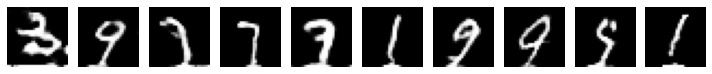

11201 [D loss: 0.428030, acc.: 78.12%] [G loss: 1.390063]
11202 [D loss: 0.469360, acc.: 77.34%] [G loss: 1.424482]
11203 [D loss: 0.295022, acc.: 92.19%] [G loss: 1.614267]
11204 [D loss: 0.403437, acc.: 84.38%] [G loss: 1.788914]
11205 [D loss: 0.440648, acc.: 82.81%] [G loss: 1.999770]
11206 [D loss: 0.452914, acc.: 76.56%] [G loss: 1.735024]
11207 [D loss: 0.415751, acc.: 79.69%] [G loss: 1.912582]
11208 [D loss: 0.416002, acc.: 81.25%] [G loss: 2.021077]
11209 [D loss: 0.311684, acc.: 87.50%] [G loss: 2.026173]
11210 [D loss: 0.457855, acc.: 78.12%] [G loss: 1.983699]
11211 [D loss: 0.448903, acc.: 78.12%] [G loss: 1.726949]
11212 [D loss: 0.414618, acc.: 81.25%] [G loss: 1.776083]
11213 [D loss: 0.455877, acc.: 80.47%] [G loss: 1.911581]
11214 [D loss: 0.526295, acc.: 75.00%] [G loss: 1.947419]
11215 [D loss: 0.512660, acc.: 75.78%] [G loss: 2.091977]
11216 [D loss: 0.446093, acc.: 78.91%] [G loss: 2.069087]
11217 [D loss: 0.482038, acc.: 76.56%] [G loss: 1.850386]
11218 [D loss:

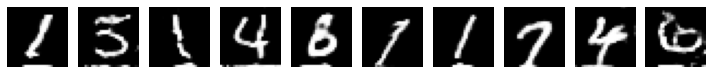

11301 [D loss: 0.503069, acc.: 74.22%] [G loss: 1.683322]
11302 [D loss: 0.463070, acc.: 80.47%] [G loss: 1.722905]
11303 [D loss: 0.485965, acc.: 74.22%] [G loss: 2.067104]
11304 [D loss: 0.342273, acc.: 85.94%] [G loss: 2.408999]
11305 [D loss: 0.405179, acc.: 78.91%] [G loss: 2.272372]
11306 [D loss: 0.449355, acc.: 80.47%] [G loss: 1.929850]
11307 [D loss: 0.508705, acc.: 76.56%] [G loss: 1.731415]
11308 [D loss: 0.424006, acc.: 81.25%] [G loss: 1.655375]
11309 [D loss: 0.522427, acc.: 76.56%] [G loss: 1.868664]
11310 [D loss: 0.391464, acc.: 85.94%] [G loss: 2.162372]
11311 [D loss: 0.479969, acc.: 76.56%] [G loss: 2.128217]
11312 [D loss: 0.476231, acc.: 77.34%] [G loss: 1.791990]
11313 [D loss: 0.535992, acc.: 75.78%] [G loss: 1.711333]
11314 [D loss: 0.419765, acc.: 83.59%] [G loss: 1.877973]
11315 [D loss: 0.382797, acc.: 82.81%] [G loss: 1.811865]
11316 [D loss: 0.459850, acc.: 76.56%] [G loss: 1.616309]
11317 [D loss: 0.546260, acc.: 71.09%] [G loss: 1.472780]
11318 [D loss:

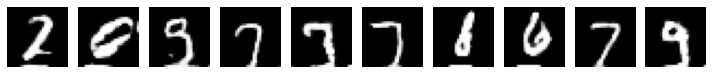

11401 [D loss: 0.404887, acc.: 78.91%] [G loss: 2.011151]
11402 [D loss: 0.503674, acc.: 75.78%] [G loss: 2.255296]
11403 [D loss: 0.421421, acc.: 78.91%] [G loss: 2.220632]
11404 [D loss: 0.598861, acc.: 72.66%] [G loss: 1.558373]
11405 [D loss: 0.510054, acc.: 74.22%] [G loss: 1.187697]
11406 [D loss: 0.562951, acc.: 69.53%] [G loss: 1.244581]
11407 [D loss: 0.396928, acc.: 79.69%] [G loss: 1.477154]
11408 [D loss: 0.494300, acc.: 75.00%] [G loss: 1.883651]
11409 [D loss: 0.430837, acc.: 77.34%] [G loss: 2.252129]
11410 [D loss: 0.575867, acc.: 71.09%] [G loss: 2.055555]
11411 [D loss: 0.409201, acc.: 85.16%] [G loss: 1.693436]
11412 [D loss: 0.499691, acc.: 72.66%] [G loss: 1.376431]
11413 [D loss: 0.443184, acc.: 78.91%] [G loss: 1.316866]
11414 [D loss: 0.444167, acc.: 79.69%] [G loss: 1.393986]
11415 [D loss: 0.434971, acc.: 81.25%] [G loss: 1.655343]
11416 [D loss: 0.428568, acc.: 82.81%] [G loss: 1.976995]
11417 [D loss: 0.572223, acc.: 75.00%] [G loss: 1.769410]
11418 [D loss:

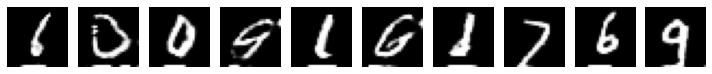

11501 [D loss: 0.399598, acc.: 86.72%] [G loss: 2.020403]
11502 [D loss: 0.454577, acc.: 79.69%] [G loss: 1.862207]
11503 [D loss: 0.475499, acc.: 74.22%] [G loss: 1.798493]
11504 [D loss: 0.388828, acc.: 83.59%] [G loss: 1.902166]
11505 [D loss: 0.321767, acc.: 86.72%] [G loss: 1.743707]
11506 [D loss: 0.367341, acc.: 83.59%] [G loss: 1.820639]
11507 [D loss: 0.471011, acc.: 76.56%] [G loss: 1.813030]
11508 [D loss: 0.411155, acc.: 76.56%] [G loss: 1.881127]
11509 [D loss: 0.431413, acc.: 78.12%] [G loss: 1.990734]
11510 [D loss: 0.386874, acc.: 82.03%] [G loss: 2.232259]
11511 [D loss: 0.473538, acc.: 77.34%] [G loss: 2.058862]
11512 [D loss: 0.615471, acc.: 69.53%] [G loss: 1.680622]
11513 [D loss: 0.572175, acc.: 67.19%] [G loss: 1.818282]
11514 [D loss: 0.417198, acc.: 81.25%] [G loss: 1.731968]
11515 [D loss: 0.324014, acc.: 87.50%] [G loss: 1.925613]
11516 [D loss: 0.404841, acc.: 78.91%] [G loss: 1.901257]
11517 [D loss: 0.388161, acc.: 85.16%] [G loss: 1.741958]
11518 [D loss:

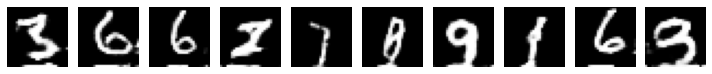

11601 [D loss: 0.480441, acc.: 74.22%] [G loss: 1.557022]
11602 [D loss: 0.453371, acc.: 74.22%] [G loss: 1.562083]
11603 [D loss: 0.459280, acc.: 76.56%] [G loss: 1.455655]
11604 [D loss: 0.485380, acc.: 75.78%] [G loss: 1.623139]
11605 [D loss: 0.434571, acc.: 75.00%] [G loss: 1.686930]
11606 [D loss: 0.351073, acc.: 85.16%] [G loss: 1.933633]
11607 [D loss: 0.420792, acc.: 78.12%] [G loss: 1.777563]
11608 [D loss: 0.481847, acc.: 78.12%] [G loss: 1.893904]
11609 [D loss: 0.490428, acc.: 77.34%] [G loss: 1.686206]
11610 [D loss: 0.436807, acc.: 78.12%] [G loss: 1.469113]
11611 [D loss: 0.380742, acc.: 80.47%] [G loss: 1.707599]
11612 [D loss: 0.486435, acc.: 73.44%] [G loss: 1.739281]
11613 [D loss: 0.382366, acc.: 82.81%] [G loss: 2.009864]
11614 [D loss: 0.471472, acc.: 79.69%] [G loss: 2.028324]
11615 [D loss: 0.442578, acc.: 80.47%] [G loss: 1.886404]
11616 [D loss: 0.431379, acc.: 82.81%] [G loss: 1.771859]
11617 [D loss: 0.519474, acc.: 70.31%] [G loss: 1.388640]
11618 [D loss:

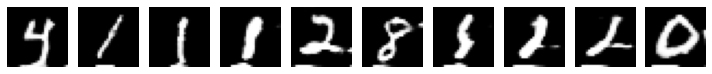

11701 [D loss: 0.317635, acc.: 85.94%] [G loss: 1.733405]
11702 [D loss: 0.492210, acc.: 74.22%] [G loss: 1.816441]
11703 [D loss: 0.453328, acc.: 78.12%] [G loss: 1.948771]
11704 [D loss: 0.394101, acc.: 81.25%] [G loss: 1.883977]
11705 [D loss: 0.450463, acc.: 77.34%] [G loss: 1.639623]
11706 [D loss: 0.493328, acc.: 75.00%] [G loss: 1.607633]
11707 [D loss: 0.517928, acc.: 73.44%] [G loss: 1.645949]
11708 [D loss: 0.335997, acc.: 85.94%] [G loss: 1.723299]
11709 [D loss: 0.529186, acc.: 74.22%] [G loss: 1.777710]
11710 [D loss: 0.482536, acc.: 74.22%] [G loss: 1.820150]
11711 [D loss: 0.504646, acc.: 75.78%] [G loss: 1.715519]
11712 [D loss: 0.501808, acc.: 72.66%] [G loss: 1.844871]
11713 [D loss: 0.467619, acc.: 77.34%] [G loss: 1.695575]
11714 [D loss: 0.589702, acc.: 67.19%] [G loss: 1.713878]
11715 [D loss: 0.435761, acc.: 78.12%] [G loss: 1.633567]
11716 [D loss: 0.515317, acc.: 71.88%] [G loss: 1.767681]
11717 [D loss: 0.398992, acc.: 83.59%] [G loss: 1.814414]
11718 [D loss:

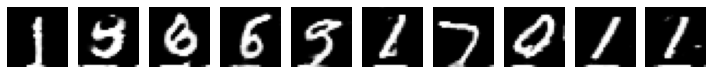

11801 [D loss: 0.468274, acc.: 75.00%] [G loss: 1.570993]
11802 [D loss: 0.527908, acc.: 74.22%] [G loss: 1.672335]
11803 [D loss: 0.474955, acc.: 75.00%] [G loss: 1.641407]
11804 [D loss: 0.492745, acc.: 75.78%] [G loss: 1.657223]
11805 [D loss: 0.514715, acc.: 78.12%] [G loss: 1.494176]
11806 [D loss: 0.486748, acc.: 75.78%] [G loss: 1.466789]
11807 [D loss: 0.486211, acc.: 81.25%] [G loss: 1.550560]
11808 [D loss: 0.407300, acc.: 82.81%] [G loss: 2.061405]
11809 [D loss: 0.391577, acc.: 82.81%] [G loss: 2.028046]
11810 [D loss: 0.463614, acc.: 78.91%] [G loss: 1.785286]
11811 [D loss: 0.485498, acc.: 77.34%] [G loss: 1.653162]
11812 [D loss: 0.521185, acc.: 75.00%] [G loss: 1.563791]
11813 [D loss: 0.525725, acc.: 75.78%] [G loss: 1.757314]
11814 [D loss: 0.451828, acc.: 76.56%] [G loss: 1.879934]
11815 [D loss: 0.428131, acc.: 78.91%] [G loss: 1.732255]
11816 [D loss: 0.356768, acc.: 87.50%] [G loss: 1.882682]
11817 [D loss: 0.467564, acc.: 79.69%] [G loss: 1.527626]
11818 [D loss:

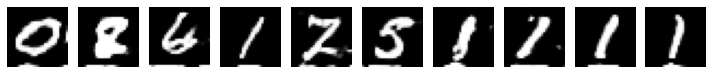

11901 [D loss: 0.459466, acc.: 73.44%] [G loss: 1.248425]
11902 [D loss: 0.469529, acc.: 75.00%] [G loss: 1.176853]
11903 [D loss: 0.533122, acc.: 68.75%] [G loss: 1.421086]
11904 [D loss: 0.417979, acc.: 78.91%] [G loss: 1.891168]
11905 [D loss: 0.505999, acc.: 75.00%] [G loss: 2.006806]
11906 [D loss: 0.523741, acc.: 75.78%] [G loss: 1.738738]
11907 [D loss: 0.530454, acc.: 75.00%] [G loss: 1.537536]
11908 [D loss: 0.523291, acc.: 73.44%] [G loss: 1.537392]
11909 [D loss: 0.433241, acc.: 78.12%] [G loss: 1.689323]
11910 [D loss: 0.430646, acc.: 81.25%] [G loss: 1.637533]
11911 [D loss: 0.493308, acc.: 76.56%] [G loss: 1.754216]
11912 [D loss: 0.563899, acc.: 68.75%] [G loss: 1.577246]
11913 [D loss: 0.465633, acc.: 75.78%] [G loss: 1.679981]
11914 [D loss: 0.377447, acc.: 84.38%] [G loss: 1.827557]
11915 [D loss: 0.521029, acc.: 75.78%] [G loss: 1.655314]
11916 [D loss: 0.425774, acc.: 78.91%] [G loss: 1.557337]
11917 [D loss: 0.441915, acc.: 80.47%] [G loss: 1.428513]
11918 [D loss:

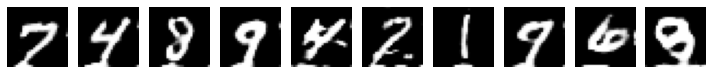

12001 [D loss: 0.476038, acc.: 78.12%] [G loss: 1.631779]
12002 [D loss: 0.445594, acc.: 76.56%] [G loss: 1.543644]
12003 [D loss: 0.418518, acc.: 79.69%] [G loss: 1.679450]
12004 [D loss: 0.430141, acc.: 82.03%] [G loss: 1.781249]
12005 [D loss: 0.438714, acc.: 78.91%] [G loss: 1.750000]
12006 [D loss: 0.386581, acc.: 84.38%] [G loss: 2.069576]
12007 [D loss: 0.464311, acc.: 81.25%] [G loss: 2.000234]
12008 [D loss: 0.404135, acc.: 78.12%] [G loss: 1.730611]
12009 [D loss: 0.528800, acc.: 74.22%] [G loss: 1.617364]
12010 [D loss: 0.432757, acc.: 79.69%] [G loss: 1.720438]
12011 [D loss: 0.396806, acc.: 82.03%] [G loss: 1.705503]
12012 [D loss: 0.472153, acc.: 75.00%] [G loss: 1.871450]
12013 [D loss: 0.459559, acc.: 77.34%] [G loss: 1.834043]
12014 [D loss: 0.491891, acc.: 75.00%] [G loss: 1.694171]
12015 [D loss: 0.412994, acc.: 78.91%] [G loss: 1.549932]
12016 [D loss: 0.472311, acc.: 78.12%] [G loss: 1.553227]
12017 [D loss: 0.446134, acc.: 77.34%] [G loss: 1.590467]
12018 [D loss:

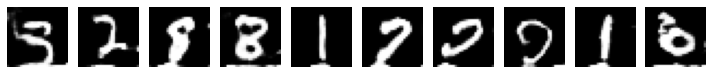

12101 [D loss: 0.517479, acc.: 74.22%] [G loss: 1.825620]
12102 [D loss: 0.450527, acc.: 76.56%] [G loss: 1.798439]
12103 [D loss: 0.526375, acc.: 73.44%] [G loss: 1.692420]
12104 [D loss: 0.475666, acc.: 79.69%] [G loss: 1.547288]
12105 [D loss: 0.469843, acc.: 75.78%] [G loss: 1.380808]
12106 [D loss: 0.385790, acc.: 82.81%] [G loss: 1.578648]
12107 [D loss: 0.392430, acc.: 78.12%] [G loss: 1.782883]
12108 [D loss: 0.434690, acc.: 78.91%] [G loss: 1.961071]
12109 [D loss: 0.426992, acc.: 78.12%] [G loss: 1.751332]
12110 [D loss: 0.465003, acc.: 75.78%] [G loss: 1.649982]
12111 [D loss: 0.391896, acc.: 84.38%] [G loss: 1.450944]
12112 [D loss: 0.468026, acc.: 77.34%] [G loss: 1.495572]
12113 [D loss: 0.416931, acc.: 78.12%] [G loss: 1.886219]
12114 [D loss: 0.340477, acc.: 85.94%] [G loss: 2.113089]
12115 [D loss: 0.502021, acc.: 75.00%] [G loss: 1.754686]
12116 [D loss: 0.379192, acc.: 81.25%] [G loss: 1.558255]
12117 [D loss: 0.458142, acc.: 77.34%] [G loss: 1.600904]
12118 [D loss:

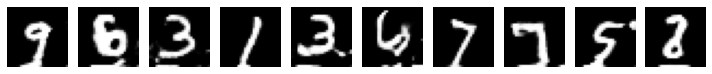

12201 [D loss: 0.457702, acc.: 82.03%] [G loss: 2.166944]
12202 [D loss: 0.421573, acc.: 81.25%] [G loss: 1.998347]
12203 [D loss: 0.402229, acc.: 81.25%] [G loss: 1.572730]
12204 [D loss: 0.387166, acc.: 80.47%] [G loss: 1.608150]
12205 [D loss: 0.480775, acc.: 73.44%] [G loss: 1.500470]
12206 [D loss: 0.473818, acc.: 78.12%] [G loss: 1.899162]
12207 [D loss: 0.453785, acc.: 76.56%] [G loss: 2.007988]
12208 [D loss: 0.421855, acc.: 82.03%] [G loss: 1.826933]
12209 [D loss: 0.521860, acc.: 76.56%] [G loss: 1.626462]
12210 [D loss: 0.517390, acc.: 74.22%] [G loss: 1.598652]
12211 [D loss: 0.491548, acc.: 77.34%] [G loss: 1.586424]
12212 [D loss: 0.477837, acc.: 78.12%] [G loss: 1.440313]
12213 [D loss: 0.537310, acc.: 68.75%] [G loss: 1.314173]
12214 [D loss: 0.490773, acc.: 72.66%] [G loss: 1.445598]
12215 [D loss: 0.414044, acc.: 83.59%] [G loss: 1.765110]
12216 [D loss: 0.494707, acc.: 76.56%] [G loss: 1.945739]
12217 [D loss: 0.558311, acc.: 71.88%] [G loss: 1.834615]
12218 [D loss:

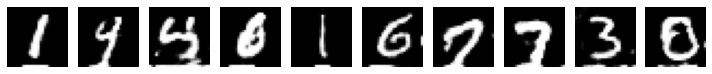

12301 [D loss: 0.454501, acc.: 81.25%] [G loss: 1.483669]
12302 [D loss: 0.412229, acc.: 81.25%] [G loss: 1.567628]
12303 [D loss: 0.415977, acc.: 82.03%] [G loss: 1.876628]
12304 [D loss: 0.346795, acc.: 82.81%] [G loss: 1.838981]
12305 [D loss: 0.419372, acc.: 78.91%] [G loss: 1.711685]
12306 [D loss: 0.514187, acc.: 72.66%] [G loss: 1.521074]
12307 [D loss: 0.520043, acc.: 78.12%] [G loss: 1.858459]
12308 [D loss: 0.409906, acc.: 79.69%] [G loss: 1.951900]
12309 [D loss: 0.477676, acc.: 79.69%] [G loss: 2.035319]
12310 [D loss: 0.603208, acc.: 73.44%] [G loss: 1.583138]
12311 [D loss: 0.405249, acc.: 82.03%] [G loss: 1.522500]
12312 [D loss: 0.535540, acc.: 76.56%] [G loss: 1.674865]
12313 [D loss: 0.392987, acc.: 82.81%] [G loss: 1.943389]
12314 [D loss: 0.506766, acc.: 78.91%] [G loss: 1.851027]
12315 [D loss: 0.450442, acc.: 79.69%] [G loss: 1.885210]
12316 [D loss: 0.360974, acc.: 85.94%] [G loss: 1.613510]
12317 [D loss: 0.449614, acc.: 77.34%] [G loss: 1.480274]
12318 [D loss:

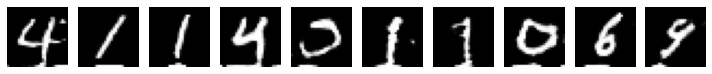

12401 [D loss: 0.522650, acc.: 74.22%] [G loss: 1.707216]
12402 [D loss: 0.486528, acc.: 77.34%] [G loss: 1.821922]
12403 [D loss: 0.523038, acc.: 71.88%] [G loss: 1.498930]
12404 [D loss: 0.422881, acc.: 78.91%] [G loss: 1.496929]
12405 [D loss: 0.401411, acc.: 82.03%] [G loss: 1.665577]
12406 [D loss: 0.382689, acc.: 84.38%] [G loss: 1.808765]
12407 [D loss: 0.369332, acc.: 79.69%] [G loss: 1.819149]
12408 [D loss: 0.527196, acc.: 70.31%] [G loss: 1.715796]
12409 [D loss: 0.460634, acc.: 78.12%] [G loss: 1.551004]
12410 [D loss: 0.404903, acc.: 80.47%] [G loss: 1.635346]
12411 [D loss: 0.353050, acc.: 82.03%] [G loss: 1.865635]
12412 [D loss: 0.374034, acc.: 82.03%] [G loss: 1.723538]
12413 [D loss: 0.457271, acc.: 78.91%] [G loss: 1.752480]
12414 [D loss: 0.339864, acc.: 84.38%] [G loss: 1.751439]
12415 [D loss: 0.478977, acc.: 70.31%] [G loss: 1.369511]
12416 [D loss: 0.381114, acc.: 82.81%] [G loss: 1.541387]
12417 [D loss: 0.446694, acc.: 77.34%] [G loss: 1.951088]
12418 [D loss:

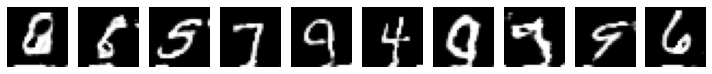

12501 [D loss: 0.514531, acc.: 76.56%] [G loss: 1.773721]
12502 [D loss: 0.378404, acc.: 84.38%] [G loss: 1.835616]
12503 [D loss: 0.394666, acc.: 82.03%] [G loss: 1.651462]
12504 [D loss: 0.489070, acc.: 75.00%] [G loss: 1.546694]
12505 [D loss: 0.408922, acc.: 80.47%] [G loss: 1.570535]
12506 [D loss: 0.451611, acc.: 82.03%] [G loss: 1.690325]
12507 [D loss: 0.510489, acc.: 72.66%] [G loss: 1.701064]
12508 [D loss: 0.455350, acc.: 79.69%] [G loss: 1.577406]
12509 [D loss: 0.545917, acc.: 67.19%] [G loss: 1.701438]
12510 [D loss: 0.403379, acc.: 80.47%] [G loss: 1.539506]
12511 [D loss: 0.467962, acc.: 77.34%] [G loss: 1.772539]
12512 [D loss: 0.486346, acc.: 76.56%] [G loss: 1.448208]
12513 [D loss: 0.436133, acc.: 77.34%] [G loss: 1.611785]
12514 [D loss: 0.348609, acc.: 84.38%] [G loss: 1.729138]
12515 [D loss: 0.432646, acc.: 79.69%] [G loss: 1.695071]
12516 [D loss: 0.443669, acc.: 79.69%] [G loss: 1.765851]
12517 [D loss: 0.395165, acc.: 85.16%] [G loss: 1.797312]
12518 [D loss:

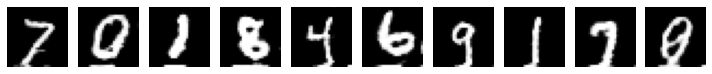

12601 [D loss: 0.437971, acc.: 79.69%] [G loss: 2.099908]
12602 [D loss: 0.440861, acc.: 75.00%] [G loss: 1.946874]
12603 [D loss: 0.306945, acc.: 89.84%] [G loss: 1.827337]
12604 [D loss: 0.431800, acc.: 78.12%] [G loss: 1.781266]
12605 [D loss: 0.400324, acc.: 78.91%] [G loss: 1.865750]
12606 [D loss: 0.313466, acc.: 85.94%] [G loss: 2.268262]
12607 [D loss: 0.376121, acc.: 82.81%] [G loss: 2.354986]
12608 [D loss: 0.473338, acc.: 73.44%] [G loss: 1.972900]
12609 [D loss: 0.426173, acc.: 78.91%] [G loss: 1.858848]
12610 [D loss: 0.352417, acc.: 82.81%] [G loss: 1.800629]
12611 [D loss: 0.432819, acc.: 79.69%] [G loss: 2.138459]
12612 [D loss: 0.450945, acc.: 81.25%] [G loss: 2.095503]
12613 [D loss: 0.482605, acc.: 78.91%] [G loss: 2.056221]
12614 [D loss: 0.415831, acc.: 81.25%] [G loss: 2.118107]
12615 [D loss: 0.412612, acc.: 78.12%] [G loss: 1.992165]
12616 [D loss: 0.517290, acc.: 71.88%] [G loss: 1.903552]
12617 [D loss: 0.532477, acc.: 75.78%] [G loss: 2.144328]
12618 [D loss:

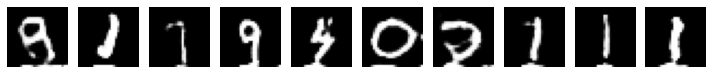

12701 [D loss: 0.461617, acc.: 81.25%] [G loss: 1.626099]
12702 [D loss: 0.386710, acc.: 81.25%] [G loss: 1.604733]
12703 [D loss: 0.531017, acc.: 70.31%] [G loss: 1.838541]
12704 [D loss: 0.408625, acc.: 81.25%] [G loss: 2.008783]
12705 [D loss: 0.576063, acc.: 75.00%] [G loss: 1.937231]
12706 [D loss: 0.646016, acc.: 68.75%] [G loss: 1.490315]
12707 [D loss: 0.541050, acc.: 78.12%] [G loss: 1.310140]
12708 [D loss: 0.462175, acc.: 78.91%] [G loss: 1.665704]
12709 [D loss: 0.434929, acc.: 78.91%] [G loss: 2.112966]
12710 [D loss: 0.569635, acc.: 72.66%] [G loss: 1.793060]
12711 [D loss: 0.412263, acc.: 82.03%] [G loss: 1.506684]
12712 [D loss: 0.430600, acc.: 78.12%] [G loss: 1.576125]
12713 [D loss: 0.430087, acc.: 82.03%] [G loss: 1.511900]
12714 [D loss: 0.436306, acc.: 80.47%] [G loss: 1.712848]
12715 [D loss: 0.421590, acc.: 81.25%] [G loss: 1.773090]
12716 [D loss: 0.391336, acc.: 81.25%] [G loss: 1.998778]
12717 [D loss: 0.415939, acc.: 83.59%] [G loss: 1.882313]
12718 [D loss:

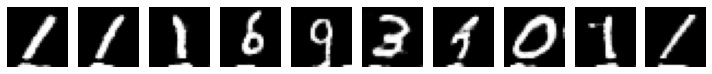

12801 [D loss: 0.474234, acc.: 77.34%] [G loss: 1.487786]
12802 [D loss: 0.409050, acc.: 82.03%] [G loss: 1.714817]
12803 [D loss: 0.446463, acc.: 79.69%] [G loss: 1.880010]
12804 [D loss: 0.433121, acc.: 77.34%] [G loss: 1.985875]
12805 [D loss: 0.501852, acc.: 76.56%] [G loss: 1.881457]
12806 [D loss: 0.400547, acc.: 82.81%] [G loss: 1.799907]
12807 [D loss: 0.403548, acc.: 82.81%] [G loss: 1.862499]
12808 [D loss: 0.489696, acc.: 74.22%] [G loss: 1.575140]
12809 [D loss: 0.425976, acc.: 82.03%] [G loss: 1.558586]
12810 [D loss: 0.419380, acc.: 75.78%] [G loss: 1.891061]
12811 [D loss: 0.494347, acc.: 78.91%] [G loss: 1.976959]
12812 [D loss: 0.398460, acc.: 82.81%] [G loss: 2.158657]
12813 [D loss: 0.459312, acc.: 75.78%] [G loss: 1.848760]
12814 [D loss: 0.416320, acc.: 82.03%] [G loss: 1.596907]
12815 [D loss: 0.415416, acc.: 78.91%] [G loss: 1.444551]
12816 [D loss: 0.501555, acc.: 77.34%] [G loss: 1.583844]
12817 [D loss: 0.434547, acc.: 78.91%] [G loss: 1.948795]
12818 [D loss:

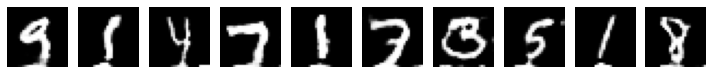

12901 [D loss: 0.391111, acc.: 82.81%] [G loss: 2.165357]
12902 [D loss: 0.431762, acc.: 80.47%] [G loss: 1.909651]
12903 [D loss: 0.493267, acc.: 74.22%] [G loss: 1.797681]
12904 [D loss: 0.390690, acc.: 78.91%] [G loss: 1.848298]
12905 [D loss: 0.366315, acc.: 84.38%] [G loss: 2.066218]
12906 [D loss: 0.476427, acc.: 76.56%] [G loss: 2.006808]
12907 [D loss: 0.356080, acc.: 88.28%] [G loss: 2.114005]
12908 [D loss: 0.449031, acc.: 79.69%] [G loss: 2.048271]
12909 [D loss: 0.376321, acc.: 84.38%] [G loss: 1.831102]
12910 [D loss: 0.466490, acc.: 76.56%] [G loss: 1.994742]
12911 [D loss: 0.384998, acc.: 82.03%] [G loss: 2.071177]
12912 [D loss: 0.504909, acc.: 75.78%] [G loss: 2.017777]
12913 [D loss: 0.415271, acc.: 80.47%] [G loss: 1.987908]
12914 [D loss: 0.563382, acc.: 76.56%] [G loss: 1.716774]
12915 [D loss: 0.437147, acc.: 78.12%] [G loss: 1.547981]
12916 [D loss: 0.440283, acc.: 78.12%] [G loss: 1.589288]
12917 [D loss: 0.463082, acc.: 78.91%] [G loss: 1.905836]
12918 [D loss:

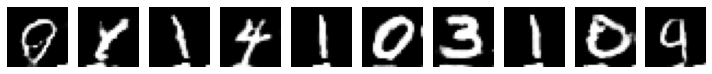

13001 [D loss: 0.517894, acc.: 77.34%] [G loss: 1.604059]
13002 [D loss: 0.348337, acc.: 85.94%] [G loss: 1.717906]
13003 [D loss: 0.523877, acc.: 75.78%] [G loss: 1.742932]
13004 [D loss: 0.384044, acc.: 83.59%] [G loss: 1.611311]
13005 [D loss: 0.413943, acc.: 82.81%] [G loss: 1.843609]
13006 [D loss: 0.440687, acc.: 79.69%] [G loss: 1.813042]
13007 [D loss: 0.482583, acc.: 75.00%] [G loss: 1.514265]
13008 [D loss: 0.375935, acc.: 82.81%] [G loss: 1.911790]
13009 [D loss: 0.535274, acc.: 71.09%] [G loss: 1.847819]
13010 [D loss: 0.437675, acc.: 77.34%] [G loss: 1.912836]
13011 [D loss: 0.414955, acc.: 78.91%] [G loss: 1.824530]
13012 [D loss: 0.435415, acc.: 82.03%] [G loss: 1.701452]
13013 [D loss: 0.423082, acc.: 79.69%] [G loss: 1.660089]
13014 [D loss: 0.455582, acc.: 78.91%] [G loss: 1.994324]
13015 [D loss: 0.448552, acc.: 82.03%] [G loss: 1.946762]
13016 [D loss: 0.422082, acc.: 84.38%] [G loss: 2.034999]
13017 [D loss: 0.360599, acc.: 82.03%] [G loss: 1.864183]
13018 [D loss:

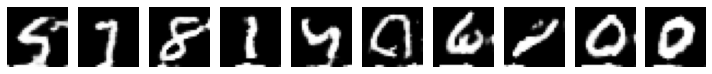

13101 [D loss: 0.437865, acc.: 78.91%] [G loss: 2.055830]
13102 [D loss: 0.505073, acc.: 73.44%] [G loss: 1.767429]
13103 [D loss: 0.457214, acc.: 79.69%] [G loss: 1.496205]
13104 [D loss: 0.541827, acc.: 77.34%] [G loss: 1.687448]
13105 [D loss: 0.381658, acc.: 83.59%] [G loss: 1.986411]
13106 [D loss: 0.459372, acc.: 75.78%] [G loss: 2.169832]
13107 [D loss: 0.444424, acc.: 75.78%] [G loss: 1.797886]
13108 [D loss: 0.494733, acc.: 73.44%] [G loss: 1.583712]
13109 [D loss: 0.552575, acc.: 78.12%] [G loss: 1.734367]
13110 [D loss: 0.397239, acc.: 84.38%] [G loss: 1.894277]
13111 [D loss: 0.482273, acc.: 75.00%] [G loss: 1.903273]
13112 [D loss: 0.371649, acc.: 84.38%] [G loss: 1.620644]
13113 [D loss: 0.373109, acc.: 82.03%] [G loss: 1.375943]
13114 [D loss: 0.481580, acc.: 75.00%] [G loss: 1.339239]
13115 [D loss: 0.399825, acc.: 80.47%] [G loss: 1.773708]
13116 [D loss: 0.513075, acc.: 73.44%] [G loss: 1.797566]
13117 [D loss: 0.433422, acc.: 76.56%] [G loss: 1.947783]
13118 [D loss:

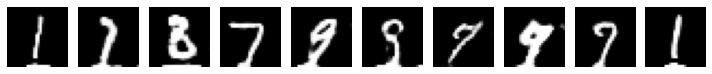

13201 [D loss: 0.444354, acc.: 81.25%] [G loss: 1.723172]
13202 [D loss: 0.504730, acc.: 74.22%] [G loss: 1.777724]
13203 [D loss: 0.396949, acc.: 81.25%] [G loss: 1.774530]
13204 [D loss: 0.436233, acc.: 80.47%] [G loss: 1.831031]
13205 [D loss: 0.381543, acc.: 84.38%] [G loss: 1.591107]
13206 [D loss: 0.472468, acc.: 77.34%] [G loss: 1.548957]
13207 [D loss: 0.439421, acc.: 80.47%] [G loss: 1.705759]
13208 [D loss: 0.346272, acc.: 85.94%] [G loss: 1.880708]
13209 [D loss: 0.365021, acc.: 82.81%] [G loss: 2.106054]
13210 [D loss: 0.435539, acc.: 78.12%] [G loss: 1.940410]
13211 [D loss: 0.456900, acc.: 78.91%] [G loss: 2.269887]
13212 [D loss: 0.376088, acc.: 83.59%] [G loss: 2.025851]
13213 [D loss: 0.447598, acc.: 85.16%] [G loss: 1.699188]
13214 [D loss: 0.371565, acc.: 84.38%] [G loss: 1.738230]
13215 [D loss: 0.388782, acc.: 84.38%] [G loss: 1.874034]
13216 [D loss: 0.467867, acc.: 78.91%] [G loss: 2.118751]
13217 [D loss: 0.587107, acc.: 75.00%] [G loss: 2.209103]
13218 [D loss:

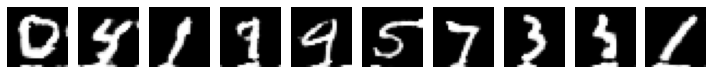

13301 [D loss: 0.492077, acc.: 75.00%] [G loss: 1.673920]
13302 [D loss: 0.460815, acc.: 76.56%] [G loss: 1.494119]
13303 [D loss: 0.459059, acc.: 81.25%] [G loss: 1.896255]
13304 [D loss: 0.373361, acc.: 82.03%] [G loss: 1.883670]
13305 [D loss: 0.591673, acc.: 69.53%] [G loss: 1.805370]
13306 [D loss: 0.340021, acc.: 85.16%] [G loss: 1.870352]
13307 [D loss: 0.460064, acc.: 79.69%] [G loss: 1.812796]
13308 [D loss: 0.485694, acc.: 74.22%] [G loss: 1.718062]
13309 [D loss: 0.525000, acc.: 74.22%] [G loss: 1.551687]
13310 [D loss: 0.447155, acc.: 76.56%] [G loss: 1.676432]
13311 [D loss: 0.496791, acc.: 76.56%] [G loss: 1.794683]
13312 [D loss: 0.467703, acc.: 73.44%] [G loss: 1.874974]
13313 [D loss: 0.513697, acc.: 71.09%] [G loss: 1.747726]
13314 [D loss: 0.435358, acc.: 79.69%] [G loss: 1.667787]
13315 [D loss: 0.544506, acc.: 74.22%] [G loss: 1.607281]
13316 [D loss: 0.440697, acc.: 80.47%] [G loss: 1.834904]
13317 [D loss: 0.463163, acc.: 78.91%] [G loss: 2.004399]
13318 [D loss:

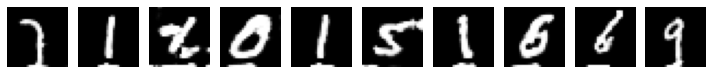

13401 [D loss: 0.400045, acc.: 82.03%] [G loss: 2.013273]
13402 [D loss: 0.424417, acc.: 82.03%] [G loss: 1.829637]
13403 [D loss: 0.497931, acc.: 76.56%] [G loss: 1.468971]
13404 [D loss: 0.492194, acc.: 78.91%] [G loss: 1.499784]
13405 [D loss: 0.496392, acc.: 72.66%] [G loss: 1.923081]
13406 [D loss: 0.359286, acc.: 82.03%] [G loss: 2.011608]
13407 [D loss: 0.454275, acc.: 74.22%] [G loss: 1.770257]
13408 [D loss: 0.446636, acc.: 76.56%] [G loss: 1.666157]
13409 [D loss: 0.431103, acc.: 80.47%] [G loss: 1.527670]
13410 [D loss: 0.400563, acc.: 82.81%] [G loss: 1.529623]
13411 [D loss: 0.452353, acc.: 77.34%] [G loss: 1.706301]
13412 [D loss: 0.524581, acc.: 72.66%] [G loss: 1.487628]
13413 [D loss: 0.484964, acc.: 75.78%] [G loss: 1.386321]
13414 [D loss: 0.439727, acc.: 82.03%] [G loss: 1.403126]
13415 [D loss: 0.471672, acc.: 76.56%] [G loss: 1.526076]
13416 [D loss: 0.434996, acc.: 78.91%] [G loss: 1.710012]
13417 [D loss: 0.473243, acc.: 78.12%] [G loss: 2.017205]
13418 [D loss:

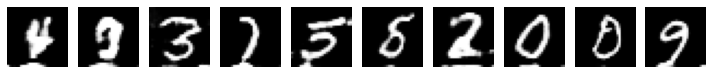

13501 [D loss: 0.556717, acc.: 69.53%] [G loss: 1.690219]
13502 [D loss: 0.451619, acc.: 77.34%] [G loss: 1.428004]
13503 [D loss: 0.462985, acc.: 75.00%] [G loss: 1.301982]
13504 [D loss: 0.453717, acc.: 74.22%] [G loss: 1.201298]
13505 [D loss: 0.432447, acc.: 82.03%] [G loss: 1.608665]
13506 [D loss: 0.522915, acc.: 72.66%] [G loss: 1.787199]
13507 [D loss: 0.420213, acc.: 79.69%] [G loss: 1.738529]
13508 [D loss: 0.497875, acc.: 76.56%] [G loss: 1.620468]
13509 [D loss: 0.450344, acc.: 78.91%] [G loss: 1.364355]
13510 [D loss: 0.510321, acc.: 78.12%] [G loss: 1.475842]
13511 [D loss: 0.539042, acc.: 75.00%] [G loss: 1.431409]
13512 [D loss: 0.457735, acc.: 79.69%] [G loss: 1.482924]
13513 [D loss: 0.513383, acc.: 72.66%] [G loss: 1.537281]
13514 [D loss: 0.397627, acc.: 78.91%] [G loss: 1.693107]
13515 [D loss: 0.366224, acc.: 81.25%] [G loss: 1.649557]
13516 [D loss: 0.538253, acc.: 73.44%] [G loss: 1.431669]
13517 [D loss: 0.454089, acc.: 75.78%] [G loss: 1.368872]
13518 [D loss:

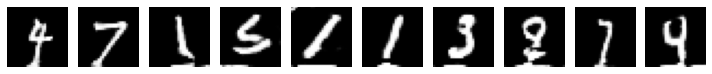

13601 [D loss: 0.471518, acc.: 78.12%] [G loss: 2.183501]
13602 [D loss: 0.371642, acc.: 83.59%] [G loss: 1.888487]
13603 [D loss: 0.427754, acc.: 80.47%] [G loss: 1.549737]
13604 [D loss: 0.469294, acc.: 78.12%] [G loss: 1.525695]
13605 [D loss: 0.513821, acc.: 74.22%] [G loss: 1.780110]
13606 [D loss: 0.375728, acc.: 84.38%] [G loss: 2.243112]
13607 [D loss: 0.433373, acc.: 80.47%] [G loss: 1.911658]
13608 [D loss: 0.443698, acc.: 80.47%] [G loss: 1.822347]
13609 [D loss: 0.485374, acc.: 77.34%] [G loss: 1.743511]
13610 [D loss: 0.406246, acc.: 81.25%] [G loss: 1.520351]
13611 [D loss: 0.518555, acc.: 76.56%] [G loss: 1.380889]
13612 [D loss: 0.463996, acc.: 76.56%] [G loss: 1.501714]
13613 [D loss: 0.404336, acc.: 78.91%] [G loss: 1.772614]
13614 [D loss: 0.401385, acc.: 82.81%] [G loss: 2.066195]
13615 [D loss: 0.517160, acc.: 77.34%] [G loss: 1.836877]
13616 [D loss: 0.493931, acc.: 76.56%] [G loss: 1.690475]
13617 [D loss: 0.561971, acc.: 72.66%] [G loss: 1.412495]
13618 [D loss:

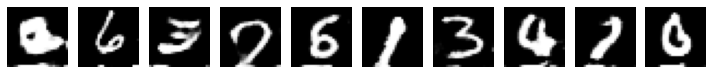

13701 [D loss: 0.546591, acc.: 71.09%] [G loss: 1.583851]
13702 [D loss: 0.518342, acc.: 74.22%] [G loss: 1.466930]
13703 [D loss: 0.553259, acc.: 62.50%] [G loss: 1.291266]
13704 [D loss: 0.390347, acc.: 83.59%] [G loss: 1.597428]
13705 [D loss: 0.387173, acc.: 81.25%] [G loss: 1.861251]
13706 [D loss: 0.473391, acc.: 77.34%] [G loss: 1.486505]
13707 [D loss: 0.380669, acc.: 82.03%] [G loss: 1.756479]
13708 [D loss: 0.471599, acc.: 79.69%] [G loss: 1.561619]
13709 [D loss: 0.443137, acc.: 78.12%] [G loss: 1.756070]
13710 [D loss: 0.349430, acc.: 85.94%] [G loss: 1.988372]
13711 [D loss: 0.396916, acc.: 79.69%] [G loss: 2.043901]
13712 [D loss: 0.367070, acc.: 85.94%] [G loss: 1.856747]
13713 [D loss: 0.393917, acc.: 82.03%] [G loss: 1.808746]
13714 [D loss: 0.376824, acc.: 85.16%] [G loss: 1.743295]
13715 [D loss: 0.384202, acc.: 82.03%] [G loss: 1.516502]
13716 [D loss: 0.339304, acc.: 85.94%] [G loss: 1.564251]
13717 [D loss: 0.401438, acc.: 80.47%] [G loss: 1.975839]
13718 [D loss:

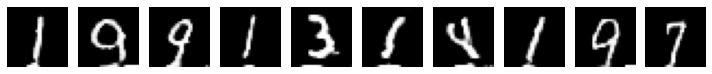

13801 [D loss: 0.334758, acc.: 87.50%] [G loss: 2.015769]
13802 [D loss: 0.283791, acc.: 90.62%] [G loss: 2.217285]
13803 [D loss: 0.335774, acc.: 84.38%] [G loss: 2.138938]
13804 [D loss: 0.384523, acc.: 83.59%] [G loss: 1.883769]
13805 [D loss: 0.362548, acc.: 81.25%] [G loss: 1.759677]
13806 [D loss: 0.475572, acc.: 80.47%] [G loss: 2.089437]
13807 [D loss: 0.259615, acc.: 89.84%] [G loss: 2.422832]
13808 [D loss: 0.430130, acc.: 78.91%] [G loss: 2.384450]
13809 [D loss: 0.454547, acc.: 74.22%] [G loss: 1.991629]
13810 [D loss: 0.530583, acc.: 74.22%] [G loss: 1.737638]
13811 [D loss: 0.440522, acc.: 84.38%] [G loss: 1.944989]
13812 [D loss: 0.351204, acc.: 86.72%] [G loss: 2.120774]
13813 [D loss: 0.398255, acc.: 85.16%] [G loss: 2.197884]
13814 [D loss: 0.542823, acc.: 75.00%] [G loss: 1.978395]
13815 [D loss: 0.490076, acc.: 76.56%] [G loss: 1.556218]
13816 [D loss: 0.650084, acc.: 67.19%] [G loss: 1.344386]
13817 [D loss: 0.520339, acc.: 78.12%] [G loss: 1.583094]
13818 [D loss:

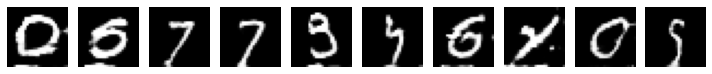

13901 [D loss: 0.431668, acc.: 82.03%] [G loss: 1.914187]
13902 [D loss: 0.582982, acc.: 75.00%] [G loss: 1.598301]
13903 [D loss: 0.418174, acc.: 78.91%] [G loss: 1.524164]
13904 [D loss: 0.597914, acc.: 73.44%] [G loss: 1.466030]
13905 [D loss: 0.458930, acc.: 75.78%] [G loss: 1.668864]
13906 [D loss: 0.329922, acc.: 85.16%] [G loss: 1.879388]
13907 [D loss: 0.467639, acc.: 71.88%] [G loss: 1.840693]
13908 [D loss: 0.444756, acc.: 81.25%] [G loss: 1.720149]
13909 [D loss: 0.372333, acc.: 82.81%] [G loss: 1.624244]
13910 [D loss: 0.405396, acc.: 83.59%] [G loss: 1.431012]
13911 [D loss: 0.421691, acc.: 82.81%] [G loss: 1.500928]
13912 [D loss: 0.373680, acc.: 84.38%] [G loss: 1.868924]
13913 [D loss: 0.423770, acc.: 78.12%] [G loss: 1.930550]
13914 [D loss: 0.466656, acc.: 75.00%] [G loss: 1.918885]
13915 [D loss: 0.445767, acc.: 80.47%] [G loss: 1.996411]
13916 [D loss: 0.462368, acc.: 79.69%] [G loss: 1.919042]
13917 [D loss: 0.315747, acc.: 88.28%] [G loss: 2.096701]
13918 [D loss:

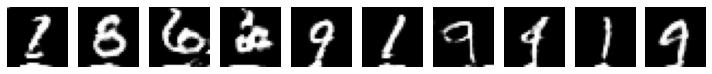

14001 [D loss: 0.597826, acc.: 67.19%] [G loss: 1.533356]
14002 [D loss: 0.436537, acc.: 75.78%] [G loss: 1.612475]
14003 [D loss: 0.455256, acc.: 74.22%] [G loss: 1.817590]
14004 [D loss: 0.375782, acc.: 82.03%] [G loss: 1.924409]
14005 [D loss: 0.420623, acc.: 78.91%] [G loss: 1.695990]
14006 [D loss: 0.523290, acc.: 71.09%] [G loss: 1.521952]
14007 [D loss: 0.480999, acc.: 76.56%] [G loss: 1.271182]
14008 [D loss: 0.447067, acc.: 79.69%] [G loss: 1.616610]
14009 [D loss: 0.362959, acc.: 85.16%] [G loss: 2.001420]
14010 [D loss: 0.449915, acc.: 74.22%] [G loss: 2.179911]
14011 [D loss: 0.456717, acc.: 80.47%] [G loss: 2.122160]
14012 [D loss: 0.499121, acc.: 78.12%] [G loss: 1.646590]
14013 [D loss: 0.469185, acc.: 77.34%] [G loss: 1.340576]
14014 [D loss: 0.393106, acc.: 81.25%] [G loss: 1.572586]
14015 [D loss: 0.358602, acc.: 85.16%] [G loss: 1.857055]
14016 [D loss: 0.465266, acc.: 77.34%] [G loss: 1.751311]
14017 [D loss: 0.509793, acc.: 77.34%] [G loss: 1.768536]
14018 [D loss:

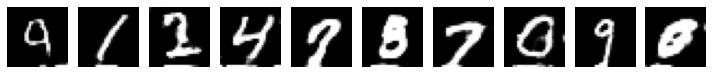

14101 [D loss: 0.443165, acc.: 78.91%] [G loss: 2.013786]
14102 [D loss: 0.420824, acc.: 80.47%] [G loss: 1.658458]
14103 [D loss: 0.481732, acc.: 78.91%] [G loss: 1.533434]
14104 [D loss: 0.446824, acc.: 78.12%] [G loss: 1.613668]
14105 [D loss: 0.420832, acc.: 77.34%] [G loss: 1.920646]
14106 [D loss: 0.374495, acc.: 84.38%] [G loss: 2.195521]
14107 [D loss: 0.509599, acc.: 73.44%] [G loss: 2.156889]
14108 [D loss: 0.415791, acc.: 83.59%] [G loss: 2.004971]
14109 [D loss: 0.485333, acc.: 79.69%] [G loss: 1.796646]
14110 [D loss: 0.521639, acc.: 75.78%] [G loss: 1.169665]
14111 [D loss: 0.540153, acc.: 73.44%] [G loss: 1.447028]
14112 [D loss: 0.362175, acc.: 88.28%] [G loss: 1.944382]
14113 [D loss: 0.395323, acc.: 83.59%] [G loss: 2.339646]
14114 [D loss: 0.540327, acc.: 70.31%] [G loss: 2.013900]
14115 [D loss: 0.397820, acc.: 85.16%] [G loss: 1.413937]
14116 [D loss: 0.549754, acc.: 74.22%] [G loss: 1.303392]
14117 [D loss: 0.494991, acc.: 71.88%] [G loss: 1.356395]
14118 [D loss:

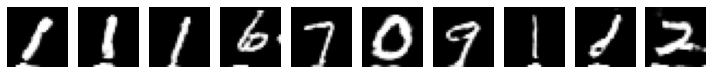

14201 [D loss: 0.475207, acc.: 77.34%] [G loss: 1.615570]
14202 [D loss: 0.456512, acc.: 76.56%] [G loss: 1.609124]
14203 [D loss: 0.478014, acc.: 77.34%] [G loss: 1.497118]
14204 [D loss: 0.453359, acc.: 76.56%] [G loss: 1.415760]
14205 [D loss: 0.550474, acc.: 71.88%] [G loss: 1.720918]
14206 [D loss: 0.342508, acc.: 83.59%] [G loss: 1.871004]
14207 [D loss: 0.418263, acc.: 80.47%] [G loss: 1.988282]
14208 [D loss: 0.406653, acc.: 82.81%] [G loss: 1.806376]
14209 [D loss: 0.543036, acc.: 73.44%] [G loss: 1.504649]
14210 [D loss: 0.422563, acc.: 78.91%] [G loss: 1.433015]
14211 [D loss: 0.429036, acc.: 76.56%] [G loss: 1.543309]
14212 [D loss: 0.338339, acc.: 86.72%] [G loss: 1.659365]
14213 [D loss: 0.429147, acc.: 79.69%] [G loss: 2.107056]
14214 [D loss: 0.415943, acc.: 85.16%] [G loss: 1.902993]
14215 [D loss: 0.482711, acc.: 78.12%] [G loss: 1.680697]
14216 [D loss: 0.468137, acc.: 76.56%] [G loss: 1.682905]
14217 [D loss: 0.423975, acc.: 80.47%] [G loss: 1.599339]
14218 [D loss:

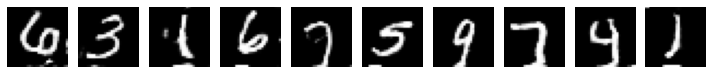

14301 [D loss: 0.389447, acc.: 82.81%] [G loss: 1.530930]
14302 [D loss: 0.472719, acc.: 78.12%] [G loss: 1.639349]
14303 [D loss: 0.505182, acc.: 71.09%] [G loss: 1.549853]
14304 [D loss: 0.424107, acc.: 79.69%] [G loss: 1.599867]
14305 [D loss: 0.391604, acc.: 85.16%] [G loss: 2.015570]
14306 [D loss: 0.414035, acc.: 80.47%] [G loss: 2.023583]
14307 [D loss: 0.450891, acc.: 77.34%] [G loss: 1.850594]
14308 [D loss: 0.421846, acc.: 84.38%] [G loss: 1.666665]
14309 [D loss: 0.411827, acc.: 80.47%] [G loss: 1.760511]
14310 [D loss: 0.391455, acc.: 79.69%] [G loss: 1.825453]
14311 [D loss: 0.503587, acc.: 77.34%] [G loss: 1.785788]
14312 [D loss: 0.466943, acc.: 76.56%] [G loss: 1.738101]
14313 [D loss: 0.452451, acc.: 79.69%] [G loss: 1.838468]
14314 [D loss: 0.395252, acc.: 83.59%] [G loss: 2.103919]
14315 [D loss: 0.419756, acc.: 81.25%] [G loss: 1.987514]
14316 [D loss: 0.430584, acc.: 81.25%] [G loss: 1.619188]
14317 [D loss: 0.395650, acc.: 79.69%] [G loss: 1.321110]
14318 [D loss:

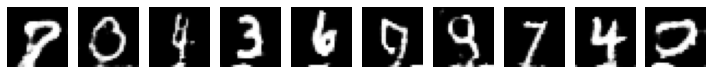

14401 [D loss: 0.429705, acc.: 78.12%] [G loss: 1.782492]
14402 [D loss: 0.404416, acc.: 80.47%] [G loss: 1.765155]
14403 [D loss: 0.393781, acc.: 82.03%] [G loss: 1.785851]
14404 [D loss: 0.457016, acc.: 80.47%] [G loss: 1.801473]
14405 [D loss: 0.486657, acc.: 73.44%] [G loss: 1.585293]
14406 [D loss: 0.462767, acc.: 75.00%] [G loss: 1.716009]
14407 [D loss: 0.436191, acc.: 78.12%] [G loss: 1.780549]
14408 [D loss: 0.418506, acc.: 81.25%] [G loss: 1.820978]
14409 [D loss: 0.610282, acc.: 66.41%] [G loss: 1.523435]
14410 [D loss: 0.507717, acc.: 75.00%] [G loss: 1.486830]
14411 [D loss: 0.495290, acc.: 78.91%] [G loss: 1.721862]
14412 [D loss: 0.457049, acc.: 80.47%] [G loss: 2.001814]
14413 [D loss: 0.405160, acc.: 82.03%] [G loss: 1.691591]
14414 [D loss: 0.484983, acc.: 76.56%] [G loss: 1.534801]
14415 [D loss: 0.491139, acc.: 75.78%] [G loss: 1.350607]
14416 [D loss: 0.462420, acc.: 76.56%] [G loss: 1.181903]
14417 [D loss: 0.481517, acc.: 78.12%] [G loss: 1.360761]
14418 [D loss:

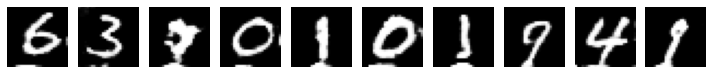

14501 [D loss: 0.520936, acc.: 76.56%] [G loss: 1.736167]
14502 [D loss: 0.444372, acc.: 78.91%] [G loss: 1.745732]
14503 [D loss: 0.501579, acc.: 74.22%] [G loss: 1.531385]
14504 [D loss: 0.334720, acc.: 82.81%] [G loss: 1.782551]
14505 [D loss: 0.580378, acc.: 70.31%] [G loss: 1.455822]
14506 [D loss: 0.448172, acc.: 78.12%] [G loss: 1.314879]
14507 [D loss: 0.537132, acc.: 71.88%] [G loss: 1.479754]
14508 [D loss: 0.385234, acc.: 83.59%] [G loss: 1.692268]
14509 [D loss: 0.463555, acc.: 78.91%] [G loss: 1.828056]
14510 [D loss: 0.495722, acc.: 75.78%] [G loss: 1.394652]
14511 [D loss: 0.435751, acc.: 76.56%] [G loss: 1.532449]
14512 [D loss: 0.409475, acc.: 82.81%] [G loss: 1.521370]
14513 [D loss: 0.383430, acc.: 83.59%] [G loss: 1.698041]
14514 [D loss: 0.369246, acc.: 84.38%] [G loss: 1.812842]
14515 [D loss: 0.351255, acc.: 85.16%] [G loss: 2.135030]
14516 [D loss: 0.445346, acc.: 82.81%] [G loss: 2.160079]
14517 [D loss: 0.476587, acc.: 80.47%] [G loss: 1.928655]
14518 [D loss:

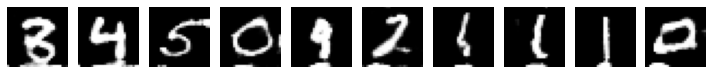

14601 [D loss: 0.599195, acc.: 70.31%] [G loss: 1.732591]
14602 [D loss: 0.544396, acc.: 74.22%] [G loss: 1.839331]
14603 [D loss: 0.448846, acc.: 76.56%] [G loss: 1.587210]
14604 [D loss: 0.504947, acc.: 76.56%] [G loss: 1.702232]
14605 [D loss: 0.502750, acc.: 73.44%] [G loss: 1.687248]
14606 [D loss: 0.443729, acc.: 78.91%] [G loss: 1.719031]
14607 [D loss: 0.475432, acc.: 82.03%] [G loss: 1.895321]
14608 [D loss: 0.449305, acc.: 76.56%] [G loss: 1.806010]
14609 [D loss: 0.455967, acc.: 78.12%] [G loss: 1.845603]
14610 [D loss: 0.568231, acc.: 68.75%] [G loss: 1.508993]
14611 [D loss: 0.497204, acc.: 75.00%] [G loss: 1.605726]
14612 [D loss: 0.375587, acc.: 86.72%] [G loss: 1.475852]
14613 [D loss: 0.452056, acc.: 79.69%] [G loss: 1.483113]
14614 [D loss: 0.468570, acc.: 78.12%] [G loss: 1.846830]
14615 [D loss: 0.429139, acc.: 82.81%] [G loss: 1.770168]
14616 [D loss: 0.405377, acc.: 82.03%] [G loss: 2.118214]
14617 [D loss: 0.489027, acc.: 72.66%] [G loss: 2.027690]
14618 [D loss:

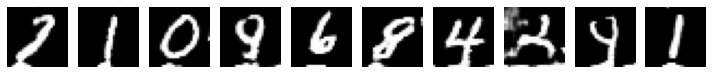

14701 [D loss: 0.411429, acc.: 82.81%] [G loss: 1.910583]
14702 [D loss: 0.466075, acc.: 77.34%] [G loss: 1.708821]
14703 [D loss: 0.319068, acc.: 87.50%] [G loss: 1.886426]
14704 [D loss: 0.258068, acc.: 87.50%] [G loss: 1.703727]
14705 [D loss: 0.446214, acc.: 80.47%] [G loss: 1.915808]
14706 [D loss: 0.443935, acc.: 83.59%] [G loss: 2.161342]
14707 [D loss: 0.264283, acc.: 89.06%] [G loss: 2.418490]
14708 [D loss: 0.556014, acc.: 75.00%] [G loss: 1.930122]
14709 [D loss: 0.484690, acc.: 74.22%] [G loss: 1.669828]
14710 [D loss: 0.525515, acc.: 71.09%] [G loss: 1.628306]
14711 [D loss: 0.359047, acc.: 85.16%] [G loss: 2.015028]
14712 [D loss: 0.320565, acc.: 87.50%] [G loss: 2.261164]
14713 [D loss: 0.458695, acc.: 78.91%] [G loss: 2.027767]
14714 [D loss: 0.488762, acc.: 76.56%] [G loss: 1.892069]
14715 [D loss: 0.407356, acc.: 80.47%] [G loss: 2.036355]
14716 [D loss: 0.373910, acc.: 85.16%] [G loss: 2.026660]
14717 [D loss: 0.393053, acc.: 81.25%] [G loss: 1.938103]
14718 [D loss:

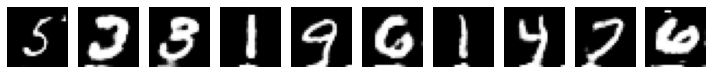

14801 [D loss: 0.530710, acc.: 78.91%] [G loss: 1.928632]
14802 [D loss: 0.397584, acc.: 78.12%] [G loss: 1.842440]
14803 [D loss: 0.408728, acc.: 81.25%] [G loss: 1.981137]
14804 [D loss: 0.363436, acc.: 82.81%] [G loss: 1.771155]
14805 [D loss: 0.374128, acc.: 82.03%] [G loss: 1.865712]
14806 [D loss: 0.291710, acc.: 90.62%] [G loss: 1.965643]
14807 [D loss: 0.335176, acc.: 85.94%] [G loss: 1.883324]
14808 [D loss: 0.405214, acc.: 83.59%] [G loss: 1.995234]
14809 [D loss: 0.423008, acc.: 83.59%] [G loss: 2.073777]
14810 [D loss: 0.356784, acc.: 82.81%] [G loss: 2.008990]
14811 [D loss: 0.387514, acc.: 79.69%] [G loss: 1.860698]
14812 [D loss: 0.560079, acc.: 73.44%] [G loss: 2.023799]
14813 [D loss: 0.364666, acc.: 84.38%] [G loss: 1.900373]
14814 [D loss: 0.279813, acc.: 87.50%] [G loss: 2.287036]
14815 [D loss: 0.406265, acc.: 80.47%] [G loss: 2.448244]
14816 [D loss: 0.415973, acc.: 81.25%] [G loss: 2.194523]
14817 [D loss: 0.403821, acc.: 82.03%] [G loss: 2.161219]
14818 [D loss:

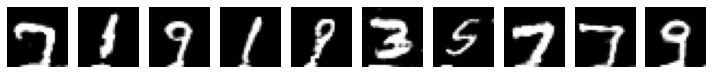

14901 [D loss: 0.518751, acc.: 75.00%] [G loss: 1.445477]
14902 [D loss: 0.496775, acc.: 75.78%] [G loss: 1.499306]
14903 [D loss: 0.315233, acc.: 85.94%] [G loss: 1.686812]
14904 [D loss: 0.367510, acc.: 82.03%] [G loss: 1.846143]
14905 [D loss: 0.488984, acc.: 77.34%] [G loss: 1.833516]
14906 [D loss: 0.494600, acc.: 76.56%] [G loss: 1.811182]
14907 [D loss: 0.528666, acc.: 74.22%] [G loss: 1.524045]
14908 [D loss: 0.539271, acc.: 75.78%] [G loss: 1.360730]
14909 [D loss: 0.436520, acc.: 79.69%] [G loss: 1.438062]
14910 [D loss: 0.481310, acc.: 76.56%] [G loss: 1.622840]
14911 [D loss: 0.440976, acc.: 77.34%] [G loss: 1.915851]
14912 [D loss: 0.539011, acc.: 71.88%] [G loss: 1.765532]
14913 [D loss: 0.414215, acc.: 82.03%] [G loss: 1.707760]
14914 [D loss: 0.487444, acc.: 78.12%] [G loss: 1.543400]
14915 [D loss: 0.456282, acc.: 78.91%] [G loss: 1.429005]
14916 [D loss: 0.412162, acc.: 82.03%] [G loss: 1.315378]
14917 [D loss: 0.476354, acc.: 78.12%] [G loss: 1.453658]
14918 [D loss:

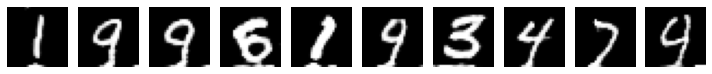

15001 [D loss: 0.395591, acc.: 83.59%] [G loss: 1.651321]
15002 [D loss: 0.475809, acc.: 78.91%] [G loss: 1.688178]
15003 [D loss: 0.424377, acc.: 78.91%] [G loss: 1.712379]
15004 [D loss: 0.484795, acc.: 78.12%] [G loss: 1.806393]
15005 [D loss: 0.455868, acc.: 77.34%] [G loss: 1.712673]
15006 [D loss: 0.477173, acc.: 77.34%] [G loss: 1.378687]
15007 [D loss: 0.426872, acc.: 80.47%] [G loss: 1.537690]
15008 [D loss: 0.534065, acc.: 74.22%] [G loss: 1.518995]
15009 [D loss: 0.359878, acc.: 85.94%] [G loss: 1.733433]
15010 [D loss: 0.545965, acc.: 71.09%] [G loss: 1.597857]
15011 [D loss: 0.491738, acc.: 77.34%] [G loss: 1.505836]
15012 [D loss: 0.483146, acc.: 77.34%] [G loss: 1.633422]
15013 [D loss: 0.422818, acc.: 78.91%] [G loss: 1.664639]
15014 [D loss: 0.417468, acc.: 80.47%] [G loss: 1.635474]
15015 [D loss: 0.413035, acc.: 75.00%] [G loss: 1.609259]
15016 [D loss: 0.509113, acc.: 76.56%] [G loss: 1.646264]
15017 [D loss: 0.461770, acc.: 75.00%] [G loss: 1.707847]
15018 [D loss:

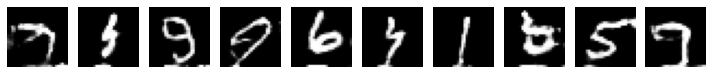

15101 [D loss: 0.415170, acc.: 79.69%] [G loss: 1.904166]
15102 [D loss: 0.430284, acc.: 79.69%] [G loss: 2.053011]
15103 [D loss: 0.440442, acc.: 78.12%] [G loss: 1.843047]
15104 [D loss: 0.420322, acc.: 83.59%] [G loss: 1.646641]
15105 [D loss: 0.547574, acc.: 70.31%] [G loss: 1.558626]
15106 [D loss: 0.444764, acc.: 78.12%] [G loss: 1.647888]
15107 [D loss: 0.434144, acc.: 80.47%] [G loss: 1.834710]
15108 [D loss: 0.437479, acc.: 81.25%] [G loss: 1.764954]
15109 [D loss: 0.471110, acc.: 73.44%] [G loss: 1.935965]
15110 [D loss: 0.379196, acc.: 83.59%] [G loss: 1.968657]
15111 [D loss: 0.410960, acc.: 80.47%] [G loss: 1.686380]
15112 [D loss: 0.455869, acc.: 81.25%] [G loss: 1.779875]
15113 [D loss: 0.349509, acc.: 85.94%] [G loss: 1.866262]
15114 [D loss: 0.418038, acc.: 84.38%] [G loss: 1.956538]
15115 [D loss: 0.517842, acc.: 77.34%] [G loss: 1.886896]
15116 [D loss: 0.408226, acc.: 81.25%] [G loss: 1.909050]
15117 [D loss: 0.462439, acc.: 77.34%] [G loss: 1.979538]
15118 [D loss:

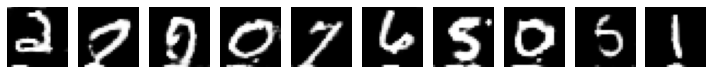

15201 [D loss: 0.439570, acc.: 76.56%] [G loss: 1.935117]
15202 [D loss: 0.466980, acc.: 75.78%] [G loss: 1.812279]
15203 [D loss: 0.453681, acc.: 79.69%] [G loss: 1.622831]
15204 [D loss: 0.469430, acc.: 75.78%] [G loss: 1.666774]
15205 [D loss: 0.395713, acc.: 82.81%] [G loss: 1.492932]
15206 [D loss: 0.456504, acc.: 79.69%] [G loss: 1.668591]
15207 [D loss: 0.423634, acc.: 82.03%] [G loss: 1.705259]
15208 [D loss: 0.374419, acc.: 82.81%] [G loss: 1.761601]
15209 [D loss: 0.596041, acc.: 69.53%] [G loss: 1.736507]
15210 [D loss: 0.498197, acc.: 75.78%] [G loss: 1.546718]
15211 [D loss: 0.390130, acc.: 82.03%] [G loss: 1.515753]
15212 [D loss: 0.478069, acc.: 76.56%] [G loss: 1.610603]
15213 [D loss: 0.467655, acc.: 78.12%] [G loss: 1.719462]
15214 [D loss: 0.473032, acc.: 78.12%] [G loss: 1.833839]
15215 [D loss: 0.505494, acc.: 74.22%] [G loss: 1.887662]
15216 [D loss: 0.430136, acc.: 78.12%] [G loss: 1.641764]
15217 [D loss: 0.413501, acc.: 79.69%] [G loss: 1.551281]
15218 [D loss:

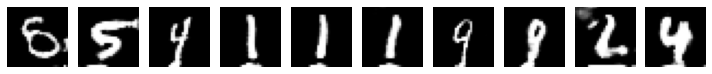

15301 [D loss: 0.397648, acc.: 78.91%] [G loss: 2.199691]
15302 [D loss: 0.597044, acc.: 71.88%] [G loss: 1.567967]
15303 [D loss: 0.463329, acc.: 76.56%] [G loss: 1.458381]
15304 [D loss: 0.489363, acc.: 77.34%] [G loss: 1.531371]
15305 [D loss: 0.354547, acc.: 83.59%] [G loss: 2.063540]
15306 [D loss: 0.410853, acc.: 77.34%] [G loss: 2.106695]
15307 [D loss: 0.401094, acc.: 82.03%] [G loss: 1.991487]
15308 [D loss: 0.525447, acc.: 77.34%] [G loss: 1.687307]
15309 [D loss: 0.410539, acc.: 82.81%] [G loss: 1.474004]
15310 [D loss: 0.410613, acc.: 81.25%] [G loss: 1.522359]
15311 [D loss: 0.323575, acc.: 86.72%] [G loss: 1.761358]
15312 [D loss: 0.381635, acc.: 82.81%] [G loss: 2.102868]
15313 [D loss: 0.413719, acc.: 80.47%] [G loss: 2.316590]
15314 [D loss: 0.313058, acc.: 88.28%] [G loss: 2.096026]
15315 [D loss: 0.339652, acc.: 87.50%] [G loss: 2.001609]
15316 [D loss: 0.541253, acc.: 71.09%] [G loss: 1.752502]
15317 [D loss: 0.411086, acc.: 82.81%] [G loss: 1.859864]
15318 [D loss:

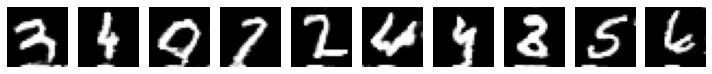

15401 [D loss: 0.403145, acc.: 82.81%] [G loss: 2.484086]
15402 [D loss: 0.433392, acc.: 79.69%] [G loss: 2.240000]
15403 [D loss: 0.473737, acc.: 74.22%] [G loss: 1.930344]
15404 [D loss: 0.358118, acc.: 85.94%] [G loss: 1.530513]
15405 [D loss: 0.462113, acc.: 78.12%] [G loss: 1.736187]
15406 [D loss: 0.316891, acc.: 84.38%] [G loss: 2.188934]
15407 [D loss: 0.398761, acc.: 84.38%] [G loss: 2.390300]
15408 [D loss: 0.448169, acc.: 77.34%] [G loss: 1.882412]
15409 [D loss: 0.465317, acc.: 77.34%] [G loss: 1.797063]
15410 [D loss: 0.374135, acc.: 81.25%] [G loss: 1.663638]
15411 [D loss: 0.382407, acc.: 80.47%] [G loss: 2.059484]
15412 [D loss: 0.507915, acc.: 75.78%] [G loss: 2.122348]
15413 [D loss: 0.475378, acc.: 80.47%] [G loss: 1.932412]
15414 [D loss: 0.476192, acc.: 80.47%] [G loss: 1.916674]
15415 [D loss: 0.365232, acc.: 86.72%] [G loss: 1.527109]
15416 [D loss: 0.504061, acc.: 76.56%] [G loss: 1.541279]
15417 [D loss: 0.454963, acc.: 77.34%] [G loss: 1.773383]
15418 [D loss:

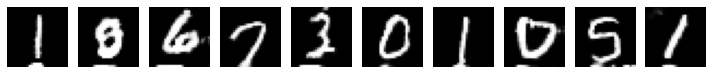

15501 [D loss: 0.476168, acc.: 78.12%] [G loss: 1.861430]
15502 [D loss: 0.390207, acc.: 84.38%] [G loss: 1.781140]
15503 [D loss: 0.380607, acc.: 83.59%] [G loss: 1.466110]
15504 [D loss: 0.463457, acc.: 74.22%] [G loss: 1.624418]
15505 [D loss: 0.435145, acc.: 82.03%] [G loss: 1.860956]
15506 [D loss: 0.477526, acc.: 77.34%] [G loss: 1.823684]
15507 [D loss: 0.369745, acc.: 85.94%] [G loss: 2.298839]
15508 [D loss: 0.396628, acc.: 78.91%] [G loss: 2.038572]
15509 [D loss: 0.436207, acc.: 79.69%] [G loss: 1.906594]
15510 [D loss: 0.416698, acc.: 76.56%] [G loss: 1.719875]
15511 [D loss: 0.389646, acc.: 77.34%] [G loss: 1.672294]
15512 [D loss: 0.421020, acc.: 80.47%] [G loss: 1.859178]
15513 [D loss: 0.397495, acc.: 78.91%] [G loss: 2.133763]
15514 [D loss: 0.329097, acc.: 82.03%] [G loss: 2.135776]
15515 [D loss: 0.382555, acc.: 85.16%] [G loss: 2.114540]
15516 [D loss: 0.429542, acc.: 78.91%] [G loss: 1.784439]
15517 [D loss: 0.529121, acc.: 75.78%] [G loss: 1.605314]
15518 [D loss:

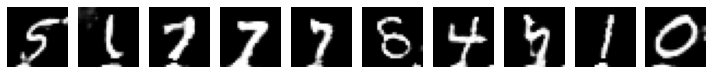

15601 [D loss: 0.461663, acc.: 78.12%] [G loss: 1.901720]
15602 [D loss: 0.448640, acc.: 78.12%] [G loss: 1.604794]
15603 [D loss: 0.405074, acc.: 78.91%] [G loss: 1.464960]
15604 [D loss: 0.435798, acc.: 79.69%] [G loss: 1.320144]
15605 [D loss: 0.438432, acc.: 82.81%] [G loss: 1.344885]
15606 [D loss: 0.527878, acc.: 74.22%] [G loss: 1.573541]
15607 [D loss: 0.392578, acc.: 80.47%] [G loss: 1.732215]
15608 [D loss: 0.360300, acc.: 85.94%] [G loss: 1.978809]
15609 [D loss: 0.522484, acc.: 70.31%] [G loss: 1.737309]
15610 [D loss: 0.485270, acc.: 80.47%] [G loss: 1.527914]
15611 [D loss: 0.466880, acc.: 73.44%] [G loss: 1.390962]
15612 [D loss: 0.479330, acc.: 74.22%] [G loss: 1.277140]
15613 [D loss: 0.322841, acc.: 89.06%] [G loss: 1.595879]
15614 [D loss: 0.341252, acc.: 84.38%] [G loss: 1.847261]
15615 [D loss: 0.486780, acc.: 76.56%] [G loss: 1.964053]
15616 [D loss: 0.467978, acc.: 76.56%] [G loss: 1.897695]
15617 [D loss: 0.489257, acc.: 76.56%] [G loss: 1.884085]
15618 [D loss:

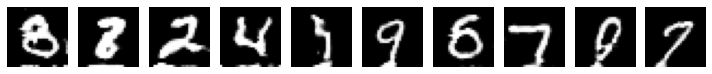

15701 [D loss: 0.477961, acc.: 74.22%] [G loss: 1.646438]
15702 [D loss: 0.501308, acc.: 75.00%] [G loss: 1.677280]
15703 [D loss: 0.364269, acc.: 83.59%] [G loss: 1.781898]
15704 [D loss: 0.492271, acc.: 77.34%] [G loss: 2.155047]
15705 [D loss: 0.418886, acc.: 79.69%] [G loss: 2.052212]
15706 [D loss: 0.475824, acc.: 76.56%] [G loss: 1.659144]
15707 [D loss: 0.466742, acc.: 81.25%] [G loss: 1.678828]
15708 [D loss: 0.415705, acc.: 82.81%] [G loss: 1.804602]
15709 [D loss: 0.398808, acc.: 83.59%] [G loss: 1.626902]
15710 [D loss: 0.475989, acc.: 73.44%] [G loss: 1.570876]
15711 [D loss: 0.439302, acc.: 80.47%] [G loss: 1.755784]
15712 [D loss: 0.430311, acc.: 79.69%] [G loss: 1.868659]
15713 [D loss: 0.525219, acc.: 72.66%] [G loss: 1.923146]
15714 [D loss: 0.495375, acc.: 74.22%] [G loss: 1.649318]
15715 [D loss: 0.496039, acc.: 73.44%] [G loss: 1.393572]
15716 [D loss: 0.393333, acc.: 78.91%] [G loss: 1.535415]
15717 [D loss: 0.402298, acc.: 82.03%] [G loss: 1.611623]
15718 [D loss:

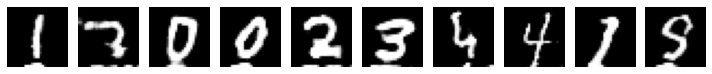

15801 [D loss: 0.434254, acc.: 82.03%] [G loss: 1.792779]
15802 [D loss: 0.476299, acc.: 77.34%] [G loss: 1.691636]
15803 [D loss: 0.378629, acc.: 81.25%] [G loss: 1.696259]
15804 [D loss: 0.413712, acc.: 79.69%] [G loss: 1.894592]
15805 [D loss: 0.383700, acc.: 82.81%] [G loss: 1.923199]
15806 [D loss: 0.495336, acc.: 75.00%] [G loss: 1.773535]
15807 [D loss: 0.498188, acc.: 77.34%] [G loss: 1.624997]
15808 [D loss: 0.447447, acc.: 80.47%] [G loss: 1.760576]
15809 [D loss: 0.473414, acc.: 77.34%] [G loss: 1.641905]
15810 [D loss: 0.421431, acc.: 84.38%] [G loss: 1.465686]
15811 [D loss: 0.446974, acc.: 78.91%] [G loss: 1.525412]
15812 [D loss: 0.375511, acc.: 86.72%] [G loss: 1.703951]
15813 [D loss: 0.467489, acc.: 78.91%] [G loss: 1.713456]
15814 [D loss: 0.403143, acc.: 82.81%] [G loss: 1.615044]
15815 [D loss: 0.396079, acc.: 82.81%] [G loss: 1.556174]
15816 [D loss: 0.489946, acc.: 78.91%] [G loss: 1.610423]
15817 [D loss: 0.475129, acc.: 76.56%] [G loss: 1.533541]
15818 [D loss:

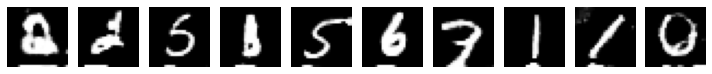

15901 [D loss: 0.571488, acc.: 69.53%] [G loss: 1.765037]
15902 [D loss: 0.424227, acc.: 78.91%] [G loss: 1.691731]
15903 [D loss: 0.383983, acc.: 83.59%] [G loss: 1.506963]
15904 [D loss: 0.389978, acc.: 84.38%] [G loss: 1.309312]
15905 [D loss: 0.411479, acc.: 82.81%] [G loss: 1.531142]
15906 [D loss: 0.383567, acc.: 83.59%] [G loss: 1.449622]
15907 [D loss: 0.384870, acc.: 82.03%] [G loss: 1.628098]
15908 [D loss: 0.400339, acc.: 85.16%] [G loss: 1.707360]
15909 [D loss: 0.420304, acc.: 80.47%] [G loss: 1.816527]
15910 [D loss: 0.431558, acc.: 80.47%] [G loss: 1.712160]
15911 [D loss: 0.374659, acc.: 82.81%] [G loss: 2.013838]
15912 [D loss: 0.481643, acc.: 74.22%] [G loss: 1.946417]
15913 [D loss: 0.448279, acc.: 78.12%] [G loss: 2.236222]
15914 [D loss: 0.410783, acc.: 82.03%] [G loss: 2.291823]
15915 [D loss: 0.337523, acc.: 85.94%] [G loss: 1.886800]
15916 [D loss: 0.427584, acc.: 78.12%] [G loss: 1.678760]
15917 [D loss: 0.405882, acc.: 83.59%] [G loss: 1.693078]
15918 [D loss:

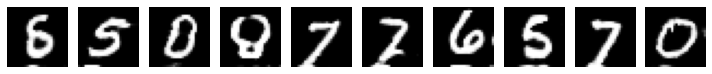

16001 [D loss: 0.374361, acc.: 81.25%] [G loss: 2.268030]
16002 [D loss: 0.371063, acc.: 85.16%] [G loss: 1.988526]
16003 [D loss: 0.424506, acc.: 76.56%] [G loss: 1.828157]
16004 [D loss: 0.412376, acc.: 78.12%] [G loss: 1.785157]
16005 [D loss: 0.404332, acc.: 78.91%] [G loss: 1.953562]
16006 [D loss: 0.348568, acc.: 85.16%] [G loss: 2.535447]
16007 [D loss: 0.523320, acc.: 75.78%] [G loss: 1.893280]
16008 [D loss: 0.542648, acc.: 76.56%] [G loss: 1.434782]
16009 [D loss: 0.441770, acc.: 78.12%] [G loss: 1.699270]
16010 [D loss: 0.518765, acc.: 75.78%] [G loss: 1.936141]
16011 [D loss: 0.456003, acc.: 78.91%] [G loss: 1.907850]
16012 [D loss: 0.447388, acc.: 77.34%] [G loss: 1.689443]
16013 [D loss: 0.413598, acc.: 81.25%] [G loss: 1.687668]
16014 [D loss: 0.543567, acc.: 70.31%] [G loss: 1.324627]
16015 [D loss: 0.481760, acc.: 73.44%] [G loss: 1.457019]
16016 [D loss: 0.330286, acc.: 84.38%] [G loss: 1.801859]
16017 [D loss: 0.420709, acc.: 78.12%] [G loss: 1.938576]
16018 [D loss:

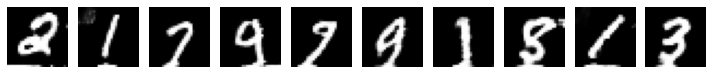

16101 [D loss: 0.434502, acc.: 77.34%] [G loss: 1.685536]
16102 [D loss: 0.357174, acc.: 80.47%] [G loss: 1.765002]
16103 [D loss: 0.484822, acc.: 81.25%] [G loss: 1.918791]
16104 [D loss: 0.417123, acc.: 80.47%] [G loss: 2.192218]
16105 [D loss: 0.509061, acc.: 75.78%] [G loss: 1.778678]
16106 [D loss: 0.539194, acc.: 77.34%] [G loss: 1.606317]
16107 [D loss: 0.435447, acc.: 82.81%] [G loss: 1.676229]
16108 [D loss: 0.408024, acc.: 78.91%] [G loss: 2.092852]
16109 [D loss: 0.328137, acc.: 88.28%] [G loss: 2.214903]
16110 [D loss: 0.457550, acc.: 81.25%] [G loss: 2.136560]
16111 [D loss: 0.534446, acc.: 68.75%] [G loss: 1.766739]
16112 [D loss: 0.424473, acc.: 78.91%] [G loss: 1.668835]
16113 [D loss: 0.509862, acc.: 75.00%] [G loss: 1.537495]
16114 [D loss: 0.422647, acc.: 77.34%] [G loss: 1.502766]
16115 [D loss: 0.439375, acc.: 80.47%] [G loss: 1.751817]
16116 [D loss: 0.495770, acc.: 75.00%] [G loss: 2.060467]
16117 [D loss: 0.516852, acc.: 75.00%] [G loss: 1.978655]
16118 [D loss:

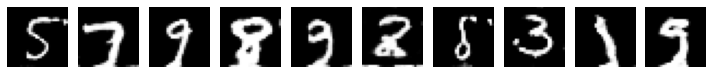

16201 [D loss: 0.471700, acc.: 79.69%] [G loss: 1.812726]
16202 [D loss: 0.509118, acc.: 78.91%] [G loss: 1.976527]
16203 [D loss: 0.434476, acc.: 78.91%] [G loss: 2.081601]
16204 [D loss: 0.419132, acc.: 82.81%] [G loss: 2.167337]
16205 [D loss: 0.378179, acc.: 83.59%] [G loss: 2.047545]
16206 [D loss: 0.479808, acc.: 73.44%] [G loss: 1.916837]
16207 [D loss: 0.401217, acc.: 78.12%] [G loss: 1.826427]
16208 [D loss: 0.371374, acc.: 84.38%] [G loss: 1.772695]
16209 [D loss: 0.475190, acc.: 79.69%] [G loss: 1.793864]
16210 [D loss: 0.432648, acc.: 81.25%] [G loss: 1.899251]
16211 [D loss: 0.470989, acc.: 78.12%] [G loss: 1.812109]
16212 [D loss: 0.475398, acc.: 75.00%] [G loss: 1.780487]
16213 [D loss: 0.525510, acc.: 72.66%] [G loss: 1.938518]
16214 [D loss: 0.523507, acc.: 75.78%] [G loss: 1.787084]
16215 [D loss: 0.479072, acc.: 79.69%] [G loss: 1.955127]
16216 [D loss: 0.351651, acc.: 84.38%] [G loss: 1.793366]
16217 [D loss: 0.515466, acc.: 78.91%] [G loss: 1.588685]
16218 [D loss:

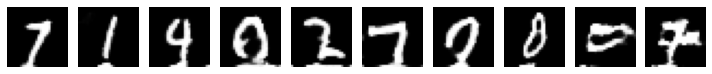

16301 [D loss: 0.488336, acc.: 75.78%] [G loss: 1.641060]
16302 [D loss: 0.443808, acc.: 80.47%] [G loss: 1.681800]
16303 [D loss: 0.408999, acc.: 78.91%] [G loss: 1.830905]
16304 [D loss: 0.481165, acc.: 77.34%] [G loss: 1.844365]
16305 [D loss: 0.421594, acc.: 80.47%] [G loss: 1.665360]
16306 [D loss: 0.417109, acc.: 83.59%] [G loss: 1.512178]
16307 [D loss: 0.389279, acc.: 82.81%] [G loss: 1.664119]
16308 [D loss: 0.532128, acc.: 68.75%] [G loss: 1.816715]
16309 [D loss: 0.483045, acc.: 73.44%] [G loss: 1.978981]
16310 [D loss: 0.521133, acc.: 71.88%] [G loss: 1.977115]
16311 [D loss: 0.511998, acc.: 75.78%] [G loss: 1.486303]
16312 [D loss: 0.418426, acc.: 79.69%] [G loss: 1.598259]
16313 [D loss: 0.402058, acc.: 82.03%] [G loss: 1.680939]
16314 [D loss: 0.439576, acc.: 82.03%] [G loss: 1.867321]
16315 [D loss: 0.423426, acc.: 83.59%] [G loss: 2.078261]
16316 [D loss: 0.545874, acc.: 71.88%] [G loss: 1.824007]
16317 [D loss: 0.389722, acc.: 79.69%] [G loss: 1.629557]
16318 [D loss:

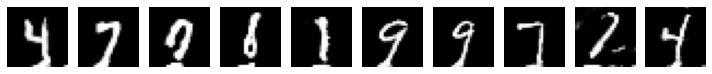

16401 [D loss: 0.465546, acc.: 77.34%] [G loss: 1.842284]
16402 [D loss: 0.481198, acc.: 76.56%] [G loss: 1.763494]
16403 [D loss: 0.506790, acc.: 77.34%] [G loss: 1.508727]
16404 [D loss: 0.445770, acc.: 84.38%] [G loss: 1.469988]
16405 [D loss: 0.404081, acc.: 79.69%] [G loss: 1.485870]
16406 [D loss: 0.408387, acc.: 78.91%] [G loss: 1.665612]
16407 [D loss: 0.408573, acc.: 81.25%] [G loss: 1.649671]
16408 [D loss: 0.512078, acc.: 70.31%] [G loss: 1.604968]
16409 [D loss: 0.465879, acc.: 75.78%] [G loss: 1.735868]
16410 [D loss: 0.379497, acc.: 84.38%] [G loss: 1.738238]
16411 [D loss: 0.475610, acc.: 74.22%] [G loss: 1.639563]
16412 [D loss: 0.354722, acc.: 87.50%] [G loss: 1.635867]
16413 [D loss: 0.473244, acc.: 75.00%] [G loss: 1.526399]
16414 [D loss: 0.379320, acc.: 79.69%] [G loss: 1.766777]
16415 [D loss: 0.350302, acc.: 88.28%] [G loss: 1.941091]
16416 [D loss: 0.513994, acc.: 74.22%] [G loss: 1.744760]
16417 [D loss: 0.468659, acc.: 79.69%] [G loss: 1.655549]
16418 [D loss:

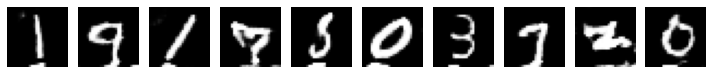

16501 [D loss: 0.537507, acc.: 69.53%] [G loss: 1.863507]
16502 [D loss: 0.445606, acc.: 77.34%] [G loss: 1.841381]
16503 [D loss: 0.397482, acc.: 81.25%] [G loss: 1.910587]
16504 [D loss: 0.441440, acc.: 75.78%] [G loss: 1.980406]
16505 [D loss: 0.317613, acc.: 86.72%] [G loss: 1.987955]
16506 [D loss: 0.346753, acc.: 81.25%] [G loss: 1.835027]
16507 [D loss: 0.371925, acc.: 82.81%] [G loss: 1.650093]
16508 [D loss: 0.332473, acc.: 85.94%] [G loss: 1.879485]
16509 [D loss: 0.337422, acc.: 85.16%] [G loss: 1.880697]
16510 [D loss: 0.395793, acc.: 81.25%] [G loss: 1.782498]
16511 [D loss: 0.421809, acc.: 80.47%] [G loss: 1.780110]
16512 [D loss: 0.353370, acc.: 82.03%] [G loss: 1.654191]
16513 [D loss: 0.451068, acc.: 79.69%] [G loss: 2.080199]
16514 [D loss: 0.387653, acc.: 82.81%] [G loss: 1.994702]
16515 [D loss: 0.394943, acc.: 82.03%] [G loss: 2.014900]
16516 [D loss: 0.529295, acc.: 75.00%] [G loss: 1.787251]
16517 [D loss: 0.404976, acc.: 78.91%] [G loss: 1.626564]
16518 [D loss:

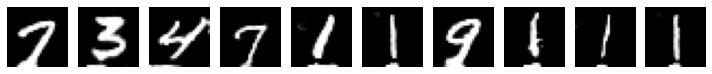

16601 [D loss: 0.451910, acc.: 79.69%] [G loss: 1.988229]
16602 [D loss: 0.509791, acc.: 71.09%] [G loss: 1.767061]
16603 [D loss: 0.427585, acc.: 77.34%] [G loss: 1.563998]
16604 [D loss: 0.373505, acc.: 80.47%] [G loss: 1.689102]
16605 [D loss: 0.413181, acc.: 75.00%] [G loss: 1.831556]
16606 [D loss: 0.449461, acc.: 80.47%] [G loss: 2.025389]
16607 [D loss: 0.454877, acc.: 78.91%] [G loss: 1.977715]
16608 [D loss: 0.383043, acc.: 82.81%] [G loss: 2.107782]
16609 [D loss: 0.429634, acc.: 80.47%] [G loss: 1.853316]
16610 [D loss: 0.460708, acc.: 78.91%] [G loss: 1.702079]
16611 [D loss: 0.422958, acc.: 79.69%] [G loss: 1.626901]
16612 [D loss: 0.412709, acc.: 82.81%] [G loss: 1.893461]
16613 [D loss: 0.398708, acc.: 78.91%] [G loss: 1.870334]
16614 [D loss: 0.454391, acc.: 77.34%] [G loss: 1.798667]
16615 [D loss: 0.472271, acc.: 77.34%] [G loss: 1.952229]
16616 [D loss: 0.511207, acc.: 75.00%] [G loss: 2.159313]
16617 [D loss: 0.562027, acc.: 71.88%] [G loss: 2.001654]
16618 [D loss:

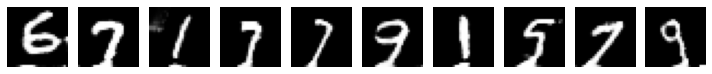

16701 [D loss: 0.432010, acc.: 80.47%] [G loss: 2.016207]
16702 [D loss: 0.389807, acc.: 82.03%] [G loss: 1.981377]
16703 [D loss: 0.483701, acc.: 73.44%] [G loss: 1.522520]
16704 [D loss: 0.514116, acc.: 74.22%] [G loss: 1.382350]
16705 [D loss: 0.500847, acc.: 75.78%] [G loss: 1.405577]
16706 [D loss: 0.522448, acc.: 73.44%] [G loss: 1.741213]
16707 [D loss: 0.421946, acc.: 80.47%] [G loss: 2.062811]
16708 [D loss: 0.358486, acc.: 84.38%] [G loss: 2.116563]
16709 [D loss: 0.450215, acc.: 79.69%] [G loss: 1.726853]
16710 [D loss: 0.410125, acc.: 82.81%] [G loss: 1.741881]
16711 [D loss: 0.491618, acc.: 75.00%] [G loss: 1.695309]
16712 [D loss: 0.366773, acc.: 85.94%] [G loss: 1.829042]
16713 [D loss: 0.392940, acc.: 82.81%] [G loss: 1.877687]
16714 [D loss: 0.494865, acc.: 76.56%] [G loss: 1.845791]
16715 [D loss: 0.450346, acc.: 83.59%] [G loss: 1.812009]
16716 [D loss: 0.388537, acc.: 83.59%] [G loss: 1.563771]
16717 [D loss: 0.442035, acc.: 77.34%] [G loss: 1.809091]
16718 [D loss:

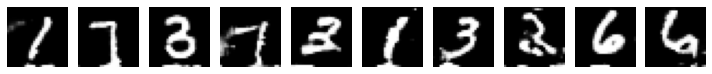

16801 [D loss: 0.457252, acc.: 80.47%] [G loss: 1.496192]
16802 [D loss: 0.494211, acc.: 75.00%] [G loss: 1.206059]
16803 [D loss: 0.511202, acc.: 74.22%] [G loss: 1.252163]
16804 [D loss: 0.368143, acc.: 82.03%] [G loss: 1.850652]
16805 [D loss: 0.335500, acc.: 82.81%] [G loss: 2.165183]
16806 [D loss: 0.470061, acc.: 73.44%] [G loss: 2.179280]
16807 [D loss: 0.561905, acc.: 71.09%] [G loss: 1.701551]
16808 [D loss: 0.516136, acc.: 75.00%] [G loss: 1.507504]
16809 [D loss: 0.482455, acc.: 69.53%] [G loss: 1.388871]
16810 [D loss: 0.403345, acc.: 84.38%] [G loss: 1.640378]
16811 [D loss: 0.366306, acc.: 85.94%] [G loss: 1.693653]
16812 [D loss: 0.493530, acc.: 77.34%] [G loss: 1.764309]
16813 [D loss: 0.418728, acc.: 79.69%] [G loss: 2.017530]
16814 [D loss: 0.364497, acc.: 82.03%] [G loss: 2.041240]
16815 [D loss: 0.456300, acc.: 78.91%] [G loss: 1.757086]
16816 [D loss: 0.431826, acc.: 78.91%] [G loss: 1.623821]
16817 [D loss: 0.360155, acc.: 83.59%] [G loss: 1.980920]
16818 [D loss:

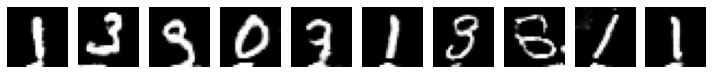

16901 [D loss: 0.416945, acc.: 79.69%] [G loss: 1.941902]
16902 [D loss: 0.485768, acc.: 77.34%] [G loss: 1.834998]
16903 [D loss: 0.533233, acc.: 71.09%] [G loss: 1.788912]
16904 [D loss: 0.389189, acc.: 82.81%] [G loss: 1.839052]
16905 [D loss: 0.486205, acc.: 76.56%] [G loss: 1.603176]
16906 [D loss: 0.464858, acc.: 75.78%] [G loss: 1.611259]
16907 [D loss: 0.386209, acc.: 83.59%] [G loss: 1.625842]
16908 [D loss: 0.647274, acc.: 68.75%] [G loss: 1.966004]
16909 [D loss: 0.356197, acc.: 80.47%] [G loss: 2.134499]
16910 [D loss: 0.472813, acc.: 79.69%] [G loss: 1.842686]
16911 [D loss: 0.452416, acc.: 78.91%] [G loss: 1.620392]
16912 [D loss: 0.408635, acc.: 82.03%] [G loss: 1.463005]
16913 [D loss: 0.500286, acc.: 76.56%] [G loss: 1.712764]
16914 [D loss: 0.376243, acc.: 84.38%] [G loss: 2.236606]
16915 [D loss: 0.377570, acc.: 82.03%] [G loss: 2.239356]
16916 [D loss: 0.411060, acc.: 81.25%] [G loss: 2.050583]
16917 [D loss: 0.439176, acc.: 80.47%] [G loss: 1.958788]
16918 [D loss:

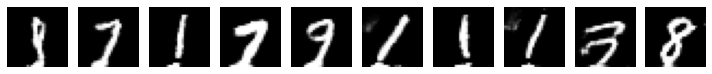

17001 [D loss: 0.533709, acc.: 74.22%] [G loss: 1.854910]
17002 [D loss: 0.389761, acc.: 82.81%] [G loss: 2.036355]
17003 [D loss: 0.460108, acc.: 76.56%] [G loss: 1.963431]
17004 [D loss: 0.435840, acc.: 79.69%] [G loss: 2.013472]
17005 [D loss: 0.443064, acc.: 79.69%] [G loss: 1.894502]
17006 [D loss: 0.430362, acc.: 78.12%] [G loss: 2.016438]
17007 [D loss: 0.405250, acc.: 82.81%] [G loss: 2.219134]
17008 [D loss: 0.404017, acc.: 81.25%] [G loss: 1.879905]
17009 [D loss: 0.493730, acc.: 75.78%] [G loss: 1.723453]
17010 [D loss: 0.399560, acc.: 82.03%] [G loss: 2.133601]
17011 [D loss: 0.403903, acc.: 80.47%] [G loss: 2.453881]
17012 [D loss: 0.450215, acc.: 79.69%] [G loss: 1.876174]
17013 [D loss: 0.455335, acc.: 78.91%] [G loss: 1.853944]
17014 [D loss: 0.375210, acc.: 82.03%] [G loss: 1.848210]
17015 [D loss: 0.484759, acc.: 72.66%] [G loss: 1.931003]
17016 [D loss: 0.425817, acc.: 78.91%] [G loss: 1.750349]
17017 [D loss: 0.517802, acc.: 71.88%] [G loss: 1.606605]
17018 [D loss:

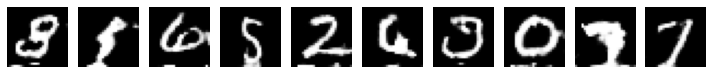

17101 [D loss: 0.427230, acc.: 81.25%] [G loss: 1.737542]
17102 [D loss: 0.492675, acc.: 76.56%] [G loss: 1.553901]
17103 [D loss: 0.427689, acc.: 77.34%] [G loss: 1.830385]
17104 [D loss: 0.408321, acc.: 77.34%] [G loss: 1.989089]
17105 [D loss: 0.411621, acc.: 82.81%] [G loss: 2.054123]
17106 [D loss: 0.621812, acc.: 69.53%] [G loss: 1.571127]
17107 [D loss: 0.646082, acc.: 62.50%] [G loss: 1.383123]
17108 [D loss: 0.400568, acc.: 78.12%] [G loss: 1.665645]
17109 [D loss: 0.383555, acc.: 81.25%] [G loss: 1.817899]
17110 [D loss: 0.400538, acc.: 78.12%] [G loss: 1.968853]
17111 [D loss: 0.468360, acc.: 75.78%] [G loss: 1.699655]
17112 [D loss: 0.547207, acc.: 74.22%] [G loss: 1.432059]
17113 [D loss: 0.492912, acc.: 73.44%] [G loss: 1.260796]
17114 [D loss: 0.452213, acc.: 79.69%] [G loss: 1.584659]
17115 [D loss: 0.357145, acc.: 88.28%] [G loss: 1.913785]
17116 [D loss: 0.453719, acc.: 76.56%] [G loss: 2.026338]
17117 [D loss: 0.445827, acc.: 76.56%] [G loss: 1.947183]
17118 [D loss:

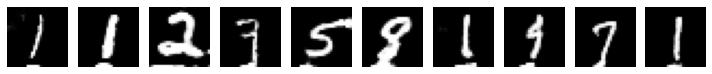

17201 [D loss: 0.459361, acc.: 81.25%] [G loss: 1.987925]
17202 [D loss: 0.487665, acc.: 79.69%] [G loss: 1.833697]
17203 [D loss: 0.468070, acc.: 76.56%] [G loss: 1.379175]
17204 [D loss: 0.492852, acc.: 74.22%] [G loss: 1.484251]
17205 [D loss: 0.425297, acc.: 81.25%] [G loss: 1.845735]
17206 [D loss: 0.400169, acc.: 82.03%] [G loss: 2.131364]
17207 [D loss: 0.438763, acc.: 80.47%] [G loss: 1.785204]
17208 [D loss: 0.484449, acc.: 76.56%] [G loss: 1.576569]
17209 [D loss: 0.431319, acc.: 81.25%] [G loss: 1.655387]
17210 [D loss: 0.461193, acc.: 77.34%] [G loss: 1.685651]
17211 [D loss: 0.495875, acc.: 75.78%] [G loss: 1.734198]
17212 [D loss: 0.406699, acc.: 84.38%] [G loss: 1.781837]
17213 [D loss: 0.406692, acc.: 80.47%] [G loss: 1.614388]
17214 [D loss: 0.430438, acc.: 80.47%] [G loss: 1.589314]
17215 [D loss: 0.568821, acc.: 71.09%] [G loss: 1.690522]
17216 [D loss: 0.449724, acc.: 81.25%] [G loss: 1.737547]
17217 [D loss: 0.398113, acc.: 83.59%] [G loss: 1.708455]
17218 [D loss:

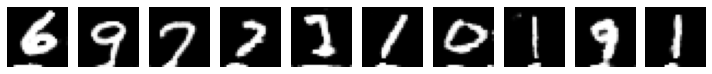

17301 [D loss: 0.420073, acc.: 79.69%] [G loss: 1.964918]
17302 [D loss: 0.353895, acc.: 84.38%] [G loss: 2.104821]
17303 [D loss: 0.431380, acc.: 76.56%] [G loss: 1.881914]
17304 [D loss: 0.518878, acc.: 73.44%] [G loss: 1.580440]
17305 [D loss: 0.409872, acc.: 79.69%] [G loss: 1.647087]
17306 [D loss: 0.356744, acc.: 83.59%] [G loss: 1.976808]
17307 [D loss: 0.384117, acc.: 79.69%] [G loss: 2.132795]
17308 [D loss: 0.594082, acc.: 72.66%] [G loss: 1.815840]
17309 [D loss: 0.562335, acc.: 73.44%] [G loss: 1.550808]
17310 [D loss: 0.399708, acc.: 81.25%] [G loss: 1.713042]
17311 [D loss: 0.446865, acc.: 81.25%] [G loss: 1.839789]
17312 [D loss: 0.441142, acc.: 79.69%] [G loss: 2.029896]
17313 [D loss: 0.539819, acc.: 70.31%] [G loss: 1.798489]
17314 [D loss: 0.506123, acc.: 71.88%] [G loss: 1.645218]
17315 [D loss: 0.481551, acc.: 76.56%] [G loss: 1.487328]
17316 [D loss: 0.422306, acc.: 80.47%] [G loss: 1.419869]
17317 [D loss: 0.509371, acc.: 74.22%] [G loss: 1.523843]
17318 [D loss:

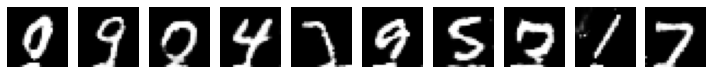

17401 [D loss: 0.360886, acc.: 83.59%] [G loss: 1.796077]
17402 [D loss: 0.404841, acc.: 79.69%] [G loss: 1.729388]
17403 [D loss: 0.438342, acc.: 78.91%] [G loss: 1.902589]
17404 [D loss: 0.379806, acc.: 86.72%] [G loss: 1.993865]
17405 [D loss: 0.385624, acc.: 82.81%] [G loss: 1.952891]
17406 [D loss: 0.410511, acc.: 78.12%] [G loss: 1.829849]
17407 [D loss: 0.507058, acc.: 76.56%] [G loss: 1.812932]
17408 [D loss: 0.400975, acc.: 81.25%] [G loss: 1.940306]
17409 [D loss: 0.368422, acc.: 82.03%] [G loss: 2.061503]
17410 [D loss: 0.380960, acc.: 83.59%] [G loss: 2.019667]
17411 [D loss: 0.374519, acc.: 84.38%] [G loss: 2.010221]
17412 [D loss: 0.383073, acc.: 81.25%] [G loss: 1.860348]
17413 [D loss: 0.442626, acc.: 82.03%] [G loss: 1.764572]
17414 [D loss: 0.417412, acc.: 82.03%] [G loss: 1.787728]
17415 [D loss: 0.645405, acc.: 66.41%] [G loss: 1.784288]
17416 [D loss: 0.418826, acc.: 83.59%] [G loss: 1.928946]
17417 [D loss: 0.410390, acc.: 83.59%] [G loss: 2.118532]
17418 [D loss:

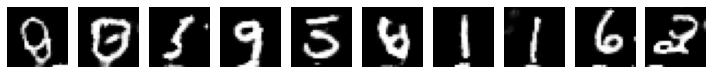

17501 [D loss: 0.499732, acc.: 74.22%] [G loss: 1.758604]
17502 [D loss: 0.409338, acc.: 78.91%] [G loss: 1.899295]
17503 [D loss: 0.516768, acc.: 73.44%] [G loss: 1.825651]
17504 [D loss: 0.526945, acc.: 75.00%] [G loss: 1.819307]
17505 [D loss: 0.346539, acc.: 86.72%] [G loss: 1.947310]
17506 [D loss: 0.466583, acc.: 76.56%] [G loss: 1.890778]
17507 [D loss: 0.462814, acc.: 75.78%] [G loss: 1.717081]
17508 [D loss: 0.418523, acc.: 81.25%] [G loss: 1.688240]
17509 [D loss: 0.349841, acc.: 82.03%] [G loss: 2.072033]
17510 [D loss: 0.340976, acc.: 85.16%] [G loss: 2.205826]
17511 [D loss: 0.460028, acc.: 80.47%] [G loss: 1.659027]
17512 [D loss: 0.389208, acc.: 82.03%] [G loss: 1.450700]
17513 [D loss: 0.336762, acc.: 88.28%] [G loss: 1.812513]
17514 [D loss: 0.347428, acc.: 84.38%] [G loss: 2.201545]
17515 [D loss: 0.386175, acc.: 79.69%] [G loss: 2.189693]
17516 [D loss: 0.431581, acc.: 80.47%] [G loss: 2.249176]
17517 [D loss: 0.368467, acc.: 82.81%] [G loss: 2.064384]
17518 [D loss:

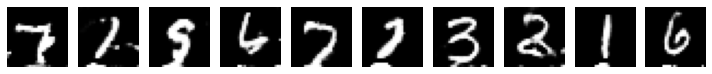

17601 [D loss: 0.391470, acc.: 81.25%] [G loss: 2.212288]
17602 [D loss: 0.527158, acc.: 71.88%] [G loss: 1.910649]
17603 [D loss: 0.430565, acc.: 75.00%] [G loss: 1.566164]
17604 [D loss: 0.475990, acc.: 74.22%] [G loss: 1.563812]
17605 [D loss: 0.373533, acc.: 82.03%] [G loss: 1.844687]
17606 [D loss: 0.413255, acc.: 82.03%] [G loss: 2.119954]
17607 [D loss: 0.495847, acc.: 76.56%] [G loss: 2.158854]
17608 [D loss: 0.426736, acc.: 83.59%] [G loss: 1.664695]
17609 [D loss: 0.514761, acc.: 74.22%] [G loss: 1.557590]
17610 [D loss: 0.488403, acc.: 82.03%] [G loss: 1.488123]
17611 [D loss: 0.473974, acc.: 78.12%] [G loss: 1.674762]
17612 [D loss: 0.394124, acc.: 82.03%] [G loss: 2.082928]
17613 [D loss: 0.468052, acc.: 75.78%] [G loss: 1.902608]
17614 [D loss: 0.648303, acc.: 67.19%] [G loss: 1.514572]
17615 [D loss: 0.430153, acc.: 76.56%] [G loss: 1.553034]
17616 [D loss: 0.435328, acc.: 78.91%] [G loss: 1.507657]
17617 [D loss: 0.361484, acc.: 88.28%] [G loss: 1.649960]
17618 [D loss:

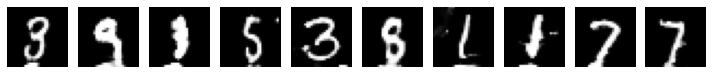

17701 [D loss: 0.392635, acc.: 83.59%] [G loss: 2.317594]
17702 [D loss: 0.539889, acc.: 75.78%] [G loss: 2.033956]
17703 [D loss: 0.502016, acc.: 75.00%] [G loss: 1.530886]
17704 [D loss: 0.414358, acc.: 81.25%] [G loss: 1.387093]
17705 [D loss: 0.480255, acc.: 75.78%] [G loss: 1.519175]
17706 [D loss: 0.365018, acc.: 82.81%] [G loss: 1.801354]
17707 [D loss: 0.306470, acc.: 87.50%] [G loss: 2.128704]
17708 [D loss: 0.505648, acc.: 75.00%] [G loss: 2.185702]
17709 [D loss: 0.540966, acc.: 74.22%] [G loss: 1.818885]
17710 [D loss: 0.470379, acc.: 76.56%] [G loss: 1.384125]
17711 [D loss: 0.580990, acc.: 71.88%] [G loss: 1.361787]
17712 [D loss: 0.531280, acc.: 68.75%] [G loss: 1.689483]
17713 [D loss: 0.395265, acc.: 82.81%] [G loss: 1.947197]
17714 [D loss: 0.514095, acc.: 70.31%] [G loss: 1.967020]
17715 [D loss: 0.432674, acc.: 80.47%] [G loss: 1.667482]
17716 [D loss: 0.525014, acc.: 71.88%] [G loss: 1.459625]
17717 [D loss: 0.378036, acc.: 83.59%] [G loss: 1.674536]
17718 [D loss:

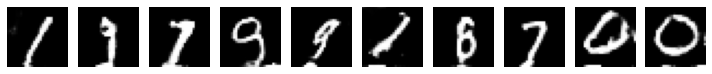

17801 [D loss: 0.351250, acc.: 78.12%] [G loss: 1.946292]
17802 [D loss: 0.387265, acc.: 82.81%] [G loss: 2.163247]
17803 [D loss: 0.361995, acc.: 83.59%] [G loss: 2.157297]
17804 [D loss: 0.469164, acc.: 78.91%] [G loss: 1.800772]
17805 [D loss: 0.375667, acc.: 82.03%] [G loss: 1.692810]
17806 [D loss: 0.475813, acc.: 75.78%] [G loss: 1.782364]
17807 [D loss: 0.439592, acc.: 78.91%] [G loss: 1.581813]
17808 [D loss: 0.337190, acc.: 85.94%] [G loss: 2.018615]
17809 [D loss: 0.457815, acc.: 78.91%] [G loss: 1.971649]
17810 [D loss: 0.422737, acc.: 76.56%] [G loss: 2.178622]
17811 [D loss: 0.384209, acc.: 84.38%] [G loss: 2.066312]
17812 [D loss: 0.418527, acc.: 85.94%] [G loss: 1.871689]
17813 [D loss: 0.616530, acc.: 68.75%] [G loss: 1.532545]
17814 [D loss: 0.451841, acc.: 75.78%] [G loss: 1.590065]
17815 [D loss: 0.367776, acc.: 85.94%] [G loss: 1.799661]
17816 [D loss: 0.350469, acc.: 86.72%] [G loss: 2.098353]
17817 [D loss: 0.469554, acc.: 74.22%] [G loss: 1.979471]
17818 [D loss:

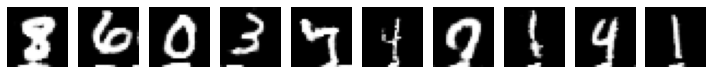

17901 [D loss: 0.456223, acc.: 79.69%] [G loss: 1.953998]
17902 [D loss: 0.422947, acc.: 80.47%] [G loss: 2.408036]
17903 [D loss: 0.366863, acc.: 83.59%] [G loss: 2.378656]
17904 [D loss: 0.562282, acc.: 70.31%] [G loss: 1.963063]
17905 [D loss: 0.408700, acc.: 79.69%] [G loss: 1.459008]
17906 [D loss: 0.467238, acc.: 76.56%] [G loss: 1.464196]
17907 [D loss: 0.522161, acc.: 75.00%] [G loss: 1.556529]
17908 [D loss: 0.388421, acc.: 80.47%] [G loss: 1.887274]
17909 [D loss: 0.323371, acc.: 85.94%] [G loss: 1.874997]
17910 [D loss: 0.488464, acc.: 76.56%] [G loss: 1.704282]
17911 [D loss: 0.524073, acc.: 71.88%] [G loss: 1.475434]
17912 [D loss: 0.486746, acc.: 77.34%] [G loss: 1.386907]
17913 [D loss: 0.474793, acc.: 76.56%] [G loss: 1.829223]
17914 [D loss: 0.454565, acc.: 78.12%] [G loss: 1.877571]
17915 [D loss: 0.477431, acc.: 71.88%] [G loss: 1.656941]
17916 [D loss: 0.491930, acc.: 75.78%] [G loss: 1.466727]
17917 [D loss: 0.497088, acc.: 75.78%] [G loss: 1.302670]
17918 [D loss:

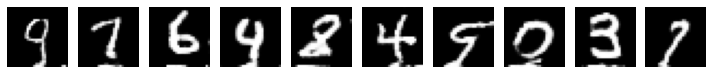

18001 [D loss: 0.389807, acc.: 82.81%] [G loss: 1.736762]
18002 [D loss: 0.459606, acc.: 78.12%] [G loss: 1.722565]
18003 [D loss: 0.397314, acc.: 82.03%] [G loss: 1.835729]
18004 [D loss: 0.440736, acc.: 79.69%] [G loss: 1.678637]
18005 [D loss: 0.430007, acc.: 79.69%] [G loss: 1.807352]
18006 [D loss: 0.359272, acc.: 84.38%] [G loss: 2.038588]
18007 [D loss: 0.355543, acc.: 83.59%] [G loss: 1.942521]
18008 [D loss: 0.439072, acc.: 80.47%] [G loss: 1.778302]
18009 [D loss: 0.492297, acc.: 74.22%] [G loss: 1.507016]
18010 [D loss: 0.384721, acc.: 83.59%] [G loss: 1.769763]
18011 [D loss: 0.376675, acc.: 82.03%] [G loss: 1.991709]
18012 [D loss: 0.344883, acc.: 82.03%] [G loss: 2.386493]
18013 [D loss: 0.516073, acc.: 74.22%] [G loss: 1.982656]
18014 [D loss: 0.496667, acc.: 82.03%] [G loss: 1.702805]
18015 [D loss: 0.366584, acc.: 85.94%] [G loss: 1.685576]
18016 [D loss: 0.444509, acc.: 76.56%] [G loss: 1.765500]
18017 [D loss: 0.478040, acc.: 79.69%] [G loss: 1.778688]
18018 [D loss:

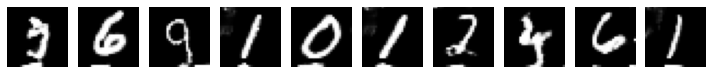

18101 [D loss: 0.388294, acc.: 81.25%] [G loss: 2.466923]
18102 [D loss: 0.413072, acc.: 82.03%] [G loss: 2.395199]
18103 [D loss: 0.485267, acc.: 75.00%] [G loss: 1.732004]
18104 [D loss: 0.488024, acc.: 75.78%] [G loss: 1.647499]
18105 [D loss: 0.429883, acc.: 82.03%] [G loss: 1.654497]
18106 [D loss: 0.393294, acc.: 85.16%] [G loss: 1.761538]
18107 [D loss: 0.475269, acc.: 75.78%] [G loss: 1.704506]
18108 [D loss: 0.432344, acc.: 76.56%] [G loss: 1.424685]
18109 [D loss: 0.435779, acc.: 79.69%] [G loss: 1.679622]
18110 [D loss: 0.482722, acc.: 74.22%] [G loss: 1.953579]
18111 [D loss: 0.455334, acc.: 78.91%] [G loss: 1.829004]
18112 [D loss: 0.568728, acc.: 74.22%] [G loss: 1.486077]
18113 [D loss: 0.466722, acc.: 79.69%] [G loss: 1.644156]
18114 [D loss: 0.334605, acc.: 84.38%] [G loss: 2.194595]
18115 [D loss: 0.520450, acc.: 71.88%] [G loss: 2.011536]
18116 [D loss: 0.526584, acc.: 68.75%] [G loss: 1.709846]
18117 [D loss: 0.483448, acc.: 75.78%] [G loss: 1.421400]
18118 [D loss:

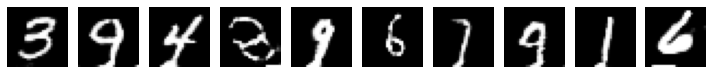

18201 [D loss: 0.405488, acc.: 78.91%] [G loss: 1.987460]
18202 [D loss: 0.449229, acc.: 78.91%] [G loss: 1.513441]
18203 [D loss: 0.500051, acc.: 72.66%] [G loss: 1.395933]
18204 [D loss: 0.432462, acc.: 78.91%] [G loss: 1.546299]
18205 [D loss: 0.426704, acc.: 79.69%] [G loss: 1.931578]
18206 [D loss: 0.319173, acc.: 85.16%] [G loss: 2.092430]
18207 [D loss: 0.362397, acc.: 83.59%] [G loss: 1.953100]
18208 [D loss: 0.475925, acc.: 76.56%] [G loss: 1.702587]
18209 [D loss: 0.411507, acc.: 77.34%] [G loss: 1.695320]
18210 [D loss: 0.459045, acc.: 77.34%] [G loss: 1.915983]
18211 [D loss: 0.307698, acc.: 89.06%] [G loss: 2.345710]
18212 [D loss: 0.357318, acc.: 80.47%] [G loss: 2.426828]
18213 [D loss: 0.461691, acc.: 75.78%] [G loss: 1.850042]
18214 [D loss: 0.524559, acc.: 77.34%] [G loss: 1.624294]
18215 [D loss: 0.467240, acc.: 76.56%] [G loss: 1.925378]
18216 [D loss: 0.376343, acc.: 84.38%] [G loss: 2.036570]
18217 [D loss: 0.410637, acc.: 82.03%] [G loss: 2.309269]
18218 [D loss:

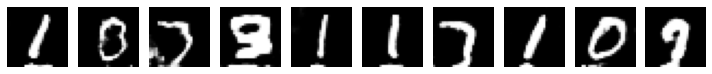

18301 [D loss: 0.528155, acc.: 74.22%] [G loss: 1.899148]
18302 [D loss: 0.457530, acc.: 76.56%] [G loss: 1.795675]
18303 [D loss: 0.468963, acc.: 77.34%] [G loss: 1.698071]
18304 [D loss: 0.476232, acc.: 71.88%] [G loss: 1.767066]
18305 [D loss: 0.392891, acc.: 81.25%] [G loss: 1.652885]
18306 [D loss: 0.411479, acc.: 78.91%] [G loss: 1.803943]
18307 [D loss: 0.398013, acc.: 81.25%] [G loss: 1.774200]
18308 [D loss: 0.347042, acc.: 85.94%] [G loss: 1.910989]
18309 [D loss: 0.343903, acc.: 83.59%] [G loss: 2.030400]
18310 [D loss: 0.368794, acc.: 84.38%] [G loss: 2.120975]
18311 [D loss: 0.339618, acc.: 85.94%] [G loss: 2.215418]
18312 [D loss: 0.432588, acc.: 76.56%] [G loss: 2.043048]
18313 [D loss: 0.540634, acc.: 71.88%] [G loss: 1.562814]
18314 [D loss: 0.434198, acc.: 81.25%] [G loss: 1.660722]
18315 [D loss: 0.314278, acc.: 88.28%] [G loss: 2.053056]
18316 [D loss: 0.423454, acc.: 80.47%] [G loss: 2.179505]
18317 [D loss: 0.466248, acc.: 76.56%] [G loss: 1.880577]
18318 [D loss:

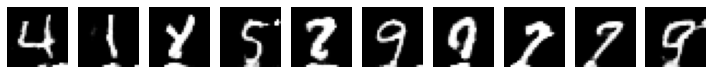

18401 [D loss: 0.445206, acc.: 78.12%] [G loss: 2.020797]
18402 [D loss: 0.328056, acc.: 84.38%] [G loss: 2.443535]
18403 [D loss: 0.366593, acc.: 84.38%] [G loss: 2.261528]
18404 [D loss: 0.440330, acc.: 76.56%] [G loss: 2.193455]
18405 [D loss: 0.406582, acc.: 81.25%] [G loss: 1.766008]
18406 [D loss: 0.376082, acc.: 80.47%] [G loss: 1.534423]
18407 [D loss: 0.296725, acc.: 89.06%] [G loss: 1.831188]
18408 [D loss: 0.418794, acc.: 80.47%] [G loss: 2.325074]
18409 [D loss: 0.366164, acc.: 85.16%] [G loss: 2.697849]
18410 [D loss: 0.316079, acc.: 90.62%] [G loss: 2.666664]
18411 [D loss: 0.458338, acc.: 79.69%] [G loss: 2.362988]
18412 [D loss: 0.470277, acc.: 77.34%] [G loss: 2.209939]
18413 [D loss: 0.511427, acc.: 71.88%] [G loss: 2.049826]
18414 [D loss: 0.426546, acc.: 82.81%] [G loss: 1.870978]
18415 [D loss: 0.356676, acc.: 84.38%] [G loss: 2.078132]
18416 [D loss: 0.381743, acc.: 80.47%] [G loss: 2.142319]
18417 [D loss: 0.595077, acc.: 75.78%] [G loss: 1.891750]
18418 [D loss:

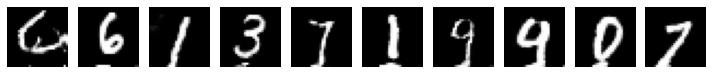

18501 [D loss: 0.528774, acc.: 76.56%] [G loss: 1.940661]
18502 [D loss: 0.467407, acc.: 77.34%] [G loss: 1.801563]
18503 [D loss: 0.500165, acc.: 78.91%] [G loss: 1.731946]
18504 [D loss: 0.484258, acc.: 79.69%] [G loss: 1.498593]
18505 [D loss: 0.478347, acc.: 75.00%] [G loss: 1.648133]
18506 [D loss: 0.470106, acc.: 77.34%] [G loss: 1.762964]
18507 [D loss: 0.468530, acc.: 79.69%] [G loss: 1.940842]
18508 [D loss: 0.409301, acc.: 80.47%] [G loss: 1.977963]
18509 [D loss: 0.489604, acc.: 78.91%] [G loss: 1.682257]
18510 [D loss: 0.318815, acc.: 88.28%] [G loss: 1.440349]
18511 [D loss: 0.613237, acc.: 73.44%] [G loss: 1.400104]
18512 [D loss: 0.366932, acc.: 83.59%] [G loss: 1.757821]
18513 [D loss: 0.291053, acc.: 89.06%] [G loss: 2.062875]
18514 [D loss: 0.450652, acc.: 77.34%] [G loss: 1.995509]
18515 [D loss: 0.528286, acc.: 70.31%] [G loss: 1.715597]
18516 [D loss: 0.421377, acc.: 81.25%] [G loss: 1.574587]
18517 [D loss: 0.372876, acc.: 84.38%] [G loss: 1.485433]
18518 [D loss:

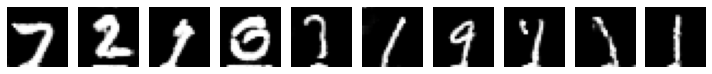

18601 [D loss: 0.417816, acc.: 79.69%] [G loss: 2.102304]
18602 [D loss: 0.433804, acc.: 78.12%] [G loss: 2.049171]
18603 [D loss: 0.360498, acc.: 83.59%] [G loss: 1.975139]
18604 [D loss: 0.483421, acc.: 74.22%] [G loss: 1.805385]
18605 [D loss: 0.439730, acc.: 80.47%] [G loss: 1.782665]
18606 [D loss: 0.410449, acc.: 78.91%] [G loss: 2.212738]
18607 [D loss: 0.424191, acc.: 76.56%] [G loss: 2.383527]
18608 [D loss: 0.334362, acc.: 82.81%] [G loss: 2.194530]
18609 [D loss: 0.496855, acc.: 75.00%] [G loss: 1.647478]
18610 [D loss: 0.541207, acc.: 71.09%] [G loss: 1.590265]
18611 [D loss: 0.265510, acc.: 90.62%] [G loss: 1.978215]
18612 [D loss: 0.313240, acc.: 84.38%] [G loss: 2.512086]
18613 [D loss: 0.469906, acc.: 78.12%] [G loss: 2.377189]
18614 [D loss: 0.510046, acc.: 74.22%] [G loss: 2.105885]
18615 [D loss: 0.576869, acc.: 66.41%] [G loss: 1.657563]
18616 [D loss: 0.553640, acc.: 71.88%] [G loss: 1.620487]
18617 [D loss: 0.378950, acc.: 83.59%] [G loss: 1.906692]
18618 [D loss:

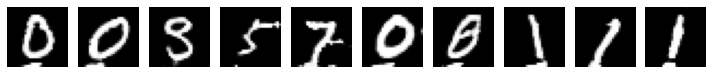

18701 [D loss: 0.347343, acc.: 87.50%] [G loss: 1.898841]
18702 [D loss: 0.438471, acc.: 78.91%] [G loss: 1.946060]
18703 [D loss: 0.469262, acc.: 76.56%] [G loss: 1.536073]
18704 [D loss: 0.539360, acc.: 74.22%] [G loss: 1.568490]
18705 [D loss: 0.429422, acc.: 80.47%] [G loss: 1.989700]
18706 [D loss: 0.453329, acc.: 76.56%] [G loss: 2.142105]
18707 [D loss: 0.445801, acc.: 78.12%] [G loss: 1.784801]
18708 [D loss: 0.446797, acc.: 78.12%] [G loss: 1.574193]
18709 [D loss: 0.476500, acc.: 75.78%] [G loss: 1.383039]
18710 [D loss: 0.408628, acc.: 79.69%] [G loss: 1.502383]
18711 [D loss: 0.365446, acc.: 84.38%] [G loss: 1.948087]
18712 [D loss: 0.513770, acc.: 73.44%] [G loss: 1.668267]
18713 [D loss: 0.444038, acc.: 75.78%] [G loss: 1.565623]
18714 [D loss: 0.434898, acc.: 80.47%] [G loss: 1.814854]
18715 [D loss: 0.335002, acc.: 83.59%] [G loss: 1.916041]
18716 [D loss: 0.476849, acc.: 76.56%] [G loss: 1.842430]
18717 [D loss: 0.385195, acc.: 84.38%] [G loss: 1.730251]
18718 [D loss:

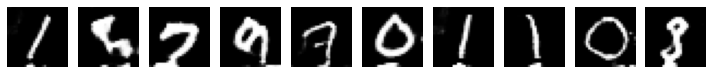

18801 [D loss: 0.413614, acc.: 82.81%] [G loss: 1.613226]
18802 [D loss: 0.437445, acc.: 80.47%] [G loss: 1.656796]
18803 [D loss: 0.404154, acc.: 82.03%] [G loss: 1.910058]
18804 [D loss: 0.405393, acc.: 83.59%] [G loss: 1.771129]
18805 [D loss: 0.559389, acc.: 70.31%] [G loss: 1.849130]
18806 [D loss: 0.414691, acc.: 78.91%] [G loss: 1.713544]
18807 [D loss: 0.421451, acc.: 81.25%] [G loss: 1.614949]
18808 [D loss: 0.492691, acc.: 74.22%] [G loss: 1.657934]
18809 [D loss: 0.367871, acc.: 83.59%] [G loss: 1.834686]
18810 [D loss: 0.331560, acc.: 86.72%] [G loss: 1.986594]
18811 [D loss: 0.466049, acc.: 76.56%] [G loss: 1.804900]
18812 [D loss: 0.325003, acc.: 83.59%] [G loss: 2.021081]
18813 [D loss: 0.444774, acc.: 81.25%] [G loss: 1.878724]
18814 [D loss: 0.417547, acc.: 82.81%] [G loss: 1.913028]
18815 [D loss: 0.404213, acc.: 81.25%] [G loss: 2.166118]
18816 [D loss: 0.480773, acc.: 75.78%] [G loss: 1.909808]
18817 [D loss: 0.420923, acc.: 82.81%] [G loss: 1.840674]
18818 [D loss:

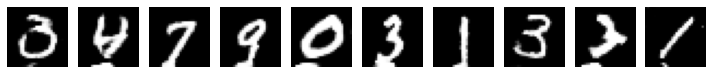

18901 [D loss: 0.491443, acc.: 78.12%] [G loss: 1.662333]
18902 [D loss: 0.479375, acc.: 75.78%] [G loss: 1.368092]
18903 [D loss: 0.464146, acc.: 79.69%] [G loss: 1.649228]
18904 [D loss: 0.383022, acc.: 83.59%] [G loss: 1.849541]
18905 [D loss: 0.462264, acc.: 77.34%] [G loss: 1.937879]
18906 [D loss: 0.365212, acc.: 84.38%] [G loss: 1.789048]
18907 [D loss: 0.528853, acc.: 77.34%] [G loss: 1.920869]
18908 [D loss: 0.347576, acc.: 85.94%] [G loss: 1.882200]
18909 [D loss: 0.494314, acc.: 76.56%] [G loss: 1.656890]
18910 [D loss: 0.497550, acc.: 75.00%] [G loss: 1.423537]
18911 [D loss: 0.374586, acc.: 82.81%] [G loss: 1.812790]
18912 [D loss: 0.406932, acc.: 81.25%] [G loss: 1.929870]
18913 [D loss: 0.368261, acc.: 80.47%] [G loss: 2.306839]
18914 [D loss: 0.411375, acc.: 81.25%] [G loss: 2.032498]
18915 [D loss: 0.361810, acc.: 84.38%] [G loss: 2.009886]
18916 [D loss: 0.421317, acc.: 78.12%] [G loss: 1.497861]
18917 [D loss: 0.406926, acc.: 78.91%] [G loss: 1.627626]
18918 [D loss:

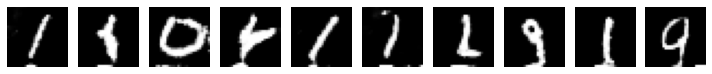

19001 [D loss: 0.430317, acc.: 81.25%] [G loss: 2.118120]
19002 [D loss: 0.437534, acc.: 78.12%] [G loss: 2.171239]
19003 [D loss: 0.390499, acc.: 83.59%] [G loss: 2.105421]
19004 [D loss: 0.531721, acc.: 74.22%] [G loss: 1.801792]
19005 [D loss: 0.525071, acc.: 74.22%] [G loss: 2.014052]
19006 [D loss: 0.435594, acc.: 78.91%] [G loss: 1.968739]
19007 [D loss: 0.450530, acc.: 75.00%] [G loss: 2.286579]
19008 [D loss: 0.364792, acc.: 86.72%] [G loss: 2.031099]
19009 [D loss: 0.551750, acc.: 75.00%] [G loss: 1.566489]
19010 [D loss: 0.484158, acc.: 75.78%] [G loss: 1.532477]
19011 [D loss: 0.417937, acc.: 80.47%] [G loss: 1.930194]
19012 [D loss: 0.365433, acc.: 84.38%] [G loss: 1.973320]
19013 [D loss: 0.381532, acc.: 79.69%] [G loss: 2.017724]
19014 [D loss: 0.556925, acc.: 74.22%] [G loss: 1.662145]
19015 [D loss: 0.421346, acc.: 76.56%] [G loss: 1.569578]
19016 [D loss: 0.358584, acc.: 85.16%] [G loss: 1.615678]
19017 [D loss: 0.489213, acc.: 75.78%] [G loss: 1.784158]
19018 [D loss:

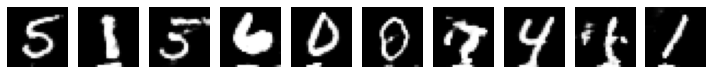

19101 [D loss: 0.446961, acc.: 81.25%] [G loss: 1.820867]
19102 [D loss: 0.463852, acc.: 78.91%] [G loss: 1.811626]
19103 [D loss: 0.445241, acc.: 81.25%] [G loss: 2.052066]
19104 [D loss: 0.460805, acc.: 77.34%] [G loss: 1.930567]
19105 [D loss: 0.495903, acc.: 78.12%] [G loss: 1.934863]
19106 [D loss: 0.428813, acc.: 76.56%] [G loss: 1.932800]
19107 [D loss: 0.337123, acc.: 85.94%] [G loss: 2.087635]
19108 [D loss: 0.423795, acc.: 79.69%] [G loss: 2.295599]
19109 [D loss: 0.501427, acc.: 71.88%] [G loss: 1.855525]
19110 [D loss: 0.389441, acc.: 78.91%] [G loss: 1.781746]
19111 [D loss: 0.564486, acc.: 71.09%] [G loss: 1.494825]
19112 [D loss: 0.431189, acc.: 82.03%] [G loss: 1.704842]
19113 [D loss: 0.496575, acc.: 75.00%] [G loss: 2.000172]
19114 [D loss: 0.580068, acc.: 73.44%] [G loss: 1.890793]
19115 [D loss: 0.505246, acc.: 73.44%] [G loss: 1.915792]
19116 [D loss: 0.499872, acc.: 78.12%] [G loss: 1.596184]
19117 [D loss: 0.512880, acc.: 76.56%] [G loss: 1.425178]
19118 [D loss:

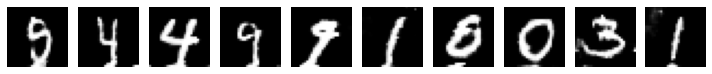

19201 [D loss: 0.354420, acc.: 84.38%] [G loss: 2.134973]
19202 [D loss: 0.373919, acc.: 82.81%] [G loss: 2.031596]
19203 [D loss: 0.561641, acc.: 73.44%] [G loss: 1.618479]
19204 [D loss: 0.445370, acc.: 78.91%] [G loss: 1.670746]
19205 [D loss: 0.446497, acc.: 77.34%] [G loss: 2.024655]
19206 [D loss: 0.383550, acc.: 78.91%] [G loss: 2.106557]
19207 [D loss: 0.418389, acc.: 82.03%] [G loss: 2.059181]
19208 [D loss: 0.281719, acc.: 89.06%] [G loss: 2.166702]
19209 [D loss: 0.378029, acc.: 84.38%] [G loss: 2.123410]
19210 [D loss: 0.500078, acc.: 75.00%] [G loss: 1.593730]
19211 [D loss: 0.470187, acc.: 71.88%] [G loss: 1.608618]
19212 [D loss: 0.404437, acc.: 78.91%] [G loss: 1.833800]
19213 [D loss: 0.569686, acc.: 71.88%] [G loss: 1.957487]
19214 [D loss: 0.493885, acc.: 73.44%] [G loss: 2.043625]
19215 [D loss: 0.366052, acc.: 82.03%] [G loss: 2.197127]
19216 [D loss: 0.465675, acc.: 77.34%] [G loss: 2.050687]
19217 [D loss: 0.468953, acc.: 72.66%] [G loss: 1.733034]
19218 [D loss:

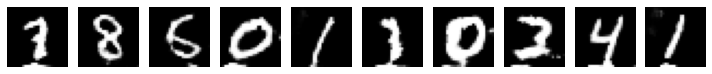

19301 [D loss: 0.369173, acc.: 85.16%] [G loss: 2.330906]
19302 [D loss: 0.494422, acc.: 76.56%] [G loss: 1.955222]
19303 [D loss: 0.468659, acc.: 79.69%] [G loss: 1.296057]
19304 [D loss: 0.543049, acc.: 72.66%] [G loss: 1.257932]
19305 [D loss: 0.459886, acc.: 77.34%] [G loss: 1.688717]
19306 [D loss: 0.443509, acc.: 81.25%] [G loss: 1.992573]
19307 [D loss: 0.679647, acc.: 64.84%] [G loss: 1.707756]
19308 [D loss: 0.443081, acc.: 78.91%] [G loss: 1.470517]
19309 [D loss: 0.474480, acc.: 77.34%] [G loss: 1.635619]
19310 [D loss: 0.392709, acc.: 85.16%] [G loss: 2.161949]
19311 [D loss: 0.493792, acc.: 78.12%] [G loss: 2.028560]
19312 [D loss: 0.509863, acc.: 76.56%] [G loss: 1.737206]
19313 [D loss: 0.486906, acc.: 73.44%] [G loss: 1.642827]
19314 [D loss: 0.374091, acc.: 86.72%] [G loss: 1.596238]
19315 [D loss: 0.337078, acc.: 82.81%] [G loss: 1.639685]
19316 [D loss: 0.358042, acc.: 82.81%] [G loss: 2.021534]
19317 [D loss: 0.525199, acc.: 76.56%] [G loss: 2.007773]
19318 [D loss:

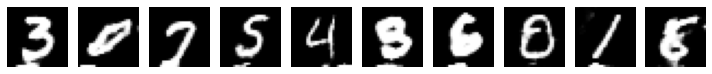

19401 [D loss: 0.549002, acc.: 70.31%] [G loss: 1.932011]
19402 [D loss: 0.395321, acc.: 78.91%] [G loss: 1.921273]
19403 [D loss: 0.458978, acc.: 78.12%] [G loss: 1.938908]
19404 [D loss: 0.453669, acc.: 77.34%] [G loss: 1.679856]
19405 [D loss: 0.548927, acc.: 72.66%] [G loss: 1.749859]
19406 [D loss: 0.476253, acc.: 73.44%] [G loss: 2.039582]
19407 [D loss: 0.324018, acc.: 85.16%] [G loss: 2.566889]
19408 [D loss: 0.362844, acc.: 83.59%] [G loss: 2.650856]
19409 [D loss: 0.468630, acc.: 82.03%] [G loss: 2.364392]
19410 [D loss: 0.404161, acc.: 82.81%] [G loss: 1.847898]
19411 [D loss: 0.466504, acc.: 75.78%] [G loss: 1.728057]
19412 [D loss: 0.348602, acc.: 86.72%] [G loss: 1.855620]
19413 [D loss: 0.456574, acc.: 82.03%] [G loss: 1.835569]
19414 [D loss: 0.384430, acc.: 82.03%] [G loss: 2.053537]
19415 [D loss: 0.418034, acc.: 78.12%] [G loss: 2.176973]
19416 [D loss: 0.364511, acc.: 80.47%] [G loss: 2.362871]
19417 [D loss: 0.468575, acc.: 80.47%] [G loss: 2.492882]
19418 [D loss:

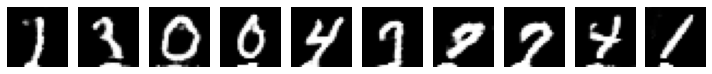

19501 [D loss: 0.414784, acc.: 84.38%] [G loss: 1.768200]
19502 [D loss: 0.366953, acc.: 81.25%] [G loss: 2.002590]
19503 [D loss: 0.398966, acc.: 85.16%] [G loss: 1.906469]
19504 [D loss: 0.436576, acc.: 81.25%] [G loss: 1.712448]
19505 [D loss: 0.418780, acc.: 80.47%] [G loss: 1.831086]
19506 [D loss: 0.381075, acc.: 85.16%] [G loss: 2.137545]
19507 [D loss: 0.377683, acc.: 85.16%] [G loss: 2.086930]
19508 [D loss: 0.405924, acc.: 82.81%] [G loss: 1.667312]
19509 [D loss: 0.333784, acc.: 86.72%] [G loss: 1.759755]
19510 [D loss: 0.409645, acc.: 82.81%] [G loss: 1.812673]
19511 [D loss: 0.409672, acc.: 82.03%] [G loss: 1.893094]
19512 [D loss: 0.351731, acc.: 81.25%] [G loss: 1.993489]
19513 [D loss: 0.463570, acc.: 80.47%] [G loss: 1.965614]
19514 [D loss: 0.400096, acc.: 80.47%] [G loss: 2.134002]
19515 [D loss: 0.513735, acc.: 75.78%] [G loss: 1.799781]
19516 [D loss: 0.475452, acc.: 71.88%] [G loss: 1.482172]
19517 [D loss: 0.485694, acc.: 81.25%] [G loss: 1.500234]
19518 [D loss:

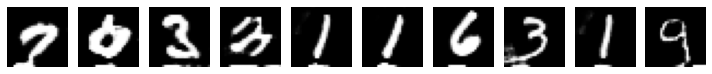

19601 [D loss: 0.403556, acc.: 80.47%] [G loss: 2.480810]
19602 [D loss: 0.501386, acc.: 74.22%] [G loss: 1.916660]
19603 [D loss: 0.482598, acc.: 78.12%] [G loss: 1.816493]
19604 [D loss: 0.395841, acc.: 80.47%] [G loss: 1.746339]
19605 [D loss: 0.467975, acc.: 78.91%] [G loss: 2.024558]
19606 [D loss: 0.552354, acc.: 75.00%] [G loss: 2.159305]
19607 [D loss: 0.452933, acc.: 82.03%] [G loss: 2.035074]
19608 [D loss: 0.607158, acc.: 69.53%] [G loss: 1.655411]
19609 [D loss: 0.417532, acc.: 80.47%] [G loss: 1.599076]
19610 [D loss: 0.400766, acc.: 84.38%] [G loss: 1.465872]
19611 [D loss: 0.471613, acc.: 77.34%] [G loss: 1.692966]
19612 [D loss: 0.414283, acc.: 82.03%] [G loss: 2.061528]
19613 [D loss: 0.369041, acc.: 82.81%] [G loss: 2.039349]
19614 [D loss: 0.517412, acc.: 72.66%] [G loss: 1.558366]
19615 [D loss: 0.373770, acc.: 84.38%] [G loss: 1.400033]
19616 [D loss: 0.436429, acc.: 78.91%] [G loss: 1.376271]
19617 [D loss: 0.406029, acc.: 85.16%] [G loss: 1.657413]
19618 [D loss:

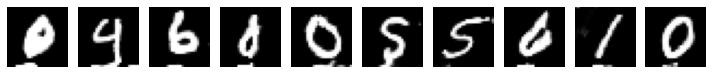

19701 [D loss: 0.448801, acc.: 78.91%] [G loss: 1.937803]
19702 [D loss: 0.567753, acc.: 71.09%] [G loss: 1.625300]
19703 [D loss: 0.462859, acc.: 77.34%] [G loss: 1.675546]
19704 [D loss: 0.452699, acc.: 80.47%] [G loss: 1.789498]
19705 [D loss: 0.391699, acc.: 81.25%] [G loss: 2.089354]
19706 [D loss: 0.404828, acc.: 81.25%] [G loss: 1.937045]
19707 [D loss: 0.446507, acc.: 78.91%] [G loss: 1.839391]
19708 [D loss: 0.449597, acc.: 79.69%] [G loss: 1.776695]
19709 [D loss: 0.490585, acc.: 75.78%] [G loss: 1.669052]
19710 [D loss: 0.453941, acc.: 81.25%] [G loss: 1.717248]
19711 [D loss: 0.440004, acc.: 78.91%] [G loss: 1.949276]
19712 [D loss: 0.355993, acc.: 85.16%] [G loss: 2.078455]
19713 [D loss: 0.367577, acc.: 85.94%] [G loss: 1.744404]
19714 [D loss: 0.391643, acc.: 82.81%] [G loss: 1.907888]
19715 [D loss: 0.435534, acc.: 77.34%] [G loss: 1.977624]
19716 [D loss: 0.415570, acc.: 80.47%] [G loss: 1.846534]
19717 [D loss: 0.377751, acc.: 82.81%] [G loss: 1.709557]
19718 [D loss:

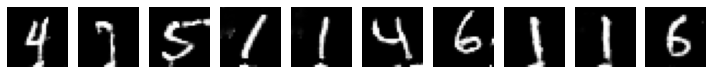

19801 [D loss: 0.410405, acc.: 82.03%] [G loss: 1.513582]
19802 [D loss: 0.406686, acc.: 85.16%] [G loss: 1.509086]
19803 [D loss: 0.439468, acc.: 76.56%] [G loss: 1.642827]
19804 [D loss: 0.376496, acc.: 84.38%] [G loss: 1.866731]
19805 [D loss: 0.375493, acc.: 85.16%] [G loss: 1.921816]
19806 [D loss: 0.418038, acc.: 77.34%] [G loss: 1.936006]
19807 [D loss: 0.453471, acc.: 75.00%] [G loss: 1.894254]
19808 [D loss: 0.475150, acc.: 76.56%] [G loss: 1.928363]
19809 [D loss: 0.462044, acc.: 78.91%] [G loss: 1.918256]
19810 [D loss: 0.396177, acc.: 79.69%] [G loss: 1.824991]
19811 [D loss: 0.344795, acc.: 87.50%] [G loss: 1.861960]
19812 [D loss: 0.487464, acc.: 75.00%] [G loss: 1.742142]
19813 [D loss: 0.264193, acc.: 92.97%] [G loss: 2.000985]
19814 [D loss: 0.420750, acc.: 79.69%] [G loss: 1.961074]
19815 [D loss: 0.338896, acc.: 82.81%] [G loss: 1.904311]
19816 [D loss: 0.443159, acc.: 80.47%] [G loss: 1.768458]
19817 [D loss: 0.477800, acc.: 75.00%] [G loss: 2.103980]
19818 [D loss:

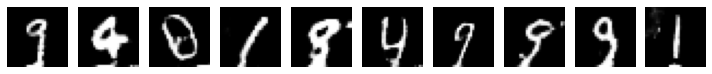

19901 [D loss: 0.465448, acc.: 77.34%] [G loss: 2.009369]
19902 [D loss: 0.473407, acc.: 75.78%] [G loss: 2.281315]
19903 [D loss: 0.379838, acc.: 82.03%] [G loss: 2.359638]
19904 [D loss: 0.533617, acc.: 72.66%] [G loss: 1.919543]
19905 [D loss: 0.467165, acc.: 78.91%] [G loss: 1.525075]
19906 [D loss: 0.498829, acc.: 81.25%] [G loss: 1.555483]
19907 [D loss: 0.425479, acc.: 77.34%] [G loss: 1.686537]
19908 [D loss: 0.457278, acc.: 78.91%] [G loss: 1.859314]
19909 [D loss: 0.441405, acc.: 78.12%] [G loss: 1.979058]
19910 [D loss: 0.434702, acc.: 78.91%] [G loss: 1.860737]
19911 [D loss: 0.461498, acc.: 82.03%] [G loss: 1.717164]
19912 [D loss: 0.360185, acc.: 83.59%] [G loss: 1.773507]
19913 [D loss: 0.333814, acc.: 88.28%] [G loss: 1.786776]
19914 [D loss: 0.464088, acc.: 78.12%] [G loss: 1.372198]
19915 [D loss: 0.394567, acc.: 82.03%] [G loss: 1.634722]
19916 [D loss: 0.469581, acc.: 78.12%] [G loss: 1.660178]
19917 [D loss: 0.473255, acc.: 78.12%] [G loss: 2.028810]
19918 [D loss:

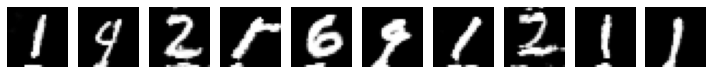

In [46]:
gan=DCGAN()
gan.train(epochs=20000)
